# UH-WRRC- ASPA  FloPy model of Tutuila Island

This model is UNDER DEVELOPMENT and is by no means a finished producct!

### Set up cell. Specify modules and paths. hopefully all modules are installed, if not may need to 
- explore the environment.yml file and see if anything is missing from the environment
- explore the local environments to address any issues
- rebuild the environment with environment.yml or manually 

In [130]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))


import os
import sys
import platform
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.export.shapefile_utils import shp2recarray
from rasterio import Affine
from flopy.utils.reference import SpatialReference
import shapefile    # not used directly here but for some reason flopy needs this to do shapefile stuff and BTW its not import pyshp as you would think its import shapefile, dumb...
import pandas as pd
import fiona
from rasterio.features import rasterize
import rasterio
import rasterio.mask
import geopandas
from osgeo import gdal

import simplekml
import ogr
from shapely.wkb import loads

from scipy.interpolate import interp2d
import scipy.optimize as opt

GIS_files = os.path.join(".", 'GIS_Data')       # path to the GIS data folder

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join('Flo_py_wrkspace')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
figurespace = os.path.join(workspace, "Figures")
if not os.path.exists(figurespace):
    os.makedirs(figurespace)

# define some spatial reference objects
WGS84UTM2S_string = 'PROJCS["WGS_1984_UTM_Zone_2S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'
model_epsg = 32702   # epsg code specifying coordinate reference system: in this case, UTM zone 2S, WGS 84, A proj4 string has also been fetched from <spatialreference.org> using the supplied epsg code.


3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.16.4
matplotlib version: 3.1.1
flopy version: 3.2.12


### Toggles

In [131]:
# in line plotting and saving options. Change these to plot or not to plot inline
Plotnsave_plot = True
Plotnsave_save = True

# flag for either using manually entered values for HK or optomized values. once the optimizer is run the flag will change to true and will use the optimiezd set in memory, run this cell to reset 
optimized_flag = False

# toggle this for interactive plots
%matplotlib inline   
# toggle this for simple plots (nneded for optimization plots)
#   %matplotlib notebook  

pd.set_option('display.max_rows', 75)    # change number of rows to display if want

### model geometry definition 

Shapefile Boundaries: (516771.84375001956, 8410923.999999458, 547311.6875000503, 8425832.999999477)
wrote Flo_py_wrkspace\Model_polyarea.shp
wrote Flo_py_wrkspace\Model_grid.shp


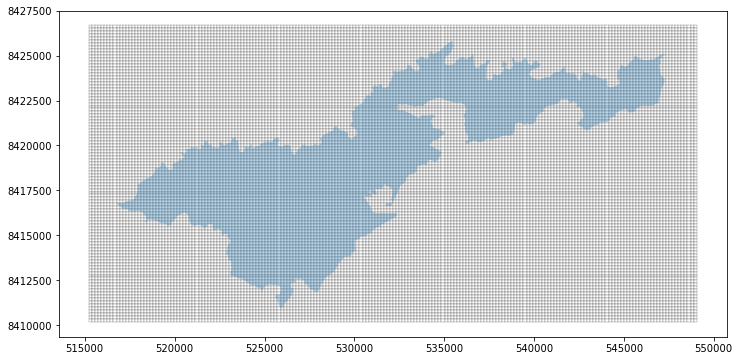

In [132]:
''' Define the number of layers, rows and columns. The heads are computed quasi-steady state (hence a steady MODFLOW run) while
the interface will move. There are three stress periods with a length of 200, 12, and 18 years and
1,000, 120, and 180 steps.'''

ncol = 200
nrow = 100
nlay = 1

# model run times and stress period data
Number_of_years = 400
nper = 1                     # Number of model stress periods (the default is 1)
perlen = [365.25*Number_of_years]               # An array of the stress period lengths in days separated by commas
nstp = [Number_of_years]                        # Number of time steps in each stress period (default is 1).           
tsmult = 1                                   # Time step multiplier 
steady = True
                           
# output control parameters
Save_every_how_many_steps = 20      # elevation of the interface is output every 50 time steps
spd = {}
for istp in range(Save_every_how_many_steps-1, nstp[0]+1, Save_every_how_many_steps):
    spd[(0, istp)] = ['save head', 'print budget']
    spd[(0, istp+1)] = []

'''Specify the cell size along the rows (delr) and along the columns (delc) and the top
and bottom of the aquifer for the DIS package.   Note that this block imports model geometry from a polygon shapefile of the area to model '''

# this cell inports the boundary shapefile to make the model around
ra = shp2recarray(os.path.join(GIS_files, 'tut_poly.shp'))
# these are the bondaries of the shapefile
shp_xmin = ra.geometry[0].bounds[0]
shp_ymin = ra.geometry[0].bounds[1]
shp_xmax = ra.geometry[0].bounds[2]
shp_ymax = ra.geometry[0].bounds[3]
print("Shapefile Boundaries: {}".format(ra.geometry[0].bounds))   
#ra.geometry[0].plot() 

xll = int(shp_xmin-(shp_xmax-shp_xmin)*.05)  # Lower left corner of model grid  (note 5% buffer around boundary)
yll = int(shp_ymin-(shp_ymax-shp_ymin)*.05)   # Lower left corner of model grid  (note 5% buffer around boundary)

# grid spacing as a percentage of model x domain (in model units) note 10% buffer around boundary
delr = abs(int((shp_xmax-shp_xmin)*(1/(ncol*.9))))   # the width of each cell
delc = abs(int((shp_ymax-shp_ymin)*(1/(nrow*.9))))   # the height of eech cell

delr_4_sr  = np.ones(ncol, dtype=float) * delr    # This just puts the above into an array for the sr object 
delc_4_sr = np.ones(nrow, dtype=float) * delc    

rotation = 0      # rotation (positive counterclockwise)


# create the model boundary area polygon
sr = SpatialReference(delr=[delr_4_sr.sum()], delc=[delc_4_sr.sum()], xll=xll, yll=yll, rotation=rotation, proj4_str=WGS84UTM2S_string, lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_polyarea.shp'))          # write a shapefile of the model area for later use
prj = open(os.path.join(workspace, 'Model_polyarea.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually
#print("corners are at {}".format(sr.get_extent()))

# create the model boundary grid polygon   (NOTE THIS MUST OVERWRITE THe PREVIOUS sr. definition!)
sr = SpatialReference(delr=delr_4_sr, delc=delc_4_sr, xll=xll, yll=yll, rotation=rotation, proj4_str= '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' , lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_grid.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Model_grid.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually


if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize=(12,6))
    Tutuila = geopandas.read_file(os.path.join(GIS_files, 'tut_poly.shp'))
    Grid = geopandas.read_file(os.path.join(workspace, 'Model_grid.shp'))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2)
    Tutuila.plot(ax=ax, linewidth=2, alpha = .3)

### Assign Layer elevations all fancy like

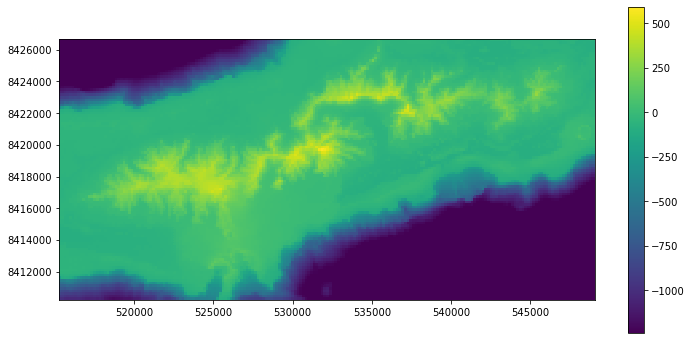

In [204]:
#Set model top to DEM
# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)
Raster_2_Clip = os.path.join("..", "..",  'Static_Data_Storage', 'GIS', 'dem10mprj1.tif')
Clipped_raster = os.path.join(workspace, "DEM_10m_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
top = f(x2, y2)

botm = -1250    # this will clearly need to change to accomadate the Tutuila bathymetry
top = np.where(top <= botm+10, botm+10, top) # force top elevations to always be higher than bottom elevations

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(top, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

## Set up an ibound array with land as active, shelf as specified head and offshore as inactive 

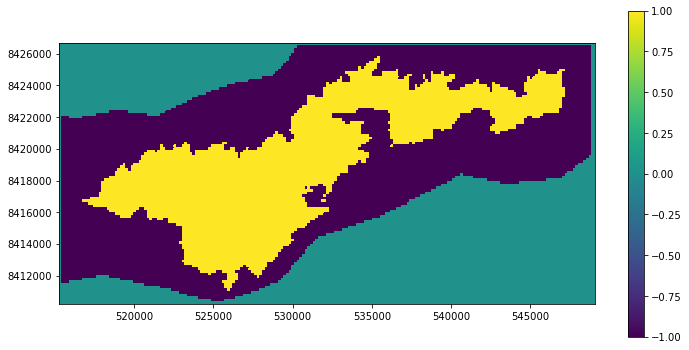

In [219]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells

with fiona.open(os.path.join(GIS_files, 'ibound.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['spec_hed'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
ibound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

# specify initial head 
ihead = np.ones((nlay, nrow, ncol), dtype=np.float)   # ncol
ihead = ihead -.9

#### Use a Tutuila polygon to define the model active area as the island the shelf as specified head, and the offshore as inactive

with fiona.open(os.path.join(GIS_files, 'Tut_poly_for_GHB.shp')) as src:   #    read in Tutuila shapefile 
    records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['spec_hed']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)

Spec_hed_map = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

final_ibound = Spec_hed_map + ibound                              # include a specified head boundary condition in addition to GHB
#final_ibound =  np.where(ibound== -1, 1, final_ibound)           # GHB condition only no specified head

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(final_ibound, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### GHB boundary condtion definition

This is the general head boundary condition, Little to no user modification needs to be done to this, except for that fact that I dont exactly know how this works, and why it is not keeping the heads in the GHB area consistent at zero or 1 or whatever.  I think I need to do more research into how to use this module and it may need to be modified somewhat. 

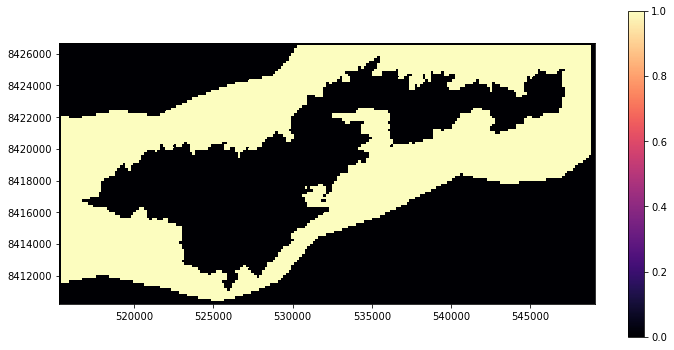

In [220]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells
with fiona.open(os.path.join(GIS_files, 'ibound.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Ibound'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)

GHB_bound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

####Now seting the GHB area  Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells
with fiona.open(os.path.join(GIS_files, 'Tut_poly_for_GHB.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Ibound']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)

Inverse_GHBmap = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
neg_array = np.ones((nrow, ncol), dtype=np.int)    # this is the shape array
ghb_geometry = (Inverse_GHBmap+neg_array)*GHB_bound

nghb = np.sum(ghb_geometry)     # this is the total number of General head cells in the model

colcell, rowcell = np.meshgrid(np.arange(0, ncol), np.arange(0, nrow))  # make mesh grid lists of all the dell indexes 

lrchc = np.zeros((nghb, 5))       # layer(int), row(int), column(int), stage(float), conductance(float) array pile this is what ghb package needs
lrchc[:, 0] = 0                                    # give it layer 1
lrchc[:, 1] = rowcell[ghb_geometry == 1]           # assign the specific row numbers for the active ghb cells
lrchc[:, 2] = colcell[ghb_geometry == 1]           # assign the specific col numbers for the active ghb cells
lrchc[:, 3] = .01                                  # this is the starting head value, maybe change to 1?
lrchc[:, 4] = 1000                   # this is conductance values, probably change later
# create ghb dictionary
ghb_data = {0:lrchc}

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(ghb_geometry, ax=ax, cmap = 'magma')
    ax.set_aspect(1); plt.colorbar(qm)

### Water level Observations
These observations are from a text file in the array inputs folder. New water level observations can simply be added to this text file. 
It would be idea for the user to save the new text file to a new name when adding obaservations, in this case the line below: 
    
    "Unique_frame = pd.read_csv(os.path.join('.',  "Array_inputs", 'Observation_data.txt'))"
    
will need to change to reflect tne new observation file name

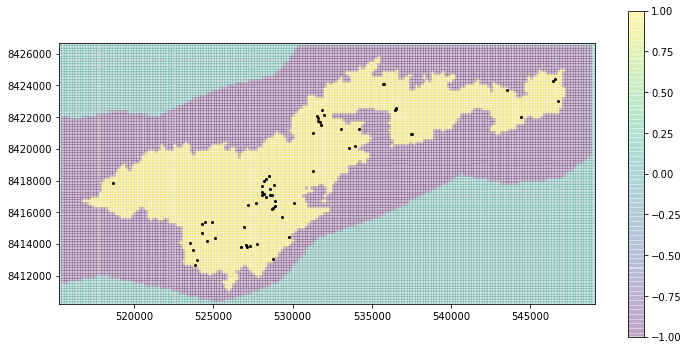

In [221]:
Pdevel_WLs = pd.read_csv(os.path.join("..", "..", 'Static_Data_Storage', 'GIS','Predevelop_WLs_2.csv'))

Pdevel_WLs['row_num'] = Pdevel_WLs['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate 
Pdevel_WLs['col_num'] = Pdevel_WLs['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pdevel_WLs['rowcol']  = list(zip(Pdevel_WLs.row_num, Pdevel_WLs.col_num))                                      # just make a tuplel of the row and col

# This takes obs wells that occupy the same cell and averages them! 
Unique_WLs = Pdevel_WLs.groupby('rowcol', as_index=False).mean()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_WLs["name"] = "Obs_"+Unique_WLs.index.map(str)

nobs = len(Unique_WLs['WL_m_MSL']) 
layervals = [0] * nobs
rowvals = list(Unique_WLs['col_num'].astype(int))
colvals = list(Unique_WLs['row_num'].astype(int))
obsvals = list(Unique_WLs['WL_m_MSL'])
obsnames = list(Unique_WLs["name"])

if Plotnsave_plot: 
    gdf = geopandas.GeoDataFrame(Unique_WLs, geometry=geopandas.points_from_xy(Unique_WLs.x_utm, Unique_WLs.y_utm))
    fig, ax = plt.subplots(figsize = (12,6))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2, alpha = .2)
    qm = sr.plot_array(final_ibound, ax=ax, alpha = .2)
    ax.set_aspect(1); plt.colorbar(qm)
    gdf.plot(ax=ax, color='black', markersize=4)

### Hydraulic condictivty assigned based on zones as defined by shapefiles in a folder

The values at the top of this cell can be modified to change the conductivity in each zone

In [222]:
# this cell either uses the below values or the optimized values for the forward run depending on if the optimizer has been run
Manual_values = [15.60906857, 184.89860934,   7.63843596,   0.84151735,   0.76703913,  2.07640442]

if optimized_flag == True:
    HK_values = results.x
    print("Using: optimized values {}".format(HK_values))
    
else:
    HK_values = Manual_values
    print("Using: manual HK values")

Using: manual HK values


In [223]:
# Function to rasterize the HK zones: 
def rastah_zone(shp):
    with fiona.open(shp) as src:   #    read in Tutuila shapefile
            records = [r for r in src]   
    geoms = [r['geometry'] for r in records]       # shapefile shape
    attr = [r['properties'] for r in records]      # shapefile attributes
    geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
    # affine: work with the geometry to change from raster to grid reference frame 
    trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
    Outrastah = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
    return Outrastah

# path to the location of shapefiles
HK_Zone_path = os.path.join(GIS_files, "Simple_2")

# Rasterize the desired zones
Leone = rastah_zone(os.path.join(HK_Zone_path, 'Leone.shp'))
Tafuna = rastah_zone(os.path.join(HK_Zone_path, 'tafuna.shp'))
Pyro = rastah_zone(os.path.join(HK_Zone_path, 'pyro.shp'))
OldV_tapu = rastah_zone(os.path.join(HK_Zone_path, 'OldV_tapu.shp'))
OldV_Pago = rastah_zone(os.path.join(HK_Zone_path, 'OldV_Pago.shp'))
Malaeimi = rastah_zone(os.path.join(HK_Zone_path, 'Malaeimi.shp'))

HK_raster  = Leone + Tafuna + Pyro + OldV_tapu + OldV_Pago + Malaeimi  # merge all zones together

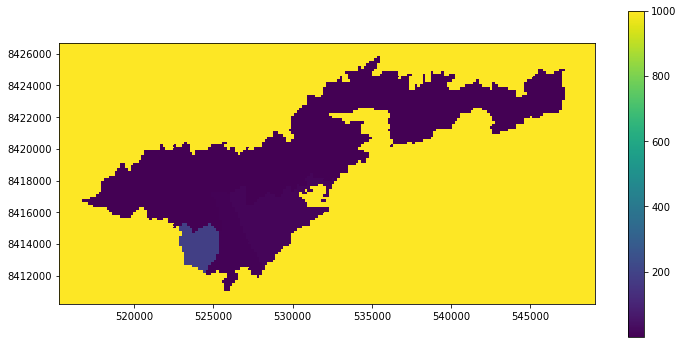

In [224]:
# set the  values

Taf_HK = HK_values[0]
Leo_HK = HK_values[1]
Pyro_HK = HK_values[2]
OVtap_HK = HK_values[3] 
OVpag_HK = HK_values[4]
Malaeimi_HK = HK_values[5]

# replace codes with actual HK values 
HK_raster = np.where(HK_raster== -10, Taf_HK, HK_raster) 
HK_raster = np.where(HK_raster== -20, Leo_HK, HK_raster)
HK_raster = np.where(HK_raster== -30, Pyro_HK, HK_raster)
HK_raster = np.where(HK_raster== -60, OVtap_HK, HK_raster)
HK_raster = np.where(HK_raster== -80, OVpag_HK, HK_raster)
HK_raster = np.where(HK_raster== -40, Malaeimi_HK, HK_raster)

HK_raster = np.where(HK_raster== 0, 1000, HK_raster)   # this is for the areas not covered by HK zones, Should not actually maatter at all!

HK_raster = np.where(HK_raster== -90, 1, HK_raster) # this is for the areas that get messed up somehow
HK_raster = np.where(HK_raster== -70, 1, HK_raster) # this is for the areas that get messed up somehow

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(HK_raster, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

'''Define the layers to be confined and define the horizontal and vertical 
hydraulic conductivity of the aquifer for the LPF package.'''

# lpf data
laytyp = 0
vka = 10

### Import Recharge .asc from SWB output into MODFLOW rech array
(note I am not sure what happens when the model area is bigger then the raster....)

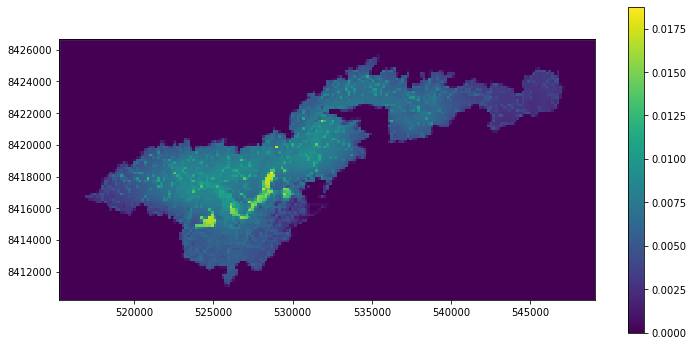

In [225]:
SWB_output_recharge = os.path.join("..", "..", "..", 'ASPA-UH-SWB2_REPO\\output\\post_prcessed_with_MFR\\net_infiltration_annual.asc')  

# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)   
Raster_2_Clip = os.path.join(SWB_output_recharge)
Clipped_raster = os.path.join(workspace, "raw_net_infiltration_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    
out_meta = src.meta.copy()
out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(Clipped_raster, "w", **out_meta) as dest:          # create the new clipped .asc file
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
recharge_raw_SWB = np.loadtxt(Clipped_raster, skiprows=6)

y = np.linspace(0, np.shape(recharge_raw_SWB)[0]-1, np.shape(recharge_raw_SWB)[0])   
x = np.linspace(0, np.shape(recharge_raw_SWB)[1]-1, np.shape(recharge_raw_SWB)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, recharge_raw_SWB, kind='linear')
recharge_resampled = f(x2, y2)
recharge_converted =  recharge_resampled* (0.0254/365)   # recharge comes out of SWB in inches/year and needs to be converted to m/day

recharge_converted = np.where(recharge_converted < 0, 0.001, recharge_converted)   # Interpolation made some negative values, fix that issue by setting them to a positive value

rch_data = {0: recharge_converted}   # dictionary form to specify that it is only on first layer

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(recharge_converted, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### SWI saltwater intruction package, basic parameters

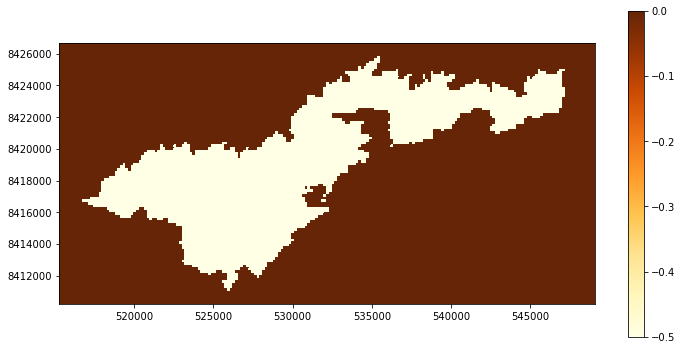

In [226]:
### SWI saltwater intruction package, basic parameters

Make_iso_tricky = Spec_hed_map + ibound

# swi2 data
nadptmx = 10      #    user-defined maximum number of SWI2 time steps in any MODFLOW time step.
nadptmn = 1        # the user-defined minimum number of SWI2 time steps in any MODFLOW time step
nu = [0, 0.025]    # dimensionless density at the top of zone 1 and the dimensionless densities of the surface ???
numult = 5.0
toeslope = nu[1] / numult  #0.005
tipslope = nu[1] / numult  #0.005
z1 = 0 * np.ones((nrow, ncol))
z1[final_ibound == 1] = -.5
z = np.array([[z1]])
iso = np.zeros((nlay, nrow, ncol), dtype=np.int)
iso[0][Make_iso_tricky == -1] = -2

ssz=0.2            # effectve porosity

nsrf = 1  # one freshwater zone and one seawater zone, separated by a single (nsrf = 1) active ZETA surface between the zones

istrat = 1   # Represent Fluid density using the stratified option




# swi2 observations  looks like this is observatons at the well, lets disculde this for now
# obsnam = ['layer1_', 'layer2_']
# obslrc=[[0, 30, 35], [1, 30, 35]]
# nobs = len(obsnam)
# iswiobs = 1051




fig, ax = plt.subplots(figsize = (12,6))
qm = sr.plot_array(z1, ax=ax, cmap = 'YlOrBr')
ax.set_aspect(1); plt.colorbar(qm)

## Build model object - pre-prcess all files 

In [228]:
modelname = 'modelface'

ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=top, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp, tsmult=tsmult)

bas = flopy.modflow.ModflowBas(ml, ibound=final_ibound, strt=ihead)

lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)

rch = flopy.modflow.ModflowRch(ml, rech=rch_data)

oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)

pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)

ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)


#SWI package
swi = flopy.modflow.ModflowSwi2(ml, nsrf=nsrf, istrat=istrat , toeslope=toeslope, tipslope=tipslope, 
                                nu=nu,zeta=z, ssz=ssz, isource=iso, nsolver=1,
                                nadptmx=nadptmx, nadptmn=nadptmn, iswizt=55)


# water level observations
obs_data= []
for i in range(0,nobs):
    obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
    obs_data.append(obs)
hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)

In [229]:
ml.check()


modelface MODEL DATA VALIDATION SUMMARY:
  4 Warnings:
    BAS6 package: isolated cells in ibound array
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 1 stress periods

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 

### Run MODFLOW

In [230]:
ml.write_input()
ml.run_model(silent=False)

FloPy is using the following  executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: modelface.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/08/01 16:19:54

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Ground-Water Flo

 Solving:  Stress period:     1    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   119    Ground-Wa

 Solving:  Stress period:     1    Time step:   218    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   219    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   220    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   221    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   222    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   223    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   224    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   225    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   226    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   227    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   228    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   229    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   230    Ground-Wa

 Solving:  Stress period:     1    Time step:   329    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   330    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   331    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   332    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   333    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   334    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   335    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   336    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   337    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   338    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   339    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   340    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   341    Ground-Wa

(True, [])

C:\Users\cshuler\Anaconda3\envs\ASPA_Framework\lib\site-packages\flopy\plot\map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


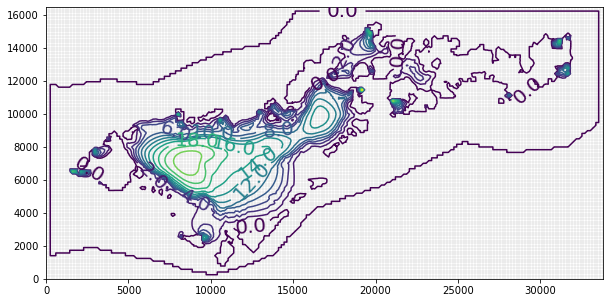

In [231]:
# Post process to graph the results

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

#FV grid extent: (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
#wpt = ((wcol+0.5)*delr, Lx - ((wrow + 0.5)*delc)) # origing at low upper.. b

hds = bf.HeadFile(os.path.join(workspace, '{}.hds'.format(modelname)))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])

##cbb = bf.CellBudgetFile(os.path.join(workspace, '{}.cbc'.format(modelname))) # read budget file
#kstpkper_list = cbb.get_kstpkper()
# cbb.textlist to get a list of data texts
##frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
##fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

# flopy plot object
modelmap = flopy.plot.ModelMap(model=ml, layer=0)
# plot grid
lc = modelmap.plot_grid(alpha=.1) # grid
# plot contour
cs = modelmap.contour_array(head, levels=np.linspace(0, int(head.max()), 15)) # head contour
plt.clabel(cs, fontsize=20, fmt='%1.1f') # contour label
# plot discharge quiver
##quiver = modelmap.plot_discharge(frf, fff, head=head, alpha=.4)

plt.show()


## Observed vs Simulated plot

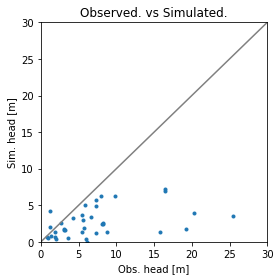

Mean Error: -5.64
Mean Absolute Error: 5.75
RMS Error: 10.86


In [214]:
# plot observations 
observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

# note positive residuals means model is calculating too high negative is model calculates too low 
residuals = []
for idx, i in enumerate(observations):   
    r = observations[idx][0]-observations[idx][1]
    residuals.append(r)

Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,30)
plt.xlim(0,30)

plt.plot([0,20,30],[0,20,30], color= "grey")
plt.tight_layout()
plt.savefig(os.path.join(figurespace, "calibration_result.pdf"))

plt.show()

me = np.mean(Howd_we_do.Residual_m)
mea = np.mean(np.abs(Howd_we_do.Residual_m))
rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))

# plot SWI

In [215]:
# read base model zeta
zfile = flopy.utils.CellBudgetFile(os.path.join(ml.model_ws, modelname+'.zta'))   # read the raw data file produced by MODFLOW SWI2
kstpkper = zfile.get_kstpkper()                                                   # Get a list of unique stress periods and time steps in the file (timestep, stress period) 
zeta = []
for kk in kstpkper:
    zeta.append(zfile.get_data(kstpkper=kk, text='ZETASRF  1')[0])                # turn each surface into an array  Actually a Time x Layer x Col x Row array
zeta = np.array(zeta)

### Plot  E-W cross section

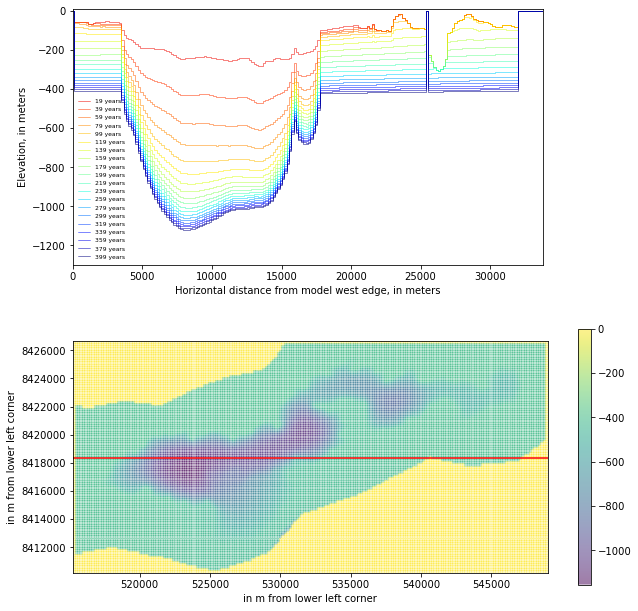

In [216]:
slicerow = 50

plt.rcParams.update({'legend.fontsize': 6, 'legend.frameon' : False})
fig = plt.figure(figsize=(10, 10), facecolor='w')
flft, frgt, fbot, ftop = 0.125, 0.95, 0.125, 0.925
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)

# Create arrays for cross section plotting the x-coordinates and the output years
xcell = np.linspace(0,ncol*delr,ncol)    

# extract years from the zeta array
years=[]                                      # as long as the time step is a 365.25 multiple of the stress period length otherwise this gets arbitrary!
for idx,val in enumerate(kstpkper):
    printyear = round(kstpkper[idx][0] ,1)
    years.append(printyear)
    
# line color definition  (tricky way to cycle through the colorramp)
icolor = len(years)
colormap = plt.cm.jet  #winter
cc = []
cr = np.linspace(0.9, 0.0, icolor)
for idx in cr:
    cc.append(colormap(idx))

# plot cross section
ax = plt.subplot2grid((2, 5), (0, 0), colspan=4)       # have to set up many subplot grid spots then span each plot different ammount cuz the colorbar makes it so the bottom plot doesnt line up (this took 1.5 hours of my life)
# axes limits
ax.set_xlim(0, ncol*delr)
ax.set_ylim(-1300, 10)
for idx in range(len(years)):
    ax.plot(xcell, zeta[idx, 0, slicerow, : ], drawstyle='steps-mid',                                # zeta[idx, 0, 50, :] means idx = timestep,  0 is layer 1 , # is row number to plot along, and : is plot all columns 
            linewidth=0.5, color=cc[idx], label='{:2d} years'.format(years[idx]))
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance from model west edge, in meters')
ax.set_ylabel('Elevation, in meters')


# plan view figure 
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=5)
qm = sr.plot_array(zeta[-1][0], ax=ax2, alpha = .3)

ax2.set_aspect(1); plt.colorbar(qm)
ax2.set_xlabel("in m from lower left corner")
ax2.set_ylabel("in m from lower left corner")
ax2.set_xlim(sr.get_extent()[0], sr.get_extent()[1])
ax2.set_ylim(sr.get_extent()[2], sr.get_extent()[3])


x = np.linspace(0, ncol*delr, ncol)+sr.get_extent()[0]
y = np.ones(ncol)*np.linspace(nrow*delc,0, nrow)[slicerow]+sr.get_extent()[2]

ax2.plot(x,y, color = 'r')
plt.show()

# Scale the axes to have same units as the cross section plot
xtic_vals = ax2.get_xticks()
scale_ax2x = ax2.set_xticklabels(['{:1.0f}'.format(x -516771) for x in xtic_vals])
ytic_vals = ax2.get_yticks()
scale_ax2y = ax2.set_yticklabels(['{:1.0f}'.format(x -8410924) for x in ytic_vals])

### Plot  N-S cross section


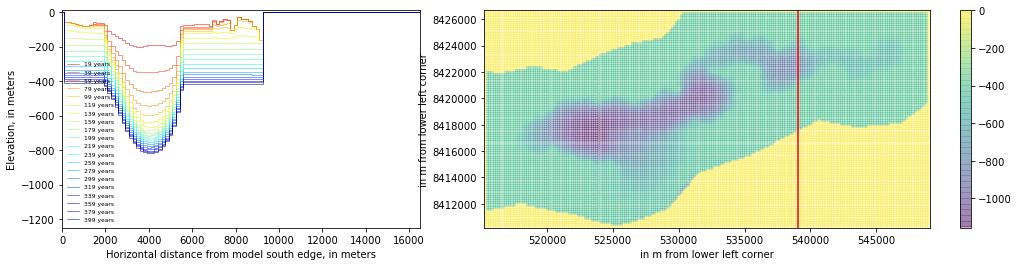

In [218]:
slicecol = 140

plt.rcParams.update({'legend.fontsize': 6, 'legend.frameon' : False})
fig = plt.figure(figsize=(20, 4), facecolor='w')

# Create arrays for cross section plotting the y-coordinates and the output years
#xcell = np.linspace(0,ncol*delr,200)    
xcell = np.linspace(0,nrow*delc,nrow)     

# extract years from the zeta array
years=[]                                      # as long as the time step is a 365.25 multiple of the stress period length otherwise this gets arbitrary!
for idx,val in enumerate(kstpkper):
    printyear = round(kstpkper[idx][0] ,1)
    years.append(printyear)
    
# line color definition  (tricky way to cycle through the colorramp)
icolor = len(years)
colormap = plt.cm.jet  #winter
cc = []
cr = np.linspace(0.9, 0.0, icolor)
for idx in cr:
    cc.append(colormap(idx))

# plot cross section
ax = plt.subplot2grid((1, 9), (0, 0), colspan=3) 
ax.set_xlim(0, nrow*delc)
ax.set_ylim(-1250, 10)
for idx in range(len(years)):
    ax.plot(xcell, zeta[idx, 0, :, slicecol ], drawstyle='steps-mid',                                # zeta[idx, 0, 50, :] means idx = timestep,  0 is layer 1 , # is row number to plot along, and : is plot all columns 
            linewidth=0.5, color=cc[idx], label='{:2d} years'.format(years[idx]))
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance from model south edge, in meters')
ax.set_ylabel('Elevation, in meters')


# plan view figure 
ax2 = plt.subplot2grid((1, 9), (0, 3), colspan=5)
qm = sr.plot_array(zeta[-1][0], ax=ax2, alpha = .3)

ax2.set_aspect(1); plt.colorbar(qm)
ax2.set_xlabel("in m from lower left corner")
ax2.set_ylabel("in m from lower left corner")
ax2.set_xlim(sr.get_extent()[0], sr.get_extent()[1])
ax2.set_ylim(sr.get_extent()[2], sr.get_extent()[3])

y = (np.linspace(0, nrow*delc, nrow) )+ sr.get_extent()[2]
x = np.ones(nrow)*np.linspace(0, ncol*delr,ncol)[slicecol]+sr.get_extent()[0]

ax2.plot(x,y, color = 'r')
plt.show()

# Scale the axes to have same units as the cross section plot
xtic_vals = ax2.get_xticks()
scale_ax2x = ax2.set_xticklabels(['{:1.0f}'.format(x -516771) for x in xtic_vals])
ytic_vals = ax2.get_yticks()
scale_ax2y = ax2.set_yticklabels(['{:1.0f}'.format(abs(x -sr.get_extent()[3])) for x in ytic_vals])

C:\Users\cshuler\Anaconda3\envs\ASPA_Framework\lib\site-packages\flopy\plot\crosssection.py:764: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)


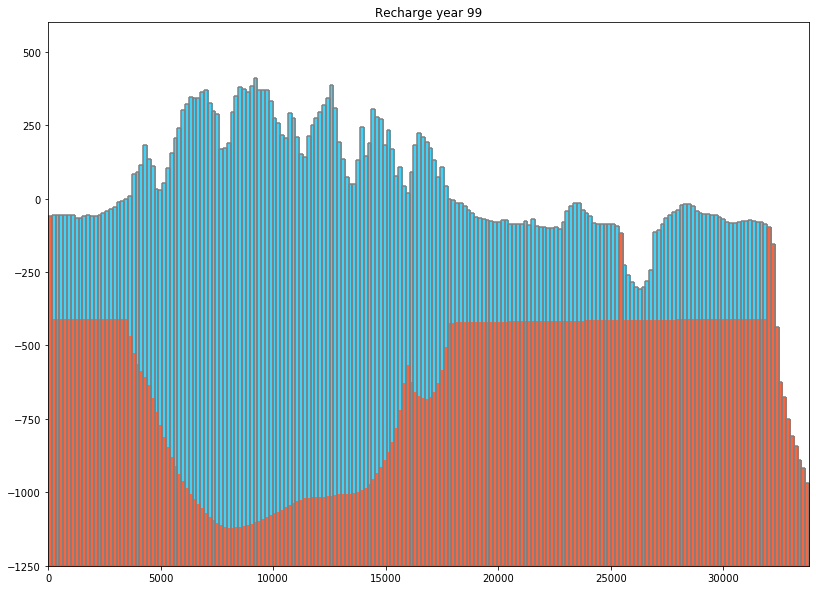

In [192]:
fig = plt.figure(figsize=(30, 10))
colors = ['#40d3f7', '#F76541']

ax = fig.add_subplot(1, 2, 1)
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Row': slicerow}, extent=(0, (delr*ncol), -1250, 600))
modelxsect.plot_fill_between(zeta[-1, :, :, :], colors=colors, ax=ax, edgecolors='none')
linecollection = modelxsect.plot_grid(ax=ax)
ax.set_title('Recharge year {}'.format(years[4]));

# Optimization Function

In [36]:
def calibrateo(params):
    Taf_HK, Leo_HK, Pyro_HK, OVtap_HK, OVpag_HK, Malaeimi_HK = params   
    
#    Taf_HK = 1000;    Leo_HK = 500;  Pyro_HK = 200;   OVtap_HK = .1;  OVpag_HK = .1
    Ocean_HK_Val  = 1000

    # path to the location of shapefiles
    HK_Zone_path = os.path.join(GIS_files, "Simple_2")

    # Rasterize the desired zones
    Leone = rastah_zone(os.path.join(HK_Zone_path, 'Leone.shp'))
    Tafuna = rastah_zone(os.path.join(HK_Zone_path, 'tafuna.shp'))
    Pyro = rastah_zone(os.path.join(HK_Zone_path, 'pyro.shp'))
    OldV_tapu = rastah_zone(os.path.join(HK_Zone_path, 'OldV_tapu.shp'))
    OldV_Pago = rastah_zone(os.path.join(HK_Zone_path, 'OldV_Pago.shp'))
    Malaeimi = rastah_zone(os.path.join(HK_Zone_path, 'Malaeimi.shp'))

    HK_raster  = Leone + Tafuna + Pyro + OldV_tapu + OldV_Pago + Malaeimi  # merge all zones together   
    
    
    # replace codes with actual HK values 
    HK_raster = np.where(HK_raster== -10, Taf_HK, HK_raster) 
    HK_raster = np.where(HK_raster== -20, Leo_HK, HK_raster)
    HK_raster = np.where(HK_raster== -30, Pyro_HK, HK_raster)
    HK_raster = np.where(HK_raster== -60, OVtap_HK, HK_raster)
    HK_raster = np.where(HK_raster== -80, OVpag_HK, HK_raster)
    HK_raster = np.where(HK_raster== -40, Malaeimi_HK, HK_raster)

    HK_raster = np.where(HK_raster== 0, Ocean_HK_Val, HK_raster)   # this is for the areas not covered by HK zones, 

    HK_raster = np.where(HK_raster== -90, 1, HK_raster) # this is for the areas that get messed up somehow
    
    
    # create new FloPy instance of the model ( but using the variables from above)
    
    modelname = 'modelface_OPT'

    ml_OPT = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)
    
    # steady state model run times
    nper = 1                     # Number of model stress periods (the default is 1)
    perlen = [3650]              # An array of the stress period lengths in days separated by commas
    nstp = [1]      # Number of time steps in each stress period (default is 1).
    save_head = [3650]
    steady = True


    discret = flopy.modflow.ModflowDis(ml_OPT, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                       delr=delr, delc=delc, top=top, botm=botm,
                                       nper=nper, perlen=perlen, nstp=nstp, tsmult=tsmult)
    bas = flopy.modflow.ModflowBas(ml_OPT, ibound=final_ibound, strt=ihead)
    lpf = flopy.modflow.ModflowLpf(ml_OPT, laytyp=laytyp, hk=HK_raster, vka=vka)
    rch = flopy.modflow.ModflowRch(ml_OPT, rech=rch_data)
    oc = flopy.modflow.ModflowOc(ml_OPT, stress_period_data=spd)
    pcg = flopy.modflow.ModflowPcg(ml_OPT, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)
    ghb = flopy.modflow.ModflowGhb(ml_OPT, stress_period_data=ghb_data)
    
    # water level observations
    obs_data= []
    for i in range(0,nobs):
        obs = flopy.modflow.HeadObservation(ml_OPT, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
        obs_data.append(obs)
    hob = flopy.modflow.ModflowHob(ml_OPT, iuhobsv = 7, hobdry=-999, obs_data = obs_data)

    # Run da model 

    ml_OPT.write_input()
    ml_OPT.run_model(silent=True)


    # post process observations 
    observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
    comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
    obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

    # note positive residuals means model is calculating too high negative is model calculates too low 
    residuals = []
    for idx, i in enumerate(observations):   
        r = observations[idx][0]-observations[idx][1]
        residuals.append(r)

    Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})
    # error metrics
    me = np.mean(Howd_we_do.Residual_m)
    mea = np.mean(np.abs(Howd_we_do.Residual_m))
    rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
    
#############  Plot the OBS plot if want This can be moved down to utilities when not in use
    fig = plt.figure(figsize=(4,4))
    plt.title('Observed. vs Simulated.')
    plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
    #plt.axis('equal')
    #plt.axis('square')
    plt.xlabel("Obs. head [m]")
    plt.ylabel('Sim. head [m]')
    plt.ylim(0,30)
    plt.xlim(0,30)
    plt.plot([0,20,30],[0,20,30], color= "grey")
    plt.tight_layout()
    plt.savefig("cal.pdf")
    plt.show()
############    

    print("Error is - {}".format(rmse))
    print("Params are - {}".format(params))
    return rmse

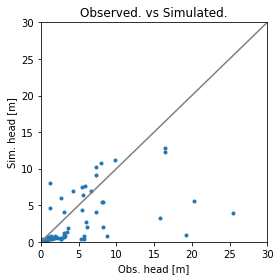

Error is - 9.946680609525352
Params are - [100.  100.   10.    0.5   0.5   0.5]


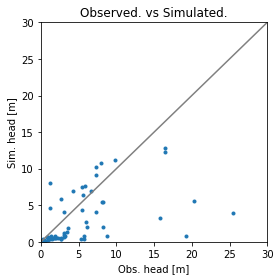

Error is - 9.954943681545847
Params are - [105.  100.   10.    0.5   0.5   0.5]


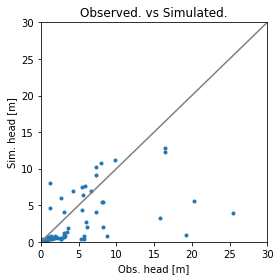

Error is - 9.947055335778
Params are - [100.  105.   10.    0.5   0.5   0.5]


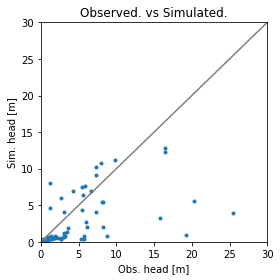

Error is - 9.947233134427755
Params are - [100.  100.   10.5   0.5   0.5   0.5]


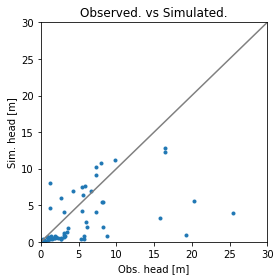

Error is - 9.948956089846178
Params are - [100.    100.     10.      0.525   0.5     0.5  ]


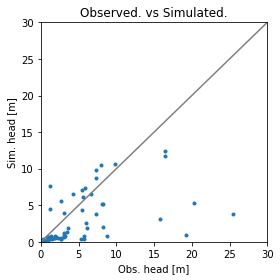

Error is - 10.019773847757477
Params are - [100.    100.     10.      0.5     0.525   0.5  ]


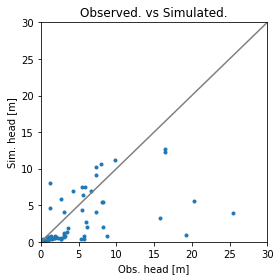

Error is - 9.952510914582176
Params are - [100.    100.     10.      0.5     0.5     0.525]


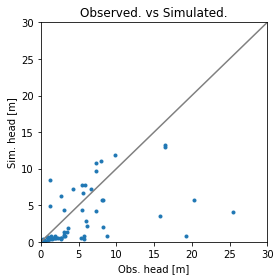

Error is - 9.876886391365954
Params are - [101.66666667 101.66666667  10.16666667   0.50833333   0.475
   0.50833333]


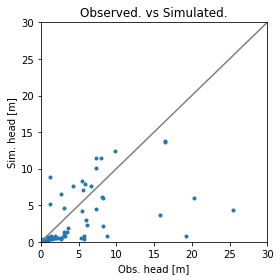

Error is - 9.802061758739812
Params are - [102.5    102.5     10.25     0.5125   0.45     0.5125]


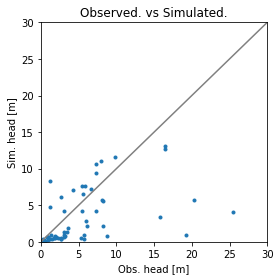

Error is - 9.893610400230973
Params are - [ 95.83333333 102.5         10.25         0.5125       0.48333333
   0.5125    ]


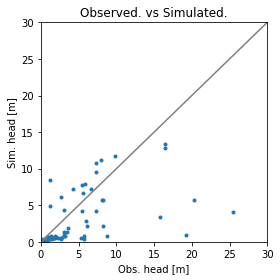

Error is - 9.876703126204372
Params are - [ 99.44444444 103.33333333  10.33333333   0.51666667   0.47777778
   0.48333333]


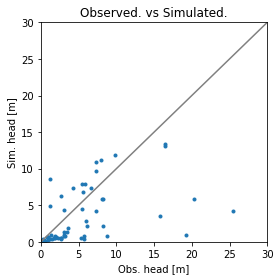

Error is - 9.855920323384147
Params are - [ 99.25925926 104.44444444  10.44444444   0.48888889   0.47037037
   0.50277778]


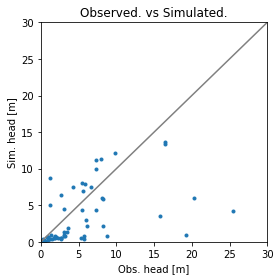

Error is - 9.826562230058956
Params are - [ 99.01234568 105.92592593   9.92592593   0.51018519   0.46049383
   0.5037037 ]


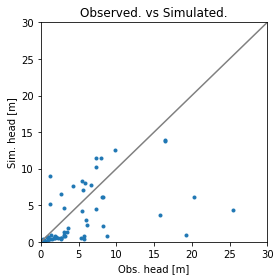

Error is - 9.785536356770644
Params are - [ 98.68312757 101.2345679   10.40123457   0.51358025   0.4473251
   0.50493827]


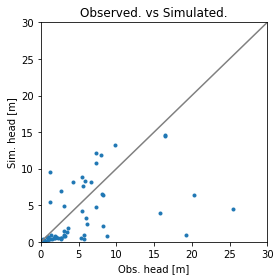

Error is - 9.7025096109427
Params are - [98.02469136 99.35185185 10.60185185  0.52037037  0.42098765  0.50740741]


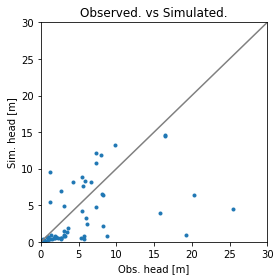

Error is - 9.703031333246338
Params are - [ 98.02469136 106.01851852  10.60185185   0.52037037   0.42098765
   0.50740741]


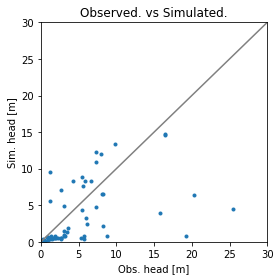

Error is - 9.693848621948687
Params are - [102.9218107  104.69135802  10.4691358    0.51049383   0.41687243
   0.49320988]


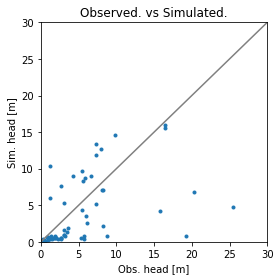

Error is - 9.594363001895458
Params are - [106.46604938 105.78703704  10.5787037    0.50949074   0.38364198
   0.48356481]


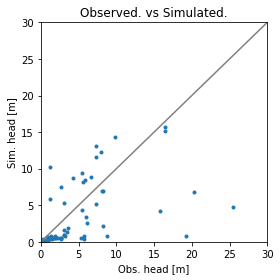

Error is - 9.61762592455316
Params are - [101.65123457 104.67592593  10.46759259   0.50393519   0.39104938
   0.5224537 ]


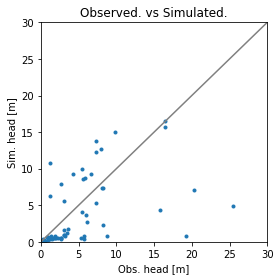

Error is - 9.562048304356406
Params are - [102.63374486 103.64197531  10.36419753   0.5367284    0.37201646
   0.5095679 ]


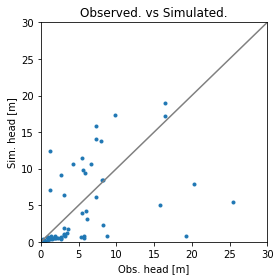

Error is - 9.44608269440011
Params are - [104.32098765 103.24074074  10.32407407   0.56064815   0.32283951
   0.51296296]


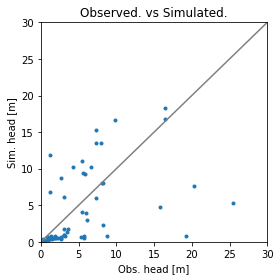

Error is - 9.471564925117653
Params are - [104.65020576 101.2654321   11.0154321    0.53225309   0.33600823
   0.5117284 ]


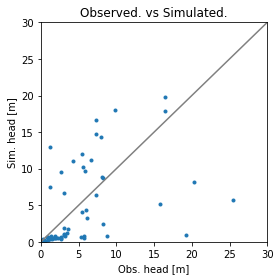

Error is - 9.416988606121977
Params are - [101.87928669 104.27983539  10.94650206   0.53652263   0.3085048
   0.5026749 ]


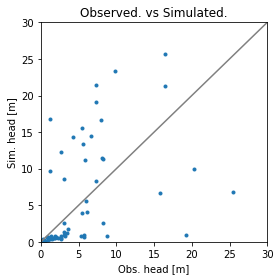

Error is - 9.544023457270574
Params are - [101.56893004 105.16975309  11.29475309   0.54853395   0.2377572
   0.49776235]


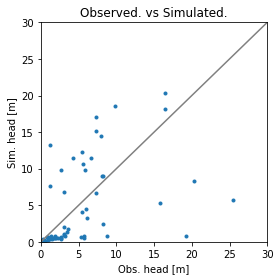

Error is - 9.417336546333622
Params are - [107.63946045 100.18175583  10.70953361   0.53403635   0.30002286
   0.50618999]


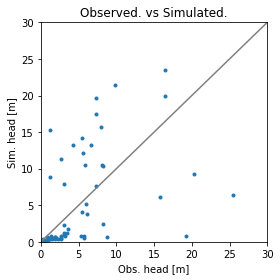

Error is - 9.45593152565431
Params are - [110.84438348 107.12505716  10.74542753   0.53859168   0.25970127
   0.50578418]


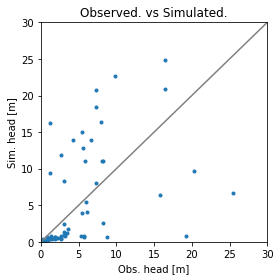

Error is - 9.50818096787716
Params are - [110.28222324 102.61736016  10.97229843   0.56657903   0.24585683
   0.48518137]


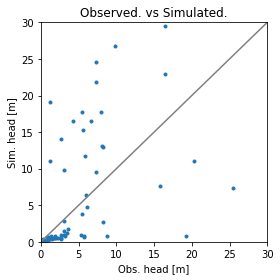

Error is - 9.869118087144441
Params are - [106.73946638 100.44969009  10.99238556   0.5800529    0.20733586
   0.52460912]


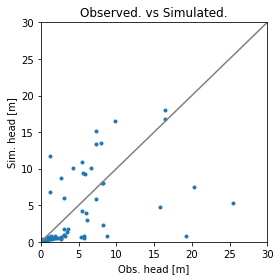

Error is - 9.478088487132256
Params are - [106.53440363 104.4527003   10.68212417   0.52713128   0.33956545
   0.49382589]


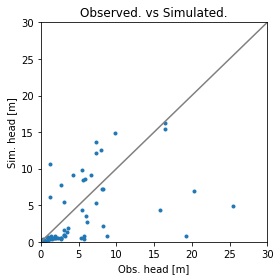

Error is - 9.574800415202253
Params are - [101.67401932 104.23114701  10.50206608   0.50981537   0.37635721
   0.52587406]


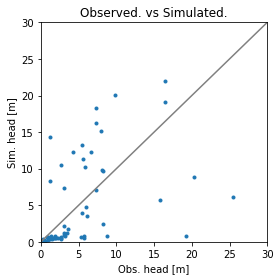

Error is - 9.417289097308364
Params are - [108.13017226 103.02080687  10.85474034   0.55238811   0.27848192
   0.49535455]


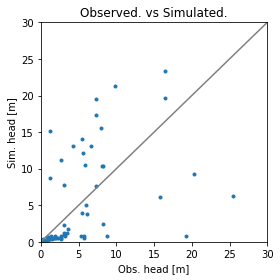

Error is - 9.444935003119191
Params are - [105.9537618  101.91850906  10.84977907   0.55768206   0.26228742
   0.5177391 ]


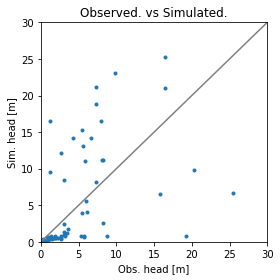

Error is - 9.53189333325626
Params are - [108.27247835 105.32346959  10.46125346   0.56103657   0.24127103
   0.50184016]


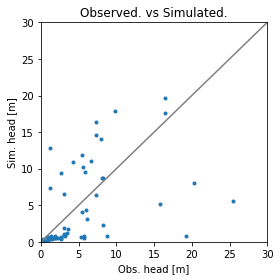

Error is - 9.429004874172826
Params are - [105.55577391 102.27994147  10.87688744   0.53944896   0.31232393
   0.50925634]


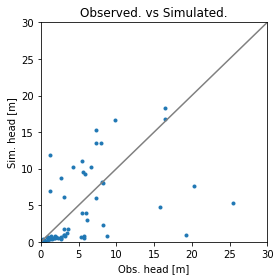

Error is - 9.463281479838631
Params are - [100.31543078  97.84880597  10.775078     0.55498374   0.33511888
   0.50894176]


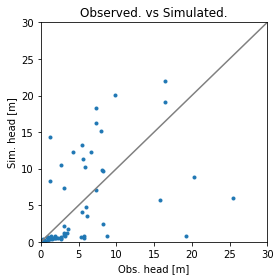

Error is - 9.4187270170987
Params are - [108.2121453  104.80599436  10.75284015   0.54268969   0.27855567
   0.50657358]


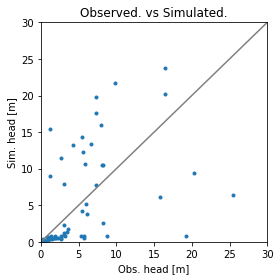

Error is - 9.458493536054476
Params are - [108.13587915 102.25487359  11.33935348   0.52694112   0.25721936
   0.49963318]


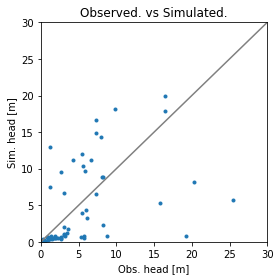

Error is - 9.421976077843498
Params are - [105.27471053 102.99427395  10.57789393   0.55222139   0.30643447
   0.50963052]


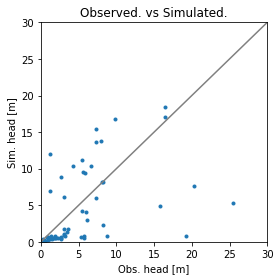

Error is - 9.461611264633973
Params are - [106.27675458 103.93569356  10.72302011   0.52808699   0.33248713
   0.49215419]


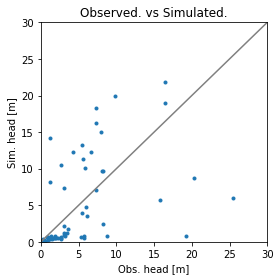

Error is - 9.415883472127984
Params are - [106.03451    102.42280519  10.81808933   0.55028329   0.27983735
   0.51134287]


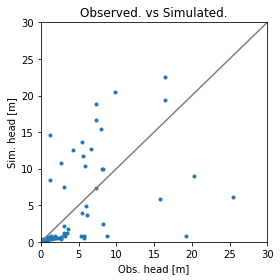

Error is - 9.424218775325157
Params are - [106.83432117 103.62188239  10.67631236   0.54993153   0.27162176
   0.50133246]


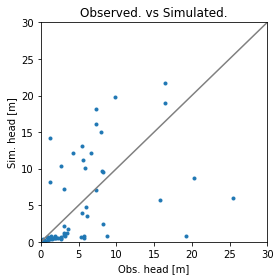

Error is - 9.413691067094645
Params are - [106.51468435 103.28639716  10.72645613   0.54731089   0.2817973
   0.50331343]


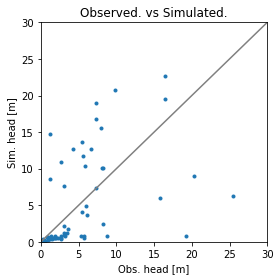

Error is - 9.427918947164025
Params are - [107.52870916 103.00492431  11.02482661   0.53552227   0.26929883
   0.49885258]


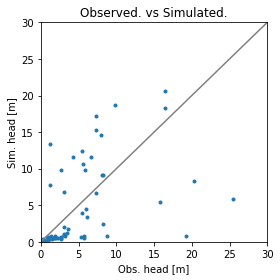

Error is - 9.41413289925747
Params are - [105.83821018 102.99693654  10.6896271    0.54804661   0.29715056
   0.50693603]


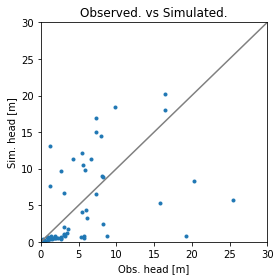

Error is - 9.41470237519429
Params are - [103.79996267 100.59018464  10.82880938   0.5468396    0.30337593
   0.50203035]


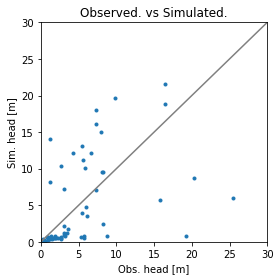

Error is - 9.408753987467131
Params are - [103.09281494 105.3505661   10.9118745    0.55976069   0.28302643
   0.50102739]


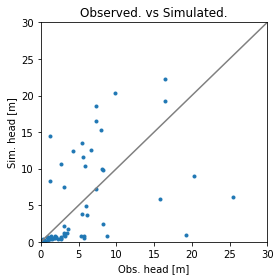

Error is - 9.41288861303589
Params are - [100.81949218 107.93497124  11.01304495   0.57262287   0.27452821
   0.49844609]


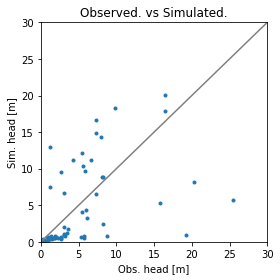

Error is - 9.415231431893096
Params are - [100.92298402 103.28810147  10.78571249   0.54386646   0.3060822
   0.51375378]


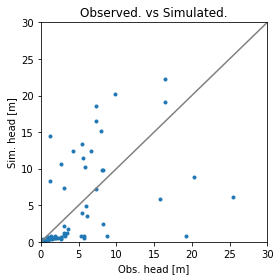

Error is - 9.421598655477132
Params are - [106.85510203 101.69849498  10.64035425   0.56217988   0.27525179
   0.51012639]


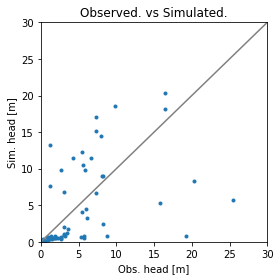

Error is - 9.411440980243114
Params are - [103.12324053 103.63450029  10.86996511   0.54293695   0.30019155
   0.50453777]


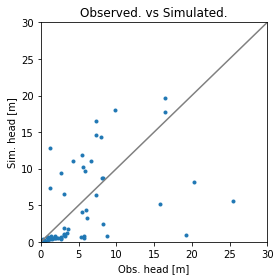

Error is - 9.419319970960895
Params are - [101.72945557 103.95942355  10.78605891   0.54597044   0.31070398
   0.49919004]


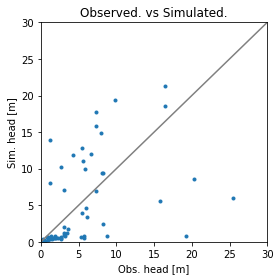

Error is - 9.410736461140615
Params are - [104.95824639 102.80695978  10.81008172   0.54920508   0.287554
   0.50830466]


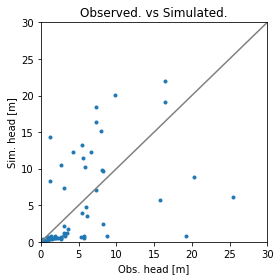

Error is - 9.417552398594127
Params are - [108.186069   102.9337467   10.82655882   0.55416681   0.27828306
   0.49496277]


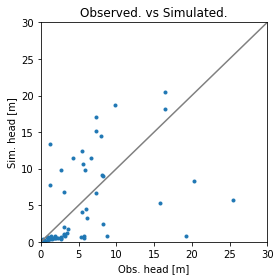

Error is - 9.411109644008643
Params are - [102.73875527 103.19951278  10.79592407   0.54644155   0.29913241
   0.50905602]


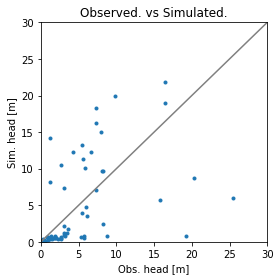

Error is - 9.41438632552556
Params are - [104.95535454 106.50143958  10.77250017   0.55106099   0.27957482
   0.50902809]


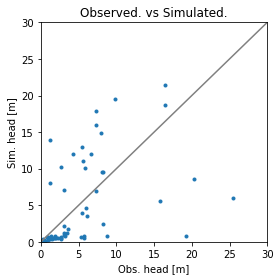

Error is - 9.4106254127083
Params are - [104.66650658 105.02362584  10.78657747   0.55000564   0.2855251
   0.50727865]


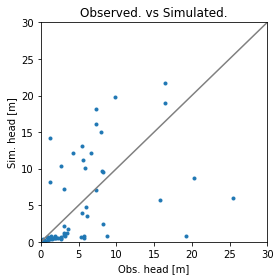

Error is - 9.408372264009238
Params are - [102.52653917 104.77025077  10.94399924   0.55050699   0.28192504
   0.50423661]


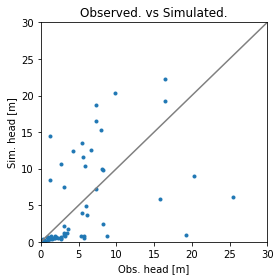

Error is - 9.41253081947394
Params are - [100.87070366 105.65690789  11.07118531   0.55173718   0.27431228
   0.5028869 ]


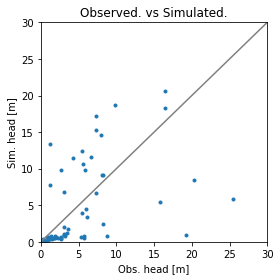

Error is - 9.406979046531161
Params are - [100.52068327 104.97540802  10.97968457   0.55230808   0.29732087
   0.50816694]


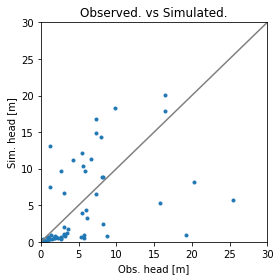

Error is - 9.409202614633486
Params are - [ 97.52368273 105.81991345  11.10629879   0.55480667   0.30508266
   0.5105937 ]


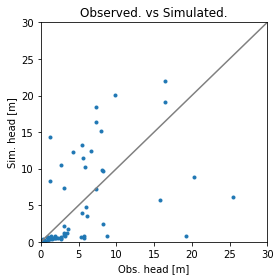

Error is - 9.413224843641963
Params are - [103.04460801 105.07427414  10.87274875   0.55980573   0.27796974
   0.50815232]


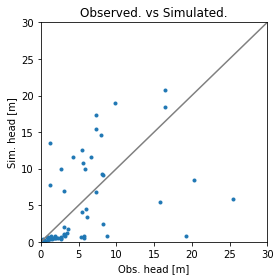

Error is - 9.408627480477719
Params are - [103.1035824  103.99444375  10.87066102   0.54715414   0.2946361
   0.50544141]


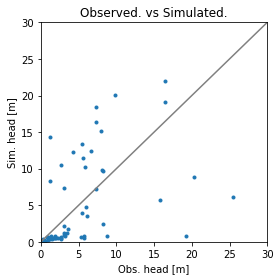

Error is - 9.413313785950718
Params are - [103.55070231 105.77423865  10.9717021    0.55653866   0.2775301
   0.5024292 ]


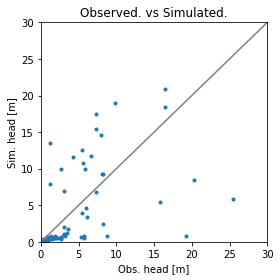

Error is - 9.408490600168657
Params are - [102.94174203 103.84319424  10.83986858   0.54896583   0.29373183
   0.50739932]


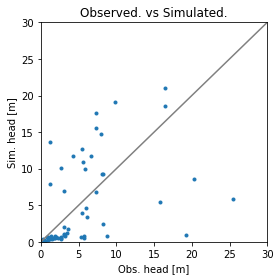

Error is - 9.404001531061535
Params are - [100.65904307 106.51220314  10.9674734    0.55369538   0.29116778
   0.50287878]


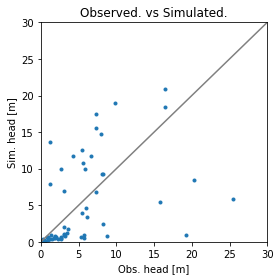

Error is - 9.400786502354524
Params are - [ 98.50944141 108.36482481  11.04616925   0.55594053   0.29297467
   0.50016583]


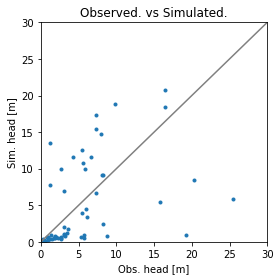

Error is - 9.402479259164094
Params are - [ 98.89842783 105.40927006  11.07750825   0.55487311   0.29567988
   0.50153384]


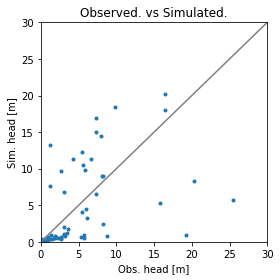

Error is - 9.407721464770367
Params are - [ 99.07399043 105.10189779  11.00742246   0.54348886   0.30239637
   0.50795393]


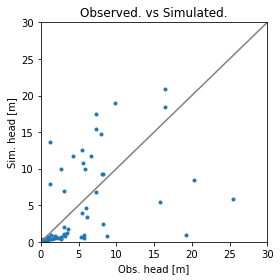

Error is - 9.400249826534338
Params are - [ 97.72002564 106.82717148  11.0942231    0.55487366   0.29337346
   0.50437741]


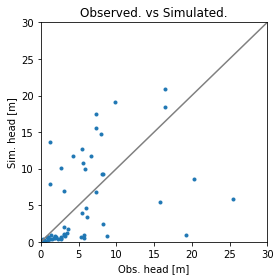

Error is - 9.395812249073087
Params are - [ 95.02824727 108.24353535  11.20600414   0.55873341   0.29274215
   0.50384542]


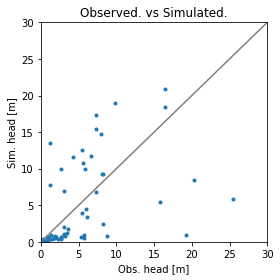

Error is - 9.395977960020199
Params are - [ 95.24403443 108.44520136  11.24706072   0.55631783   0.29394783
   0.50123487]


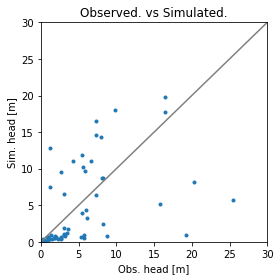

Error is - 9.406022858896149
Params are - [ 93.23173571 108.74312836  11.24395056   0.55671362   0.30976222
   0.503397  ]


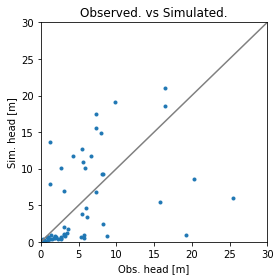

Error is - 9.39480392644989
Params are - [ 94.73686621 109.62522487  11.25937003   0.56814      0.29174617
   0.49816071]


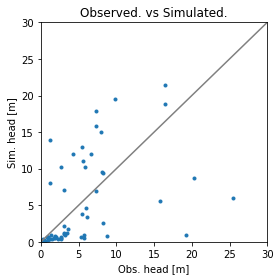

Error is - 9.391096334447928
Params are - [ 92.5683041  111.88688841  11.38534382   0.58046556   0.28642107
   0.4932641 ]


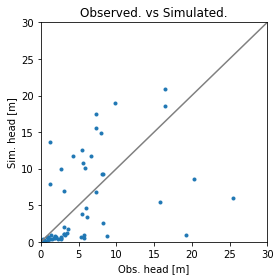

Error is - 9.387106008312902
Params are - [ 90.63938031 112.05554142  11.42232767   0.56870661   0.2931884
   0.49298008]


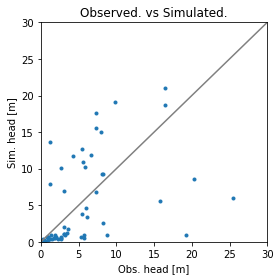

Error is - 9.37657855099687
Params are - [ 85.69872883 115.59560812  11.64364922   0.57690588   0.29112216
   0.48538665]


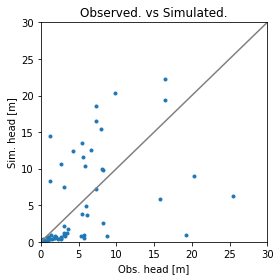

Error is - 9.40330639254412
Params are - [ 95.41732558 110.57198101  11.29129457   0.57103182   0.2745337
   0.49174657]


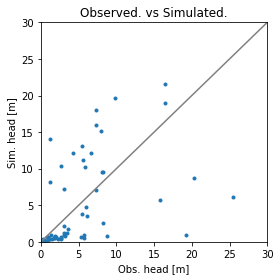

Error is - 9.395305370588517
Params are - [ 94.87092811 110.11476785  11.27945857   0.56745227   0.28334083
   0.49465918]


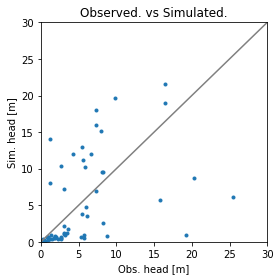

Error is - 9.383616771139721
Params are - [ 88.40813356 115.47433857  11.52505366   0.57706539   0.28450302
   0.49131817]


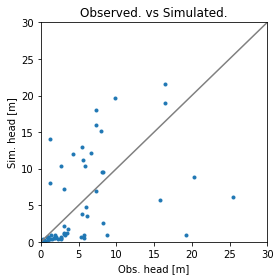

Error is - 9.377986574000555
Params are - [ 85.43001735 114.88862174  11.71602079   0.58303959   0.28438434
   0.48973697]


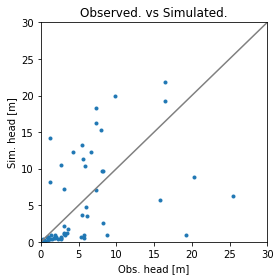

Error is - 9.38007539156792
Params are - [ 85.42408531 116.95605199  11.67144934   0.59156953   0.28022336
   0.48483529]


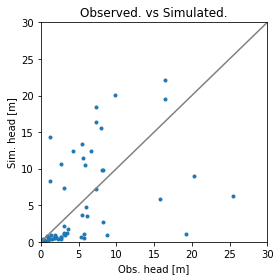

Error is - 9.375955776986423
Params are - [ 82.43848515 120.06189021  11.86765433   0.60009933   0.27725612
   0.47588803]


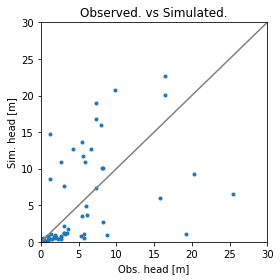

Error is - 9.372701401300287
Params are - [ 76.1436041  125.97106764  12.19847942   0.62078229   0.2695131
   0.46190934]


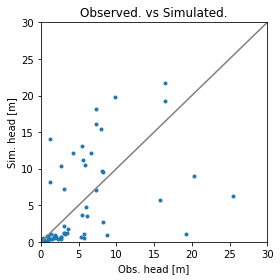

Error is - 9.358951234617484
Params are - [ 76.35336297 123.47609097  12.10054018   0.60915714   0.28204819
   0.47415766]


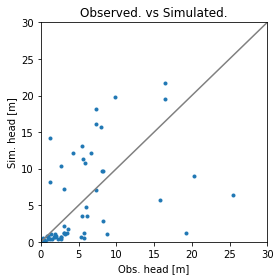

Error is - 9.335220333871117
Params are - [ 67.09458041 130.15675254  12.51108099   0.63000958   0.28140187
   0.46390691]


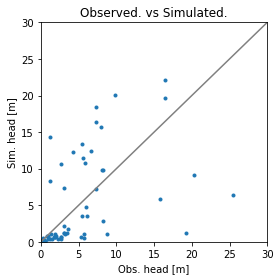

Error is - 9.346432726703483
Params are - [ 70.16474575 127.79392513  12.36990066   0.61265852   0.27729489
   0.46576701]


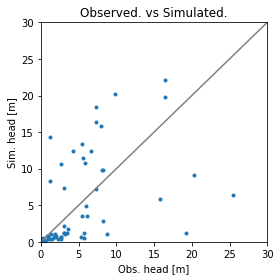

Error is - 9.341831997881242
Params are - [ 68.24378703 128.31300381  12.51180649   0.62792308   0.27681022
   0.45919588]


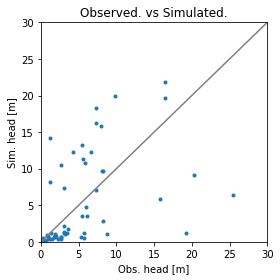

Error is - 9.33054341965133
Params are - [ 65.50106918 130.61694101  12.64552985   0.62553678   0.27995217
   0.4571323 ]


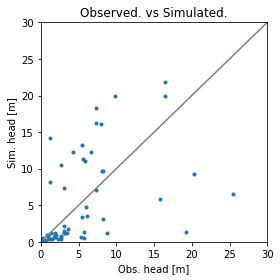

Error is - 9.296745322002637
Params are - [ 55.53956111 137.44738551  13.1325701    0.6425204    0.27981657
   0.4432808 ]


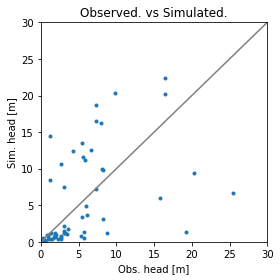

Error is - 9.303285747845704
Params are - [ 55.53165172 140.20395918  13.0731415    0.65389366   0.27426859
   0.43674523]


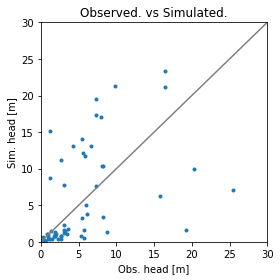

Error is - 9.287188741532066
Params are - [ 45.20724787 147.69975648  13.6220105    0.68568996   0.26191292
   0.42488174]


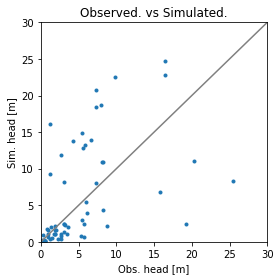

Error is - 9.208568516887274
Params are - [ 24.96150739 163.75183066  14.61119114   0.740082     0.2473083
   0.39462928]


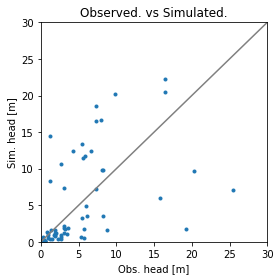

Error is - 9.21297712121591
Params are - [ 37.7016737  149.91788464  13.87141754   0.68158012   0.27612038
   0.42593236]


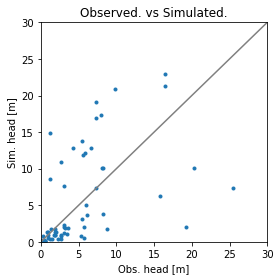

Error is - 9.195886433437416
Params are - [ 32.85950803 155.46968032  14.20050192   0.71267775   0.26794709
   0.40879648]


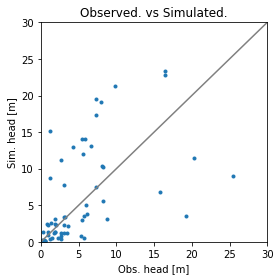

Error is - 8.980028637463437
Params are - [ 14.20688918 169.30755791  15.11580256   0.76268737   0.26327319
   0.38031121]


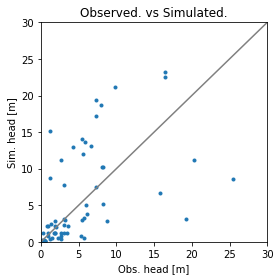

Error is - 9.02393113425987
Params are - [ 16.76816747 168.615453    14.92659479   0.74233463   0.26391941
   0.38907272]


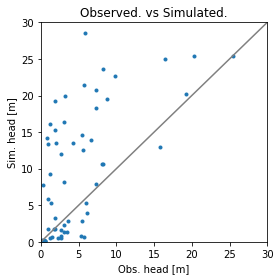

Error is - 10.372608372445976
Params are - [  1.14190312 179.5912711   15.73249155   0.77768981   0.25350027
   0.35941696]


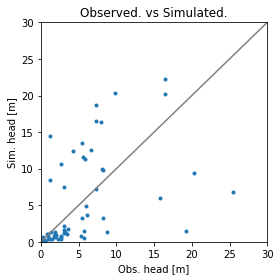

Error is - 9.28416297507229
Params are - [ 50.60641108 142.51538218  13.31643363   0.66692963   0.27442647
   0.43778442]


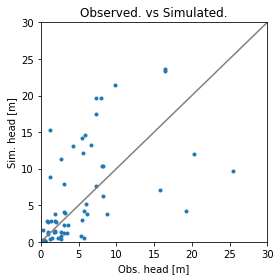

Error is - 8.913506177531941
Params are - [ 11.06308493 170.31453879  15.25152842   0.75815106   0.26068618
   0.38692503]


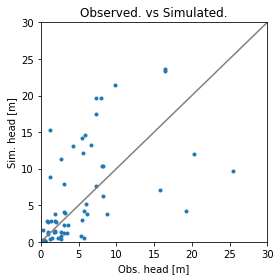

Error is - 8.913506177531941
Params are - [-11.17119847 185.36982859  16.34072187   0.81027976   0.25389497
   0.36201493]


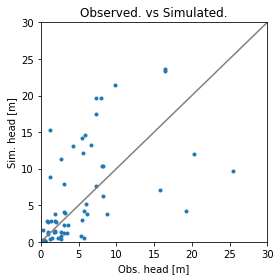

Error is - 8.913506177531941
Params are - [ -3.77031652 184.02683021  15.89841925   0.80806787   0.24876141
   0.36160421]


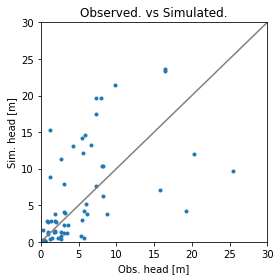

Error is - 8.913506177531941
Params are - [-16.96274237 192.79598289  16.5752176    0.83070471   0.24559648
   0.34170719]


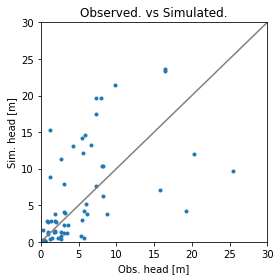

Error is - 8.913506177531941
Params are - [-22.27947701 199.68617985  16.92150038   0.86576243   0.23372794
   0.32548418]


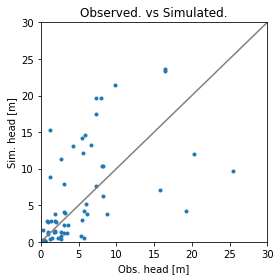

Error is - 8.913506177531941
Params are - [-25.2863055  197.83035023  16.95182986   0.84915403   0.25801324
   0.33373889]


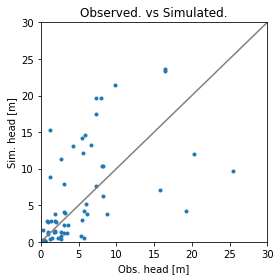

Error is - 8.913506177531941
Params are - [-31.11112324 202.70502696  17.31150457   0.88250786   0.2394334
   0.32085086]


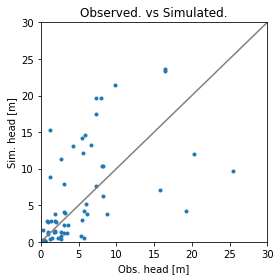

Error is - 8.913506177531941
Params are - [-43.65584908 213.14541173  17.85419747   0.90209528   0.23213303
   0.30979224]


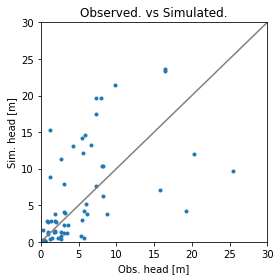

Error is - 8.913506177531941
Params are - [-29.19016452 202.18594828  17.16959874   0.8672433    0.23991807
   0.32742198]


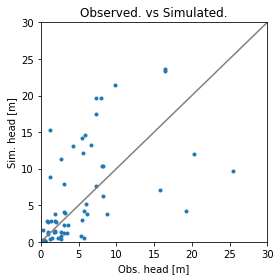

Error is - 8.913506177531941
Params are - [ -0.25879539 180.26702137  15.80040128   0.79753935   0.25548815
   0.36268147]


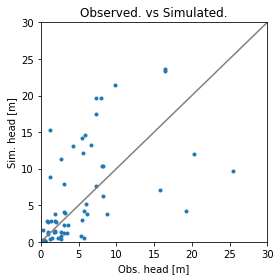

Error is - 8.913506177531941
Params are - [-21.95732223 196.70621655  16.82729937   0.84981732   0.24381059
   0.33623686]


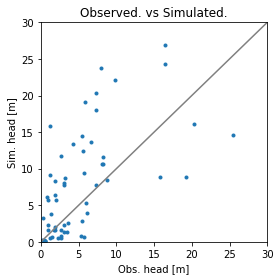

Error is - 8.75873108402572
Params are - [  3.6463842  177.1706845   15.57497383   0.78310947   0.25472379
   0.37426462]


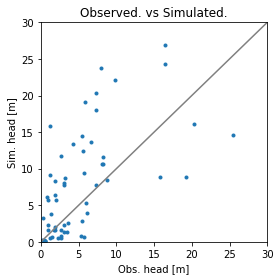

Error is - 8.75873108402572
Params are - [ -2.94982872 181.55526084  15.91337301   0.79442789   0.25314133
   0.36431611]


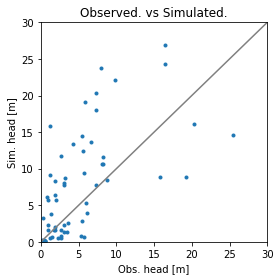

Error is - 8.75873108402572
Params are - [ -5.60819604 185.00035932  16.0865144    0.81195674   0.24720706
   0.35620461]


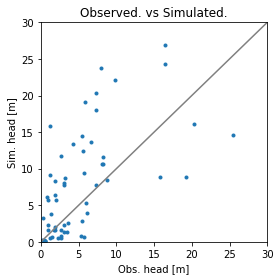

Error is - 8.75873108402572
Params are - [ -7.11161029 184.07244451  16.10167914   0.80365254   0.25934971
   0.36033196]


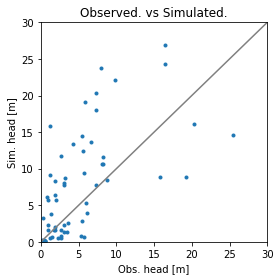

Error is - 8.75873108402572
Params are - [-10.02401916 186.50978287  16.28151649   0.82032946   0.25005979
   0.35388794]


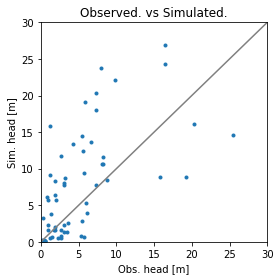

Error is - 8.75873108402572
Params are - [ -9.06353979 186.25024353  16.21056358   0.81269718   0.25030212
   0.35717351]


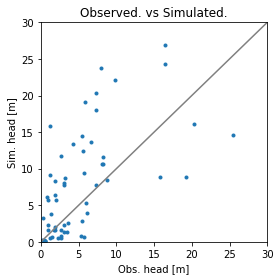

Error is - 8.75873108402572
Params are - [-21.43335486 196.5383864   16.8046784    0.85057337   0.24424176
   0.33513455]


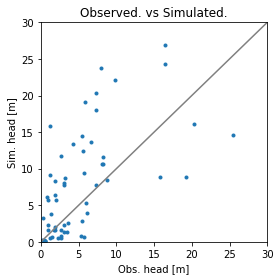

Error is - 8.75873108402572
Params are - [-13.30924491 189.9824245   16.4163909    0.82746779   0.24835286
   0.34808217]


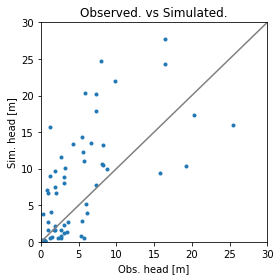

Error is - 8.800489669304564
Params are - [  2.93897498 176.87050069  15.63981591   0.78125664   0.25657507
   0.37397741]


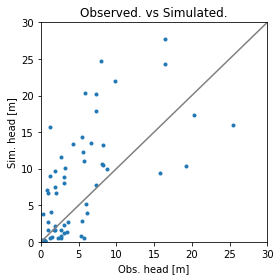

Error is - 8.800489669304564
Params are - [ -9.24718994 186.70444355  16.22224715   0.815915     0.25040841
   0.35455598]


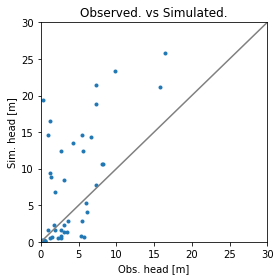

Error is - 18.21524950006188
Params are - [  0.34827774 179.36297267  15.74417342   0.78876868   0.25393256
   0.36929036]


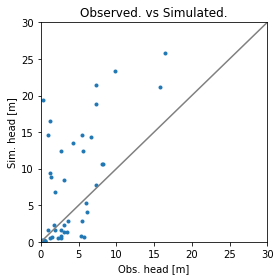

Error is - 18.21524950006188
Params are - [ -0.98090592 181.08552191  15.83074412   0.7975331    0.25096543
   0.36523461]


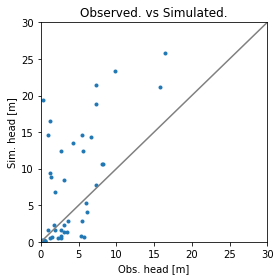

Error is - 18.21524950006188
Params are - [ -1.73261304 180.6215645   15.83832649   0.793381     0.25703675
   0.36729829]


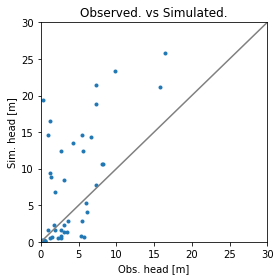

Error is - 18.21524950006188
Params are - [ -3.18881748 181.84023369  15.92824516   0.80171946   0.25239179
   0.36407628]


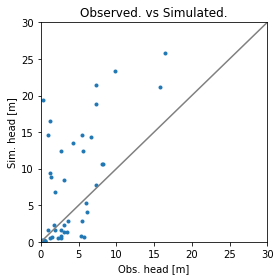

Error is - 18.21524950006188
Params are - [ -2.7085778  181.71046402  15.89276871   0.79790332   0.25251296
   0.36571906]


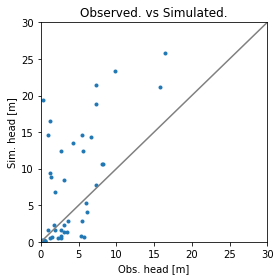

Error is - 18.21524950006188
Params are - [ -4.83143035 183.5765545   15.99568237   0.80528863   0.25153833
   0.3611734 ]


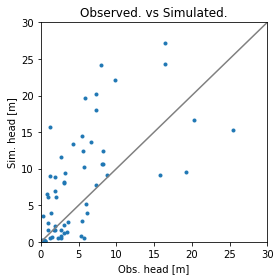

Error is - 8.770922723604262
Params are - [  3.29267959 177.0205926   15.60739487   0.78218305   0.25564943
   0.37412102]


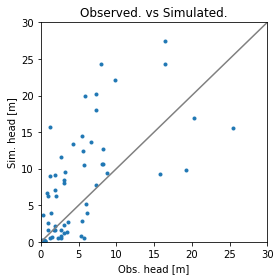

Error is - 8.781443164161667
Params are - [  3.17024616 177.32339261  15.61518392   0.78432826   0.25572029
   0.372376  ]


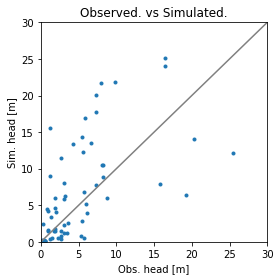

Error is - 8.766910889986974
Params are - [  5.77017372 175.68800924  15.47535372   0.77471506   0.25695096
   0.37678535]


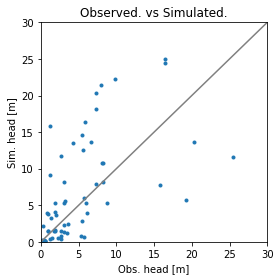

Error is - 8.83021950181104
Params are - [  6.81489821 175.26216     15.44428148   0.77683154   0.2522774
   0.3767257 ]


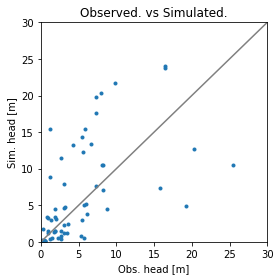

Error is - 8.852365591183736
Params are - [  8.66179246 172.85708196  15.32304297   0.76577891   0.25878606
   0.38261974]


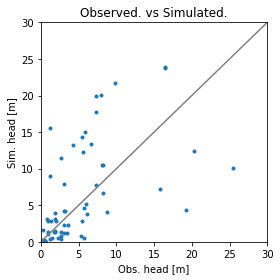

Error is - 8.903001287304134
Params are - [ 10.10378037 172.41100097  15.26923684   0.76688009   0.25743675
   0.38300711]


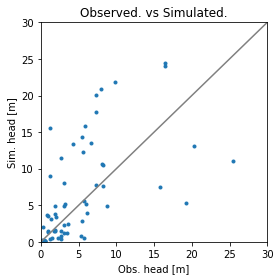

Error is - 8.832316237430975
Params are - [  7.66490472 174.14899389  15.38797099   0.77235223   0.2565607
   0.37957792]


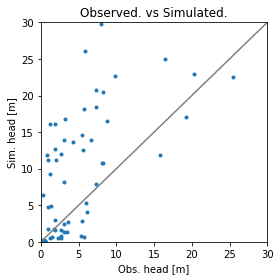

Error is - 9.698822182939006
Params are - [  1.45796974 179.34752898  15.71200997   0.79206096   0.25184147
   0.3686638 ]


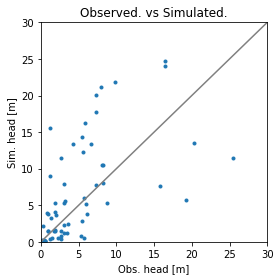

Error is - 8.802150559453526
Params are - [  6.86083678 174.47969372  15.42028472   0.77234942   0.25704991
   0.37913075]


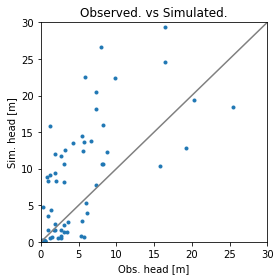

Error is - 9.022744615721157
Params are - [  2.18683484 178.16585033  15.65785319   0.7854867    0.25422989
   0.37155656]


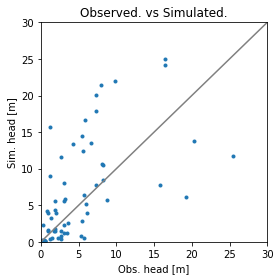

Error is - 8.789691133542698
Params are - [  6.29538725 175.153208    15.45544154   0.77563585   0.255978
   0.37757258]


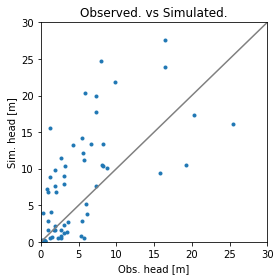

Error is - 8.786879302751327
Params are - [  2.86367103 177.01636688  15.60526273   0.78060883   0.25974673
   0.37469108]


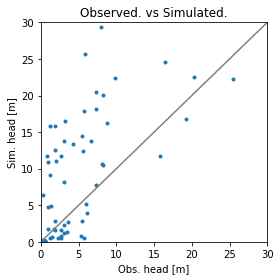

Error is - 9.608745571261094
Params are - [  1.48534387 178.64439089  15.69091882   0.78784408   0.25587316
   0.37080613]


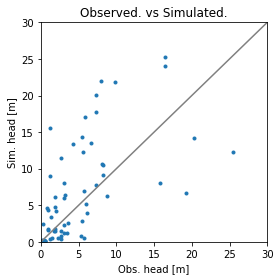

Error is - 8.760131596010815
Params are - [  5.51696355 175.52086801  15.48794324   0.77622309   0.25675572
   0.3770496 ]


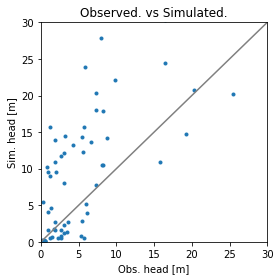

Error is - 9.245140916032264
Params are - [  1.79131884 178.09342994  15.6665959    0.7847534    0.25720431
   0.37218997]


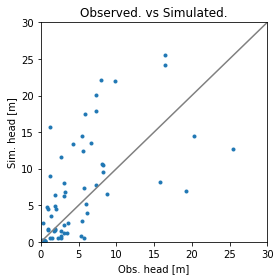

Error is - 8.753617546589922
Params are - [  5.16937015 175.88826349  15.50823013   0.77791524   0.25628458
   0.37622693]


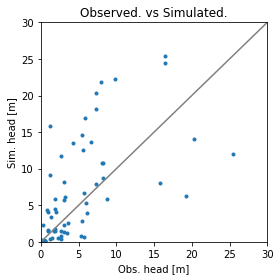

Error is - 8.803852556922124
Params are - [  5.99160143 175.8542366   15.48443052   0.77888255   0.25228153
   0.37558343]


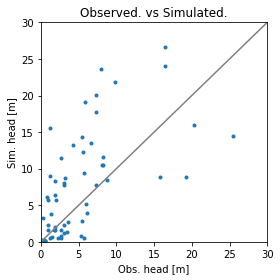

Error is - 8.735878500957844
Params are - [  3.64565363 176.72583431  15.57505467   0.78017726   0.25788043
   0.37491416]


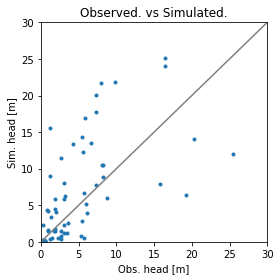

Error is - 8.767904226979178
Params are - [  5.84349545 175.34802478  15.4611329    0.77377946   0.25702801
   0.37874456]


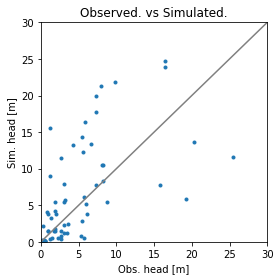

Error is - 8.78950494791099
Params are - [  6.57133398 175.09330218  15.42016796   0.77312347   0.2575584
   0.37854073]


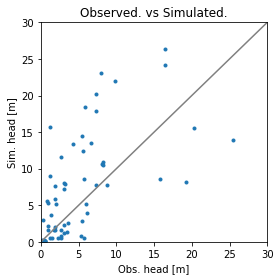

Error is - 8.739864464279554
Params are - [  4.11234319 176.53876999  15.56058814   0.77991816   0.25612667
   0.37522594]


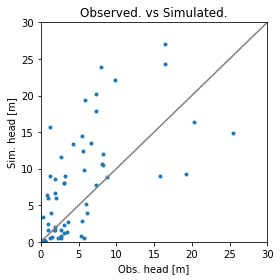

Error is - 8.76008724559085
Params are - [  3.44346736 177.16278507  15.59958168   0.7835733    0.25587937
   0.37274431]


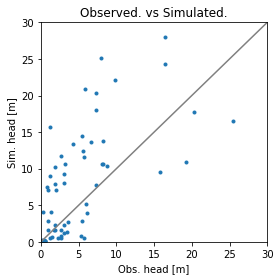

Error is - 8.840610408423629
Params are - [  2.7412203  177.31439255  15.62677018   0.78559045   0.25559923
   0.3733565 ]


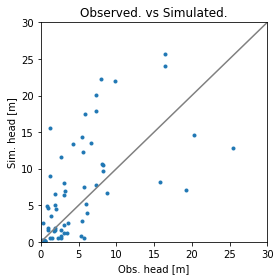

Error is - 8.747751841329242
Params are - [  5.01293537 176.09460507  15.51320784   0.77743391   0.25661303
   0.37592814]


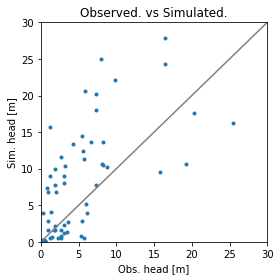

Error is - 8.82461572575107
Params are - [  2.82642108 177.67277947  15.62260219   0.78448602   0.2557469
   0.37271844]


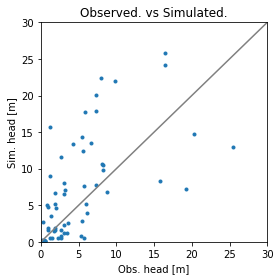

Error is - 8.74466006483838
Params are - [  4.84432793 176.05884588  15.52160798   0.77828882   0.25650352
   0.37596681]


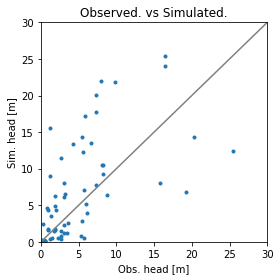

Error is - 8.754726192928185
Params are - [  5.36687079 175.66288267  15.48497252   0.77537432   0.2568313
   0.37809789]


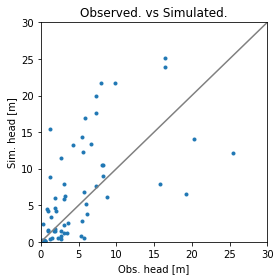

Error is - 8.75541563387228
Params are - [  5.73744948 175.15238264  15.47957993   0.77325977   0.25868938
   0.37785534]


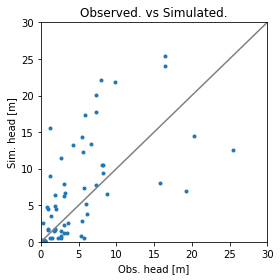

Error is - 8.745822429429529
Params are - [  5.21468316 175.6569581   15.5034284    0.77572219   0.25769798
   0.37695766]


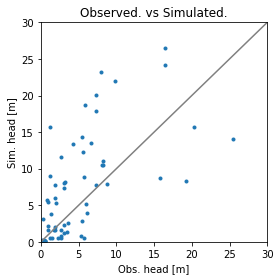

Error is - 8.736610894084595
Params are - [  3.96623368 176.65820961  15.57573321   0.78111087   0.25687077
   0.37364199]


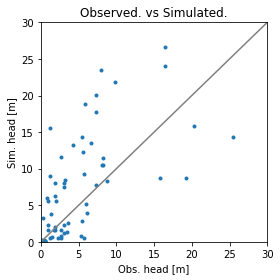

Error is - 8.734514682019375
Params are - [  3.76268884 176.6894775   15.57497662   0.77963517   0.25761289
   0.37465131]


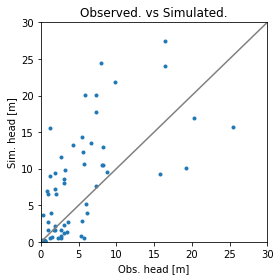

Error is - 8.772742730671816
Params are - [  3.05934819 177.0900845   15.60834986   0.78049513   0.25827704
   0.37386349]


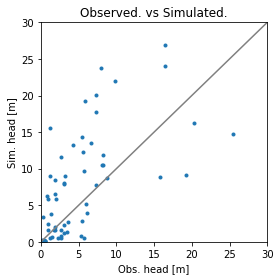

Error is - 8.74365015576647
Params are - [  3.50237478 176.68142673  15.59058851   0.78085025   0.25761773
   0.37452448]


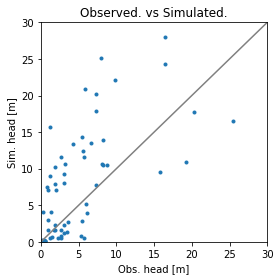

Error is - 8.835718945374358
Params are - [  2.72985752 177.46056323  15.62942131   0.78427132   0.25650602
   0.3726839 ]


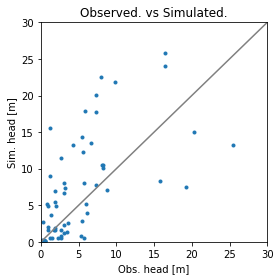

Error is - 8.734457194562752
Params are - [  4.59347675 176.10785939  15.53492663   0.77785947   0.25739999
   0.37588922]


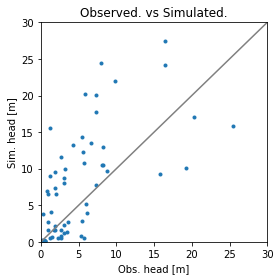

Error is - 8.779777916202452
Params are - [  3.01659569 177.0750133   15.61568128   0.78156158   0.25799931
   0.37364889]


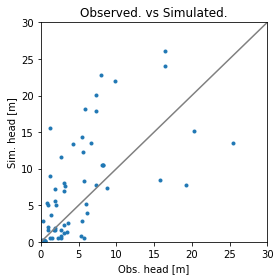

Error is - 8.735565759562874
Params are - [  4.38739487 176.31288773  15.5451263    0.77910701   0.25687747
   0.37538733]


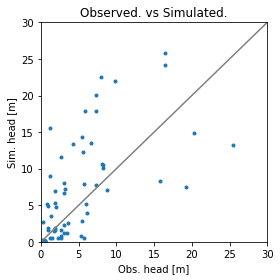

Error is - 8.740502425894839
Params are - [  4.65355554 176.32958612  15.53154669   0.77841906   0.25663835
   0.37537883]


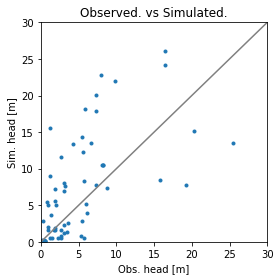

Error is - 8.73545487039131
Params are - [  4.36576035 176.41754627  15.54630714   0.77902686   0.25688319
   0.37516525]


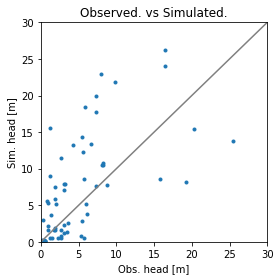

Error is - 8.725138497670867
Params are - [  4.12805952 176.43183494  15.55678671   0.77905406   0.25838157
   0.37465714]


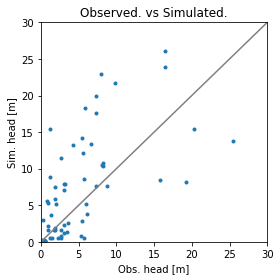

Error is - 8.718121278985489
Params are - [  4.13591769 176.37836742  15.554886     0.77862201   0.25950902
   0.37437274]


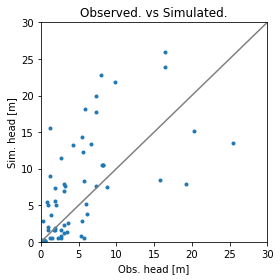

Error is - 8.724033623213076
Params are - [  4.33073036 176.2191146   15.53469258   0.77703172   0.25851689
   0.37648468]


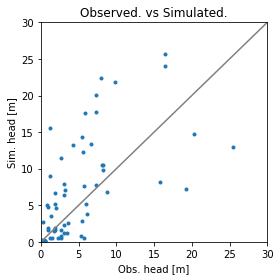

Error is - 8.737932521377855
Params are - [  4.87966933 175.98258332  15.52191708   0.77691682   0.25771939
   0.37573601]


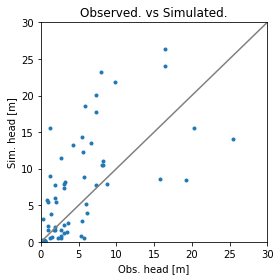

Error is - 8.729465915079986
Params are - [  3.95415755 176.54002156  15.56177028   0.77936215   0.25784017
   0.37511963]


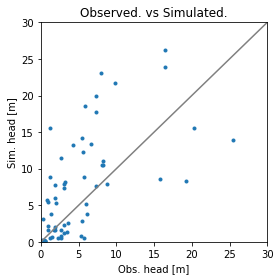

Error is - 8.721214646217899
Params are - [  3.99351564 176.47124118  15.55739344   0.77807212   0.25904325
   0.37517361]


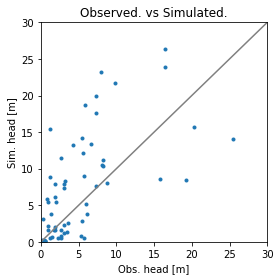

Error is - 8.717621251627593
Params are - [  3.8910686  176.38448095  15.55990804   0.77783402   0.25975755
   0.37539848]


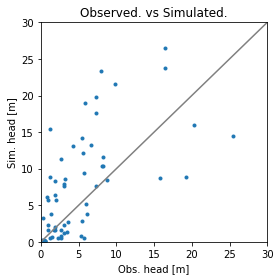

Error is - 8.713505022016072
Params are - [  3.65372272 176.36794828  15.56670849   0.7772376    0.26119472
   0.3755151 ]


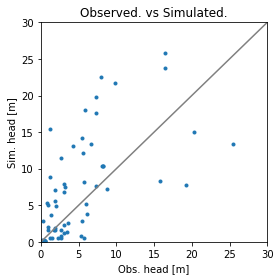

Error is - 8.715075127797773
Params are - [  4.45781807 176.00537331  15.52848252   0.77642653   0.26022179
   0.37620035]


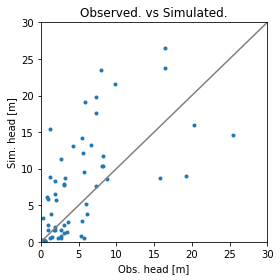

Error is - 8.714936407976458
Params are - [  3.58181059 176.5528294   15.56638447   0.77772457   0.26137529
   0.37506615]


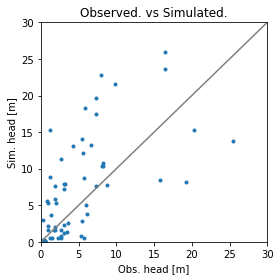

Error is - 8.701677144284398
Params are - [  4.09701414 176.1249365   15.54107889   0.77567603   0.26211349
   0.37581792]


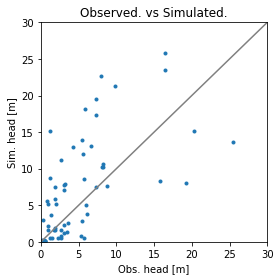

Error is - 8.689575948581991
Params are - [  4.16844243 175.91739396  15.5307332    0.77383297   0.26425015
   0.37616706]


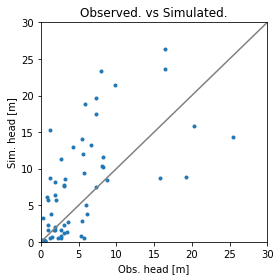

Error is - 8.700499704938341
Params are - [  3.66634535 176.34526992  15.56683679   0.77694022   0.26334785
   0.37434699]


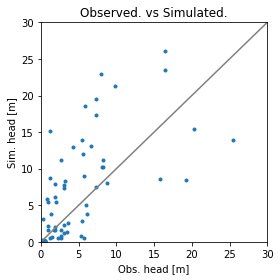

Error is - 8.690593732435731
Params are - [  3.8945033  176.05115292  15.54728372   0.77552252   0.26425636
   0.37538252]


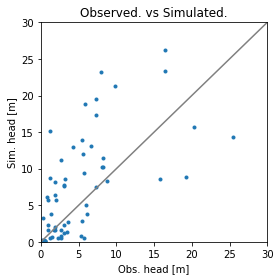

Error is - 8.687612056158617
Params are - [  3.6716298  176.03495518  15.54725707   0.77393946   0.26537304
   0.37651999]


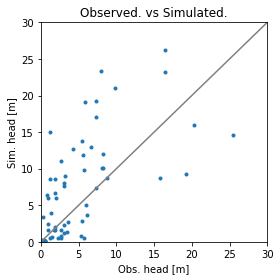

Error is - 8.679013696397805
Params are - [  3.43948585 175.86324907  15.54344261   0.77159818   0.26830505
   0.37759361]


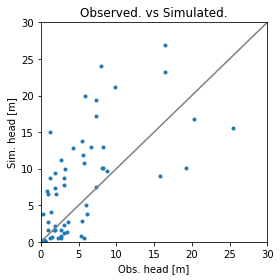

Error is - 8.717227512203566
Params are - [  3.01028535 176.36057454  15.57864724   0.77452549   0.26735468
   0.37515679]


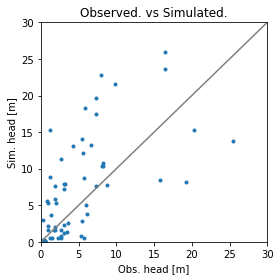

Error is - 8.70225934640578
Params are - [  4.09593489 176.09417362  15.5410237    0.77595127   0.26200502
   0.37593946]


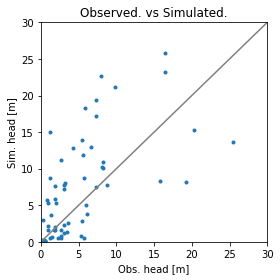

Error is - 8.677608344789155
Params are - [  4.05766759 175.66023319  15.53229169   0.77263635   0.26641109
   0.3765821 ]


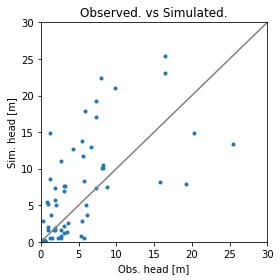

Error is - 8.666371948167539
Params are - [  4.29559609 175.21393509  15.51524531   0.77009224   0.26892899
   0.37734008]


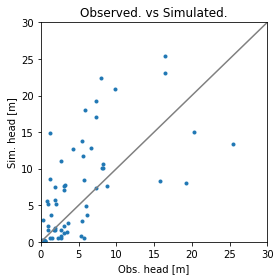

Error is - 8.664490320026491
Params are - [  4.19971325 175.46044324  15.51481328   0.77074153   0.26916975
   0.37674148]


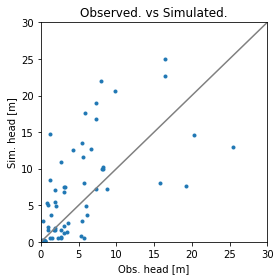

Error is - 8.650745712976823
Params are - [  4.47270852 175.00669072  15.48886568   0.76749349   0.27315726
   0.37735466]


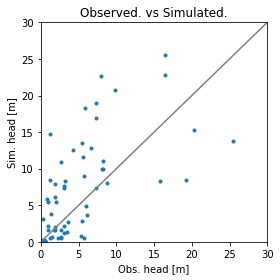

Error is - 8.650412689315793
Params are - [  3.88309229 175.37172361  15.52311207   0.7692086    0.27207687
   0.37678885]


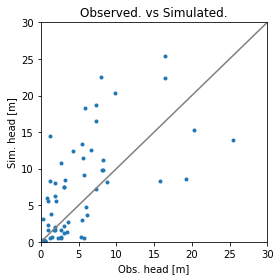

Error is - 8.629715788619212
Params are - [  3.776671   175.0104986   15.51415625   0.76583727   0.2771128
   0.37721354]


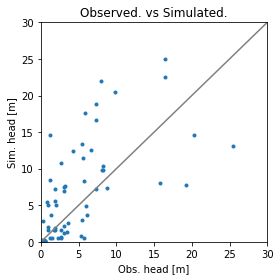

Error is - 8.639058611562712
Params are - [  4.34945705 174.67570353  15.47973879   0.76451867   0.27532235
   0.37933683]


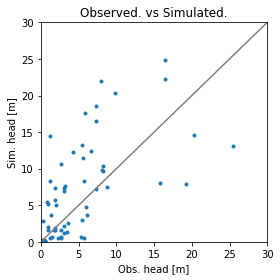

Error is - 8.627451167970026
Params are - [  4.27295034 174.51133741  15.4767769    0.76226842   0.27810251
   0.37961941]


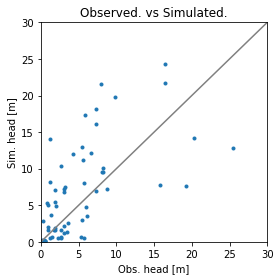

Error is - 8.609223712982626
Params are - [  4.46217386 173.74142965  15.44152349   0.75564137   0.28502558
   0.38173785]


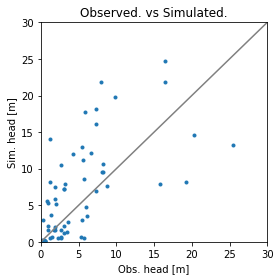

Error is - 8.602469365930055
Params are - [  4.09692169 173.91977492  15.46359084   0.7578941    0.28503386
   0.38069179]


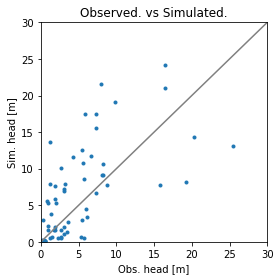

Error is - 8.57692435837279
Params are - [  4.06116132 172.9209654   15.43001966   0.74992466   0.29542571
   0.38295416]


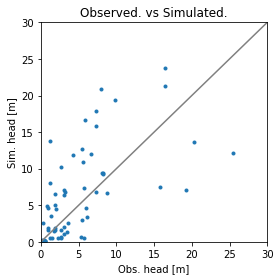

Error is - 8.616467789313631
Params are - [  5.03310342 172.9931586   15.41307378   0.75290438   0.29001919
   0.3810521 ]


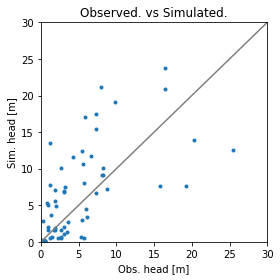

Error is - 8.583855379628204
Params are - [  4.42282897 172.90221375  15.40721391   0.74868104   0.2964253
   0.38254297]


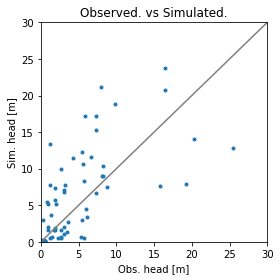

Error is - 8.572708375379529
Params are - [  4.22909002 172.40796579  15.40637628   0.74500898   0.29995305
   0.38425782]


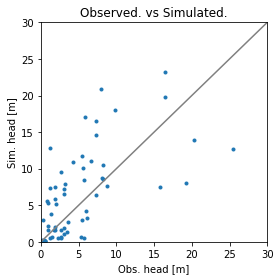

Error is - 8.55617927145125
Params are - [  4.10728077 171.10860333  15.36513158   0.73376672   0.31335094
   0.38770939]


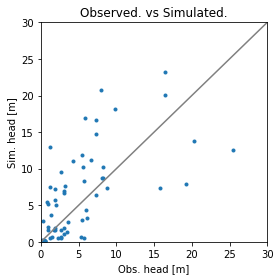

Error is - 8.56339815162444
Params are - [  4.27161606 171.54991957  15.37730076   0.73773315   0.31046416
   0.3850665 ]


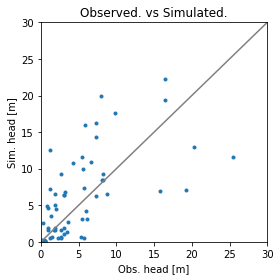

Error is - 8.589748708671406
Params are - [  5.0093838  170.06159816  15.29726481   0.72704651   0.31979083
   0.38980745]


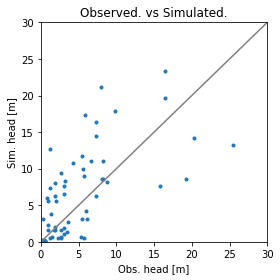

Error is - 8.546882664317879
Params are - [  3.74504484 171.10175135  15.35974428   0.7313601    0.31680832
   0.38888734]


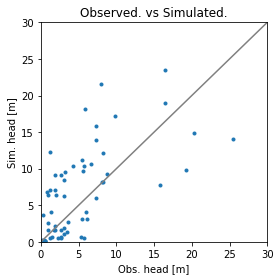

Error is - 8.548564880529858
Params are - [  3.10101554 170.15604773  15.33307953   0.72058796   0.33020289
   0.39280497]


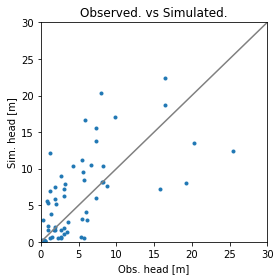

Error is - 8.555648905821894
Params are - [  4.07693139 169.47358754  15.30403485   0.72052935   0.33239618
   0.39058475]


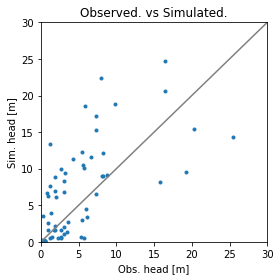

Error is - 8.571679795440337
Params are - [  3.21890398 172.95741548  15.4505502    0.74695183   0.30183271
   0.38277425]


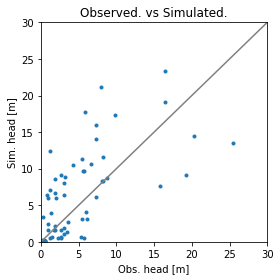

Error is - 8.543059047265851
Params are - [  3.40415048 170.13520048  15.35504653   0.72474089   0.32700071
   0.39011583]


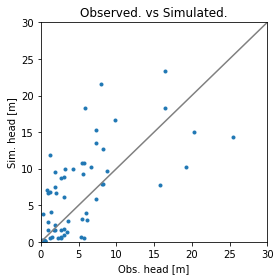

Error is - 8.560221020160645
Params are - [  2.89481124 168.75169385  15.32896285   0.71277082   0.34228841
   0.39390226]


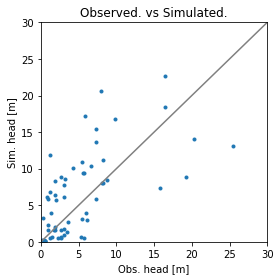

Error is - 8.546045654761613
Params are - [  3.54681452 169.18786052  15.30724975   0.71510269   0.3385253
   0.39209187]


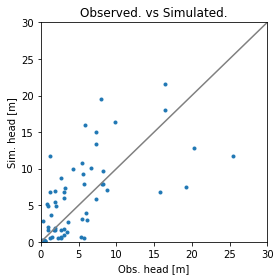

Error is - 8.581974271353163
Params are - [  4.49837537 167.89489211  15.23895238   0.70745914   0.34434916
   0.39537764]


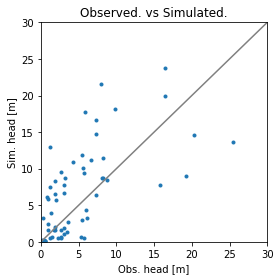

Error is - 8.549609546805835
Params are - [  3.53877183 171.69178464  15.39765075   0.73707866   0.31246182
   0.3859251 ]


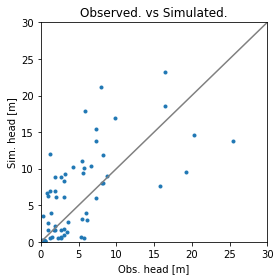

Error is - 8.546155816348714
Params are - [  3.20138188 169.34967638  15.31898515   0.71645966   0.3363836
   0.39337159]


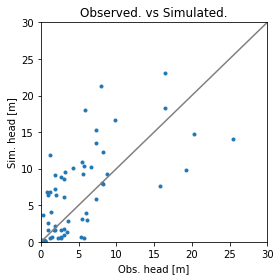

Error is - 8.551942453568532
Params are - [  3.06375088 169.20468364  15.31577219   0.71465706   0.34117436
   0.39261611]


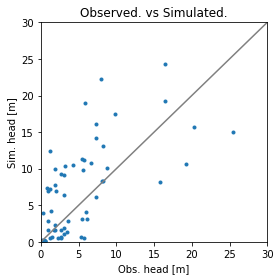

Error is - 8.574719458562276
Params are - [  2.75637342 170.7500648   15.38078137   0.725937     0.32505519
   0.39041786]


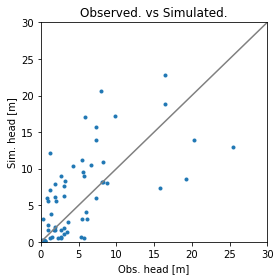

Error is - 8.545932374974539
Params are - [  3.7467919  169.79270685  15.32322148   0.72188127   0.33056093
   0.39054303]


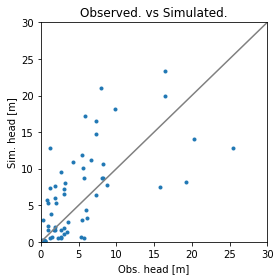

Error is - 8.553755696151274
Params are - [  3.99723427 171.21497643  15.37152712   0.73421736   0.3127392
   0.38769548]


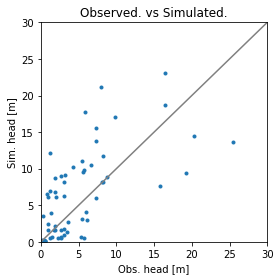

Error is - 8.544446560653864
Params are - [  3.29712173 169.70725684  15.32971092   0.71954714   0.33406557
   0.39138595]


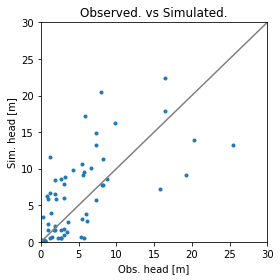

Error is - 8.551590423714071
Params are - [  3.44166329 168.06636617  15.26700196   0.70595193   0.34865298
   0.39620677]


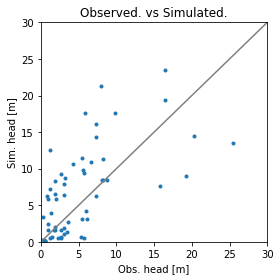

Error is - 8.543972371023502
Params are - [  3.51449469 170.78543002  15.36498855   0.72929698   0.32150961
   0.38849552]


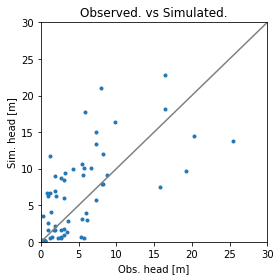

Error is - 8.551685781027075
Params are - [  3.15854023 168.55095901  15.30665651   0.71098278   0.34587358
   0.39311392]


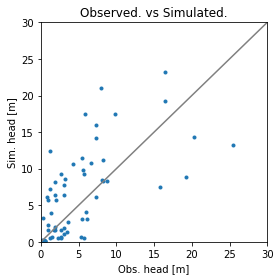

Error is - 8.543337796586293
Params are - [  3.59841868 170.46405327  15.34647234   0.72626577   0.32407464
   0.38994399]


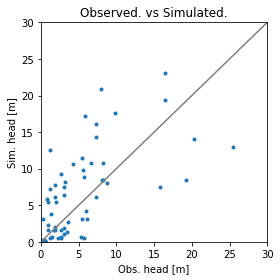

Error is - 8.547484375189267
Params are - [  3.83454879 170.67449295  15.35657804   0.72915192   0.32219532
   0.38748713]


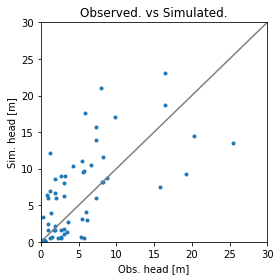

Error is - 8.543396093834687
Params are - [  3.35967361 169.68088052  15.32838337   0.71963273   0.33283653
   0.39190048]


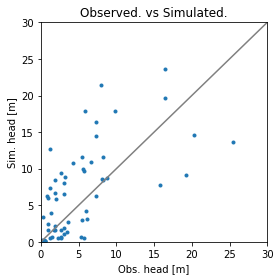

Error is - 8.54570439540963
Params are - [  3.42673584 171.00064881  15.37535799   0.7320189    0.31815737
   0.38870306]


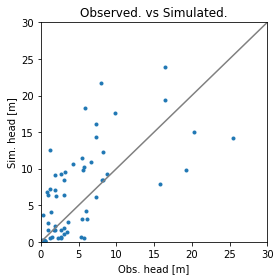

Error is - 8.55101091824602
Params are - [  3.12007312 170.79844979  15.37676509   0.72861953   0.32198721
   0.38963858]


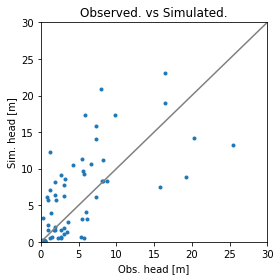

Error is - 8.543302988891917
Params are - [  3.5901122  170.04414259  15.33660738   0.72356583   0.3284175
   0.39031692]


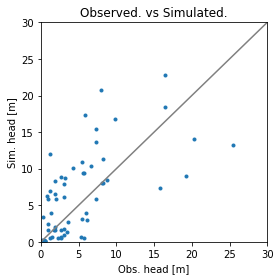

Error is - 8.545216409464775
Params are - [  3.49458796 169.27167243  15.31171172   0.71566421   0.33781082
   0.3920165 ]


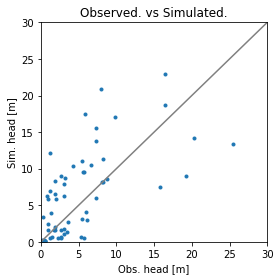

Error is - 8.543362917498996
Params are - [  3.47762493 169.70391652  15.32762328   0.71975289   0.33289746
   0.39118814]


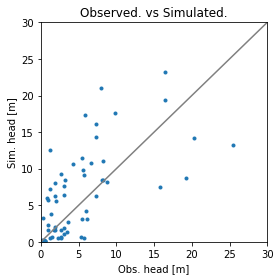

Error is - 8.54467274925329
Params are - [  3.68436981 170.56395096  15.3566629    0.72820456   0.32151324
   0.38926767]


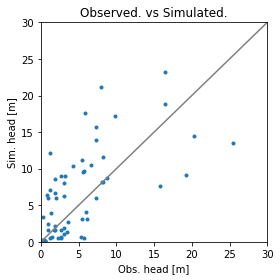

Error is - 8.543115281386338
Params are - [  3.39393375 169.92143037  15.33644892   0.72171149   0.33092749
   0.39085638]


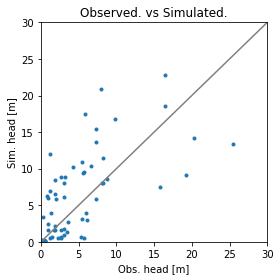

Error is - 8.544418906888488
Params are - [  3.42680986 169.19777789  15.31187206   0.71592623   0.33720849
   0.39294506]


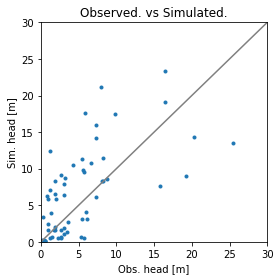

Error is - 8.542977943681164
Params are - [  3.49257348 170.38851699  15.35170943   0.72595429   0.32543433
   0.3896079 ]


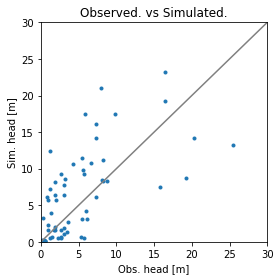

Error is - 8.543984620803881
Params are - [  3.6259309  170.53820622  15.35625259   0.72769766   0.32341418
   0.38877591]


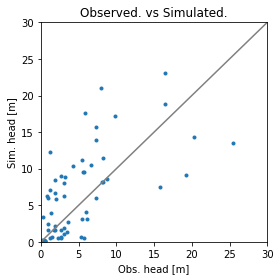

Error is - 8.5428440157666
Params are - [  3.42623793 169.89521194  15.33535068   0.72164896   0.33048094
   0.39111934]


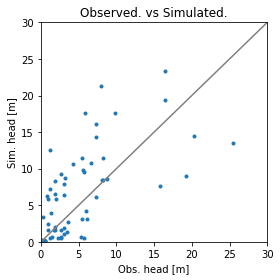

Error is - 8.54345879491028
Params are - [  3.49085058 170.57893536  15.35958848   0.72820953   0.32254775
   0.38946531]


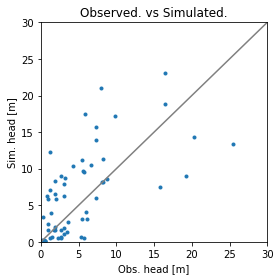

Error is - 8.54289218513163
Params are - [  3.48093134 169.92267123  15.33561458   0.72186705   0.33031003
   0.39075743]


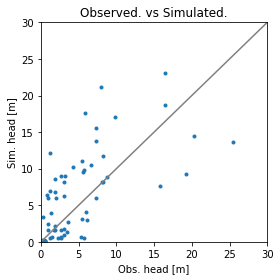

Error is - 8.544055279602263
Params are - [  3.33089438 169.63833793  15.33712017   0.7202304    0.33344903
   0.39098061]


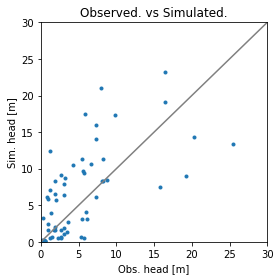

Error is - 8.542831300760614
Params are - [  3.53153761 170.25762443  15.3441343    0.72475693   0.32641823
   0.39020314]


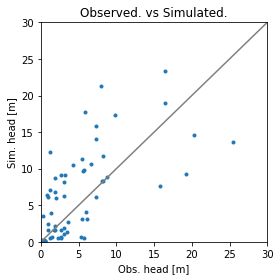

Error is - 8.543725371759795
Params are - [  3.319676   170.12940923  15.3494941    0.72332737   0.32843974
   0.39056976]


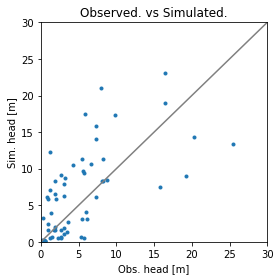

Error is - 8.54286124687004
Params are - [  3.52250315 170.06545925  15.33982906   0.72350622   0.32842306
   0.39038013]


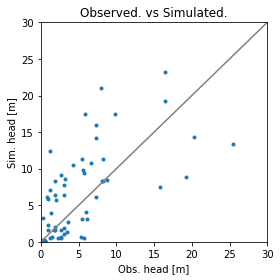

Error is - 8.543081126068229
Params are - [  3.55871092 170.30013107  15.35077928   0.72577995   0.32509495
   0.38987154]


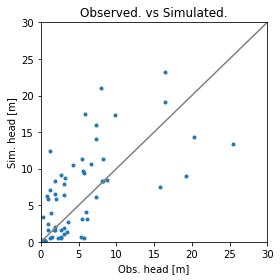

Error is - 8.542825525959927
Params are - [  3.51751663 170.2054559   15.34719669   0.72476284   0.32655308
   0.39011775]


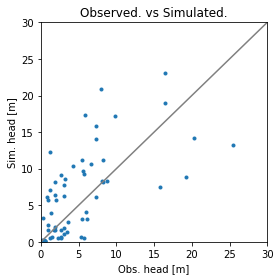

Error is - 8.543221449919892
Params are - [  3.5862829  170.10977944  15.32956504   0.72275786   0.32887252
   0.39061274]


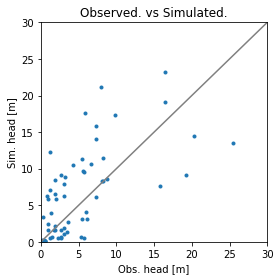

Error is - 8.542801212975908
Params are - [  3.44968359 170.12884522  15.34867616   0.72424514   0.32746866
   0.39024006]


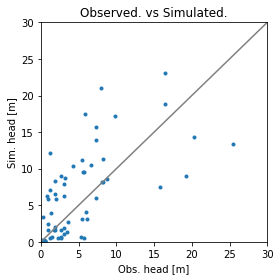

Error is - 8.542895740593737
Params are - [  3.48356326 169.76990567  15.33189106   0.72097475   0.331117
   0.39133138]


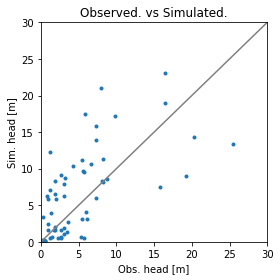

Error is - 8.542767015800964
Params are - [  3.48581582 169.9245585   15.33684565   0.72221964   0.32969633
   0.39090051]


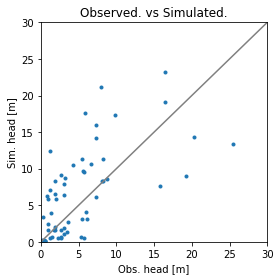

Error is - 8.542772130158507
Params are - [  3.49683357 170.23638051  15.34839626   0.72517953   0.32603674
   0.39022954]


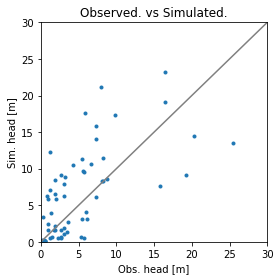

Error is - 8.542709258730374
Params are - [  3.44670523 170.15056625  15.34703752   0.72409812   0.32712827
   0.39055665]


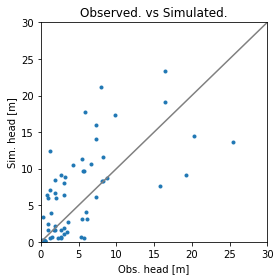

Error is - 8.542884714654365
Params are - [  3.40880627 170.19311976  15.35064175   0.72439408   0.32648087
   0.39064492]


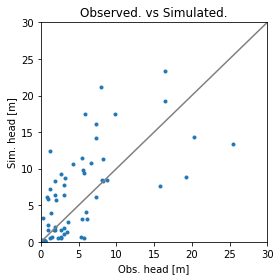

Error is - 8.54321672587631
Params are - [  3.54979288 170.40593166  15.35541152   0.72677177   0.32395283
   0.38962988]


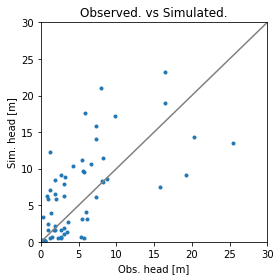

Error is - 8.542701045507796
Params are - [  3.45712667 170.02289187  15.34036589   0.72292966   0.32884891
   0.39074697]


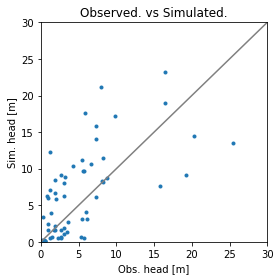

Error is - 8.542816034967643
Params are - [  3.41968956 169.96527498  15.34537176   0.72305471   0.32882577
   0.39072735]


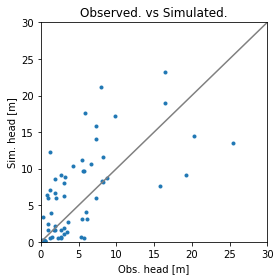

Error is - 8.542864848593407
Params are - [  3.40110152 169.93738322  15.34170106   0.72247943   0.32944848
   0.39101594]


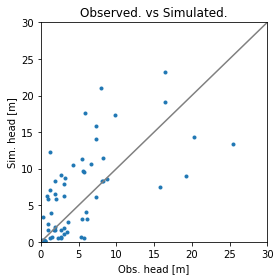

Error is - 8.542727106450124
Params are - [  3.48841285 170.13843773  15.34582278   0.72419199   0.32727693
   0.3903423 ]


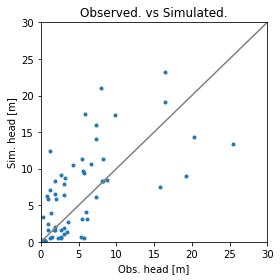

Error is - 8.542781463141369
Params are - [  3.52183635 170.23528504  15.34367633   0.72456664   0.32665952
   0.39027799]


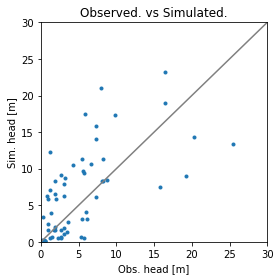

Error is - 8.542658125058482
Params are - [  3.51589324 170.10719475  15.33870531   0.72348339   0.32774691
   0.39077793]


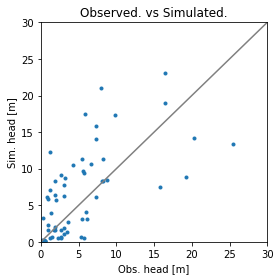

Error is - 8.542720421784997
Params are - [  3.54899807 170.09636952  15.33371989   0.72310252   0.32788604
   0.39104687]


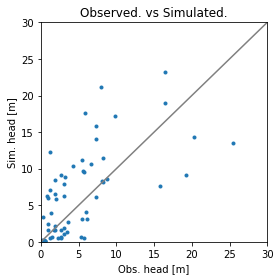

Error is - 8.542694489915387
Params are - [  3.44175944 169.95805816  15.34204814   0.7228008    0.32891852
   0.39090664]


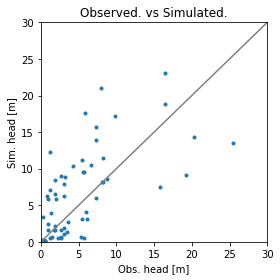

Error is - 8.542791020451988
Params are - [  3.44840418 169.86418857  15.33521217   0.72139501   0.33050188
   0.3911808 ]


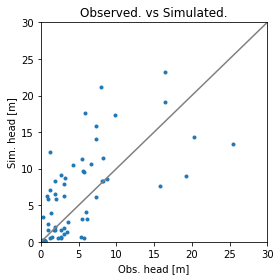

Error is - 8.54268573297662
Params are - [  3.48472622 170.14333253  15.34510024   0.7242334    0.32715303
   0.39046736]


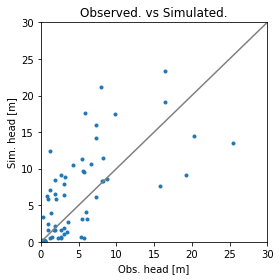

Error is - 8.542767387199294
Params are - [  3.45905873 170.24893527  15.34951431   0.72502615   0.32599452
   0.39036544]


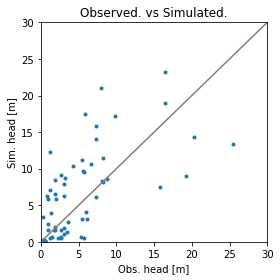

Error is - 8.54268595669982
Params are - [  3.47912655 170.00565269  15.34001282   0.72292126   0.32877088
   0.39076674]


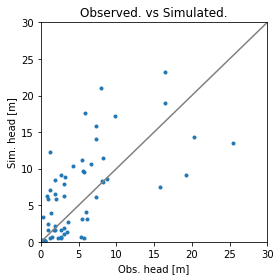

Error is - 8.54261840611216
Params are - [  3.45336627 169.99079436  15.33860053   0.72263023   0.32891191
   0.39106513]


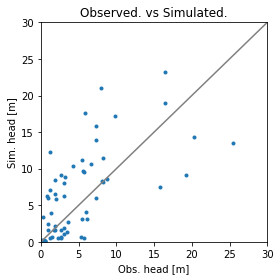

Error is - 8.542629608451604
Params are - [  3.43584298 169.91697268  15.3349894    0.72184935   0.3297294
   0.39142655]


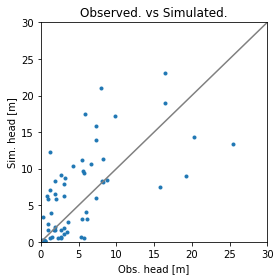

Error is - 8.542748152984325
Params are - [  3.49729423 169.92540854  15.33457346   0.72223479   0.32965512
   0.39102028]


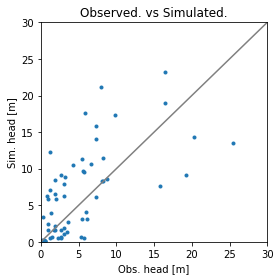

Error is - 8.542655610795942
Params are - [  3.45935248 170.09427682  15.3439215    0.72363229   0.32775998
   0.39067256]


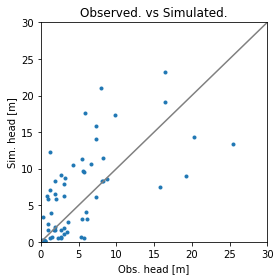

Error is - 8.542599248592738
Params are - [  3.48761473 170.0768779   15.34243029   0.72363746   0.32757149
   0.39080515]


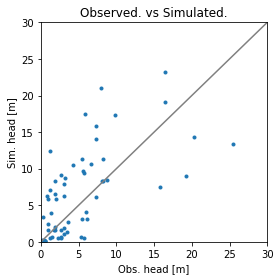

Error is - 8.542590577246369
Params are - [  3.50285876 170.10387091  15.3434625    0.72399136   0.32693279
   0.39083424]


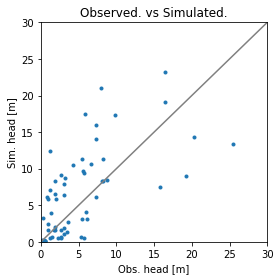

Error is - 8.542686412125247
Params are - [  3.5233484  170.19031586  15.34121949   0.72416318   0.32683998
   0.39062134]


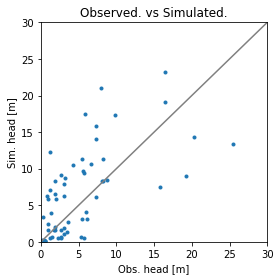

Error is - 8.542636612013458
Params are - [  3.50295116 170.13225144  15.34142665   0.72382258   0.32735962
   0.39069267]


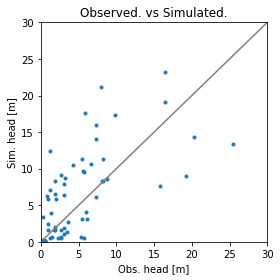

Error is - 8.5426025089345
Params are - [  3.49392283 170.18492092  15.3437261    0.72434315   0.3265172
   0.39073655]


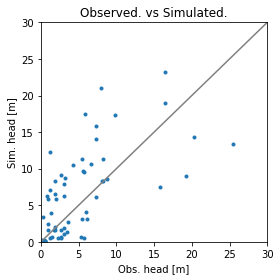

Error is - 8.542518251930327
Params are - [  3.49138869 170.06110387  15.33818062   0.7230676    0.32792311
   0.39112567]


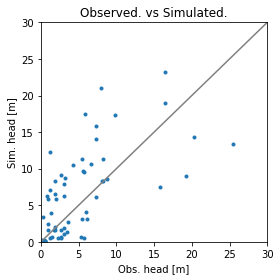

Error is - 8.542449710157763
Params are - [  3.49471993 170.01998954  15.33472082   0.72248471   0.32830814
   0.39145483]


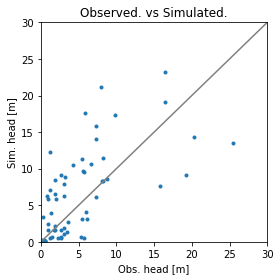

Error is - 8.542554597759356
Params are - [  3.4531639  170.06817325  15.34324738   0.72348471   0.3275163
   0.39104073]


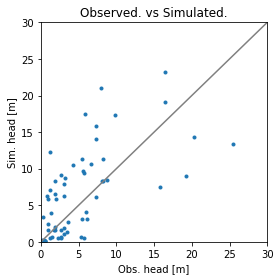

Error is - 8.5424773324614
Params are - [  3.5076418  170.07238998  15.33780649   0.72328662   0.327422
   0.39126883]


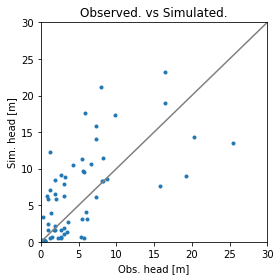

Error is - 8.542425056149328
Params are - [  3.46560667 170.01446155  15.33909462   0.72291768   0.32784316
   0.39144077]


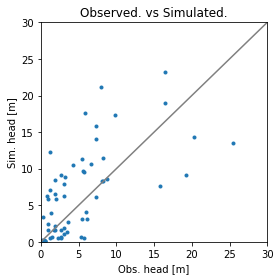

Error is - 8.542359760736803
Params are - [  3.44693442 169.95556661  15.3379286    0.72246522   0.32808494
   0.39181482]


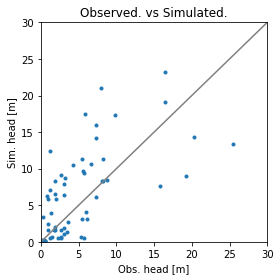

Error is - 8.542461755404052
Params are - [  3.51304761 170.14417604  15.34169677   0.72405503   0.32601521
   0.3913182 ]


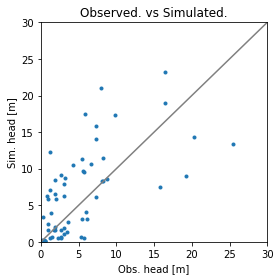

Error is - 8.542326973527873
Params are - [  3.47886598 169.93646786  15.33589475   0.72224607   0.3282426
   0.39184067]


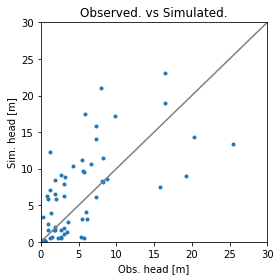

Error is - 8.542244671324482
Params are - [  3.47133755 169.81224133  15.33197908   0.72119753   0.3291053
   0.39239272]


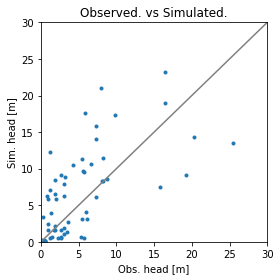

Error is - 8.542227502656539
Params are - [  3.45942298 169.920308    15.33233055   0.72166658   0.32855118
   0.39226247]


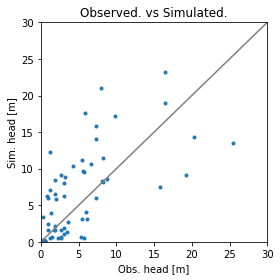

Error is - 8.542128350511776
Params are - [  3.43770509 169.82852655  15.32676457   0.7205042    0.32936037
   0.39297659]


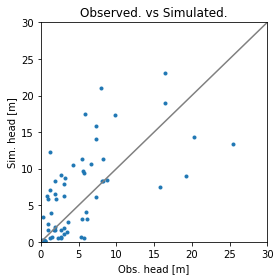

Error is - 8.542128005468394
Params are - [  3.5039649  169.87612344  15.32705139   0.72117972   0.32858236
   0.39270127]


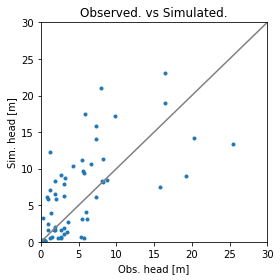

Error is - 8.542034026226027
Params are - [  3.5293654  169.78009853  15.3189534    0.72002722   0.32911538
   0.39353154]


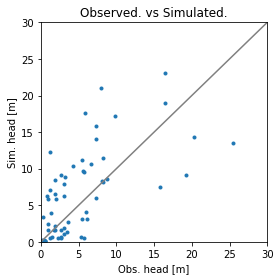

Error is - 8.542014484118868
Params are - [  3.4567282  169.77447622  15.32620792   0.72029135   0.32924112
   0.39322741]


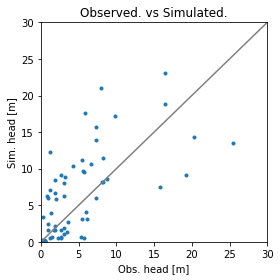

Error is - 8.54189286783794
Params are - [  3.4312714  169.62551934  15.32040864   0.71879371   0.33015067
   0.3942067 ]


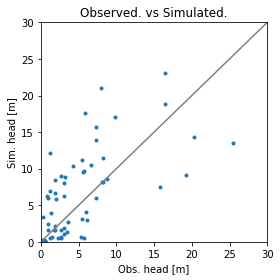

Error is - 8.542272077224585
Params are - [  3.42406365 169.52980459  15.3152216    0.71776916   0.33202639
   0.39414086]


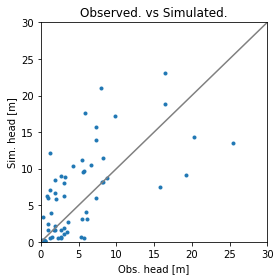

Error is - 8.541866401782594
Params are - [  3.41883925 169.49059611  15.31569781   0.71776764   0.33097287
   0.39489958]


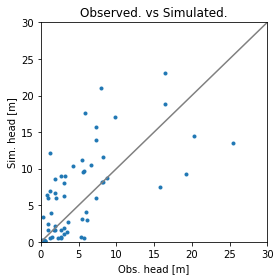

Error is - 8.541822867388163
Params are - [  3.38089891 169.22589939  15.30618631   0.71540911   0.33230524
   0.39662195]


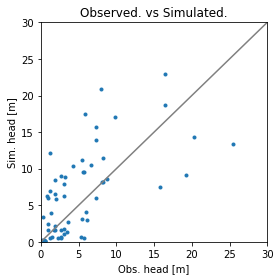

Error is - 8.541821762099403
Params are - [  3.44461291 169.31179664  15.30190927   0.71543509   0.33260285
   0.39614196]


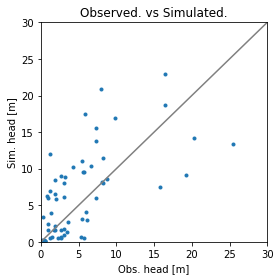

Error is - 8.541937657713571
Params are - [  3.44345216 168.98991165  15.28389961   0.71192002   0.33486181
   0.39830553]


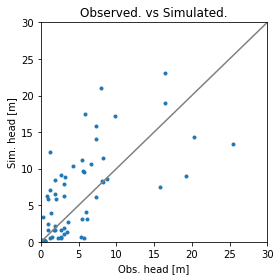

Error is - 8.541604627566338
Params are - [  3.47433344 169.66488933  15.32017882   0.71935312   0.32885355
   0.39448295]


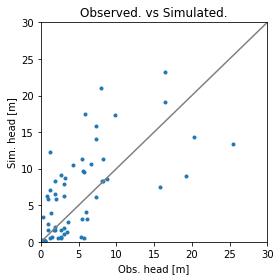

Error is - 8.541464884362332
Params are - [  3.49946833 169.7324317   15.32265743   0.7201451    0.32726713
   0.394654  ]


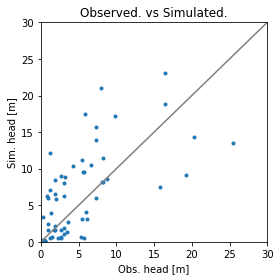

Error is - 8.541252999075695
Params are - [  3.43643646 169.35584938  15.30031412   0.71557395   0.33116192
   0.39698486]


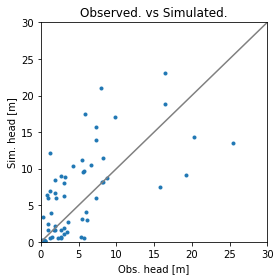

Error is - 8.54086535198511
Params are - [  3.41898591 169.12765341  15.28448164   0.71276216   0.33219023
   0.39928092]


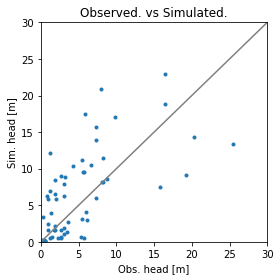

Error is - 8.540974420103558
Params are - [  3.4638292  169.10593979  15.29143433   0.7136866    0.33185013
   0.39850243]


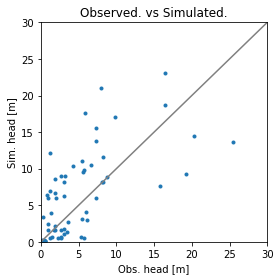

Error is - 8.54137686437278
Params are - [  3.35032349 168.92964822  15.29007248   0.71205003   0.3330067
   0.39960445]


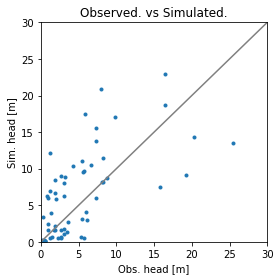

Error is - 8.540664752645444
Params are - [  3.42143485 168.85227038  15.27850518   0.71103565   0.33292342
   0.40072854]


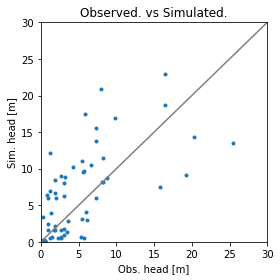

Error is - 8.540214161576715
Params are - [  3.41651657 168.4656459   15.25755345   0.70715662   0.33430979
   0.40398947]


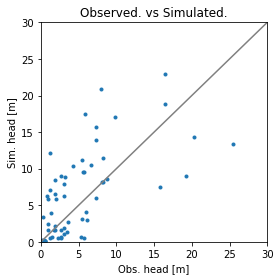

Error is - 8.540251428790345
Params are - [  3.48367989 168.9984725   15.27651656   0.71166942   0.33143703
   0.40076913]


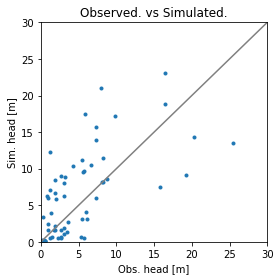

Error is - 8.53956828713367
Params are - [  3.43298822 168.80813387  15.27232936   0.71038822   0.33075082
   0.4027915 ]


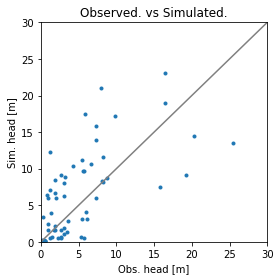

Error is - 8.538525627348582
Params are - [  3.42717587 168.55630248  15.2575394    0.70786479   0.3298248
   0.40611628]


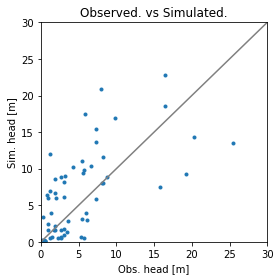

Error is - 8.540380806225048
Params are - [  3.35403532 167.99545573  15.22987519   0.70158478   0.3369391
   0.40810023]


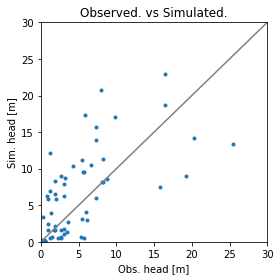

Error is - 8.53915777065465
Params are - [  3.50441744 168.48684171  15.24239438   0.70619142   0.33251033
   0.40598171]


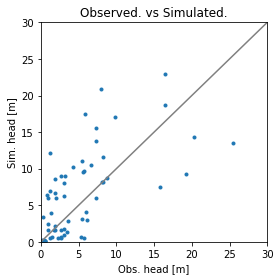

Error is - 8.538595364796619
Params are - [  3.40444113 168.10418412  15.22468588   0.70205646   0.33388697
   0.40957681]


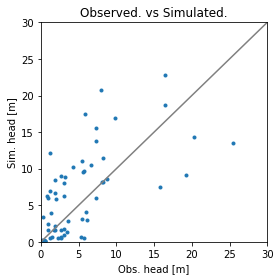

Error is - 8.537913653566902
Params are - [  3.44443616 167.74131407  15.21170664   0.69941234   0.33411245
   0.41223028]


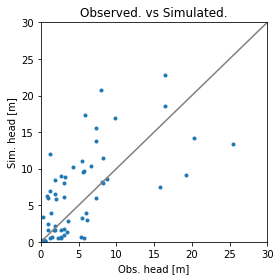

Error is - 8.53661456066859
Params are - [  3.45716129 167.04814441  15.17531914   0.69273744   0.33507356
   0.41870496]


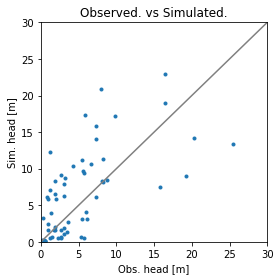

Error is - 8.538211002040644
Params are - [  3.54376208 168.55774131  15.24812775   0.70764061   0.32874173
   0.40694589]


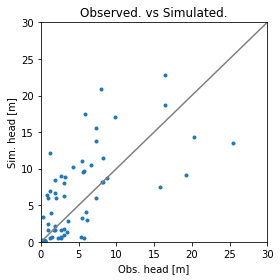

Error is - 8.5365945247618
Params are - [  3.4341449  167.40781415  15.19202345   0.69621303   0.33334536
   0.4163359 ]


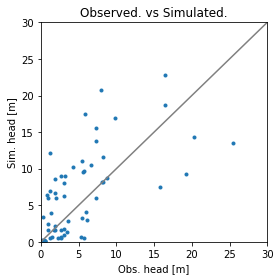

Error is - 8.535009396738271
Params are - [  3.4093774  166.61248497  15.14977689   0.68848483   0.33429952
   0.42411929]


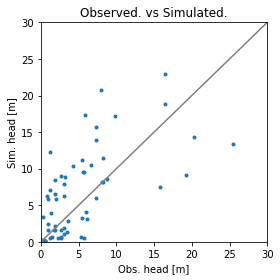

Error is - 8.534888229263629
Params are - [  3.4989285  167.32292044  15.17506103   0.6945019    0.33046917
   0.41982551]


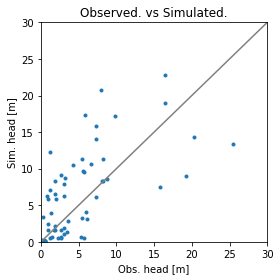

Error is - 8.53254942701982
Params are - [  3.54013446 166.75155771  15.13381482   0.68817453   0.32854886
   0.42774353]


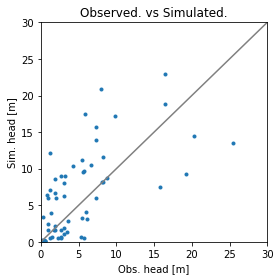

Error is - 8.53375277879864
Params are - [  3.42293331 166.72329662  15.15402692   0.68946147   0.33094815
   0.42508721]


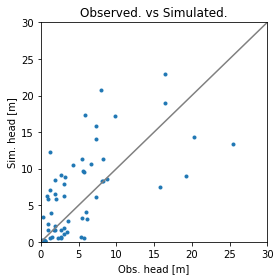

Error is - 8.532843314741903
Params are - [  3.52907367 166.64565838  15.14818243   0.68939809   0.32859191
   0.42666224]


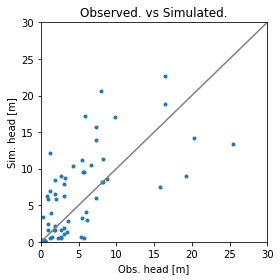

Error is - 8.531189401743818
Params are - [  3.54030486 165.55665865  15.07887658   0.6774342    0.33224311
   0.43697143]


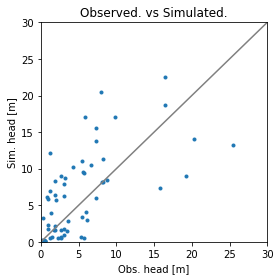

Error is - 8.528334233538056
Params are - [  3.59686936 164.05683673  14.98954517   0.66221891   0.33345226
   0.45239901]


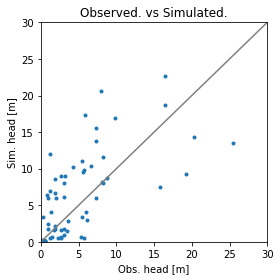

Error is - 8.528660660780188
Params are - [  3.44142108 164.05491829  15.00209404   0.66251781   0.33489636
   0.45129286]


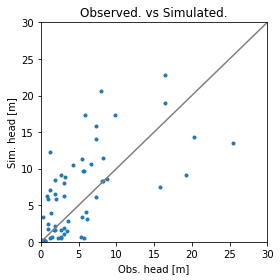

Error is - 8.526879547636257
Params are - [  3.52277514 164.56677316  15.01716094   0.66734778   0.32850546
   0.45039642]


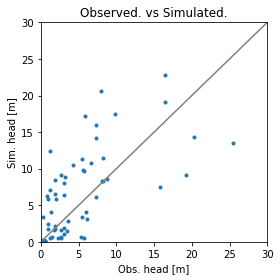

Error is - 8.522808809825175
Params are - [  3.55558207 163.32608753  14.93808184   0.65465295   0.32522142
   0.46624215]


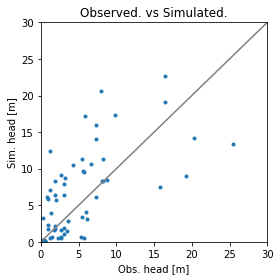

Error is - 8.52484115043053
Params are - [  3.61929392 163.90696678  14.97213818   0.66032309   0.32625347
   0.45902304]


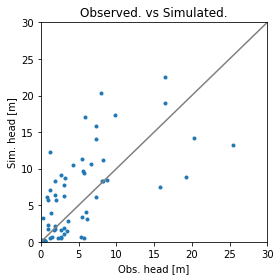

Error is - 8.523160054964386
Params are - [  3.67119154 162.85737852  14.90725857   0.64963366   0.32803994
   0.46936707]


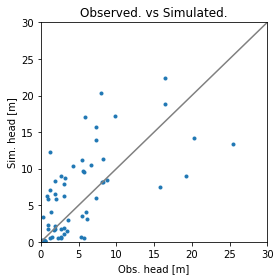

Error is - 8.520369641798565
Params are - [  3.61242381 161.67225681  14.83279511   0.63644222   0.33021219
   0.48202698]


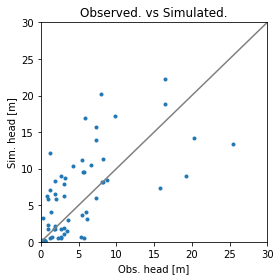

Error is - 8.515030886613937
Params are - [  3.65409887 159.18555602  14.67510146   0.60996429   0.33102234
   0.50970935]


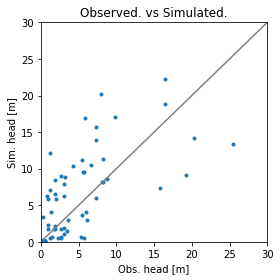

Error is - 8.515295719199353
Params are - [  3.63935115 159.04435692  14.69425827   0.6115957    0.33107973
   0.50826763]


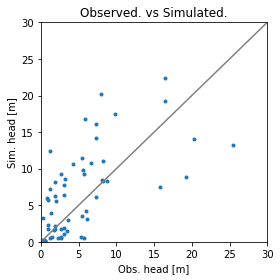

Error is - 8.516147921681146
Params are - [  3.80404122 160.07080921  14.72336712   0.62027838   0.32346003
   0.50370989]


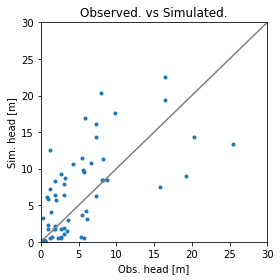

Error is - 8.511601560234602
Params are - [  3.71765023 158.74021494  14.64718998   0.60659711   0.32157338
   0.51970737]


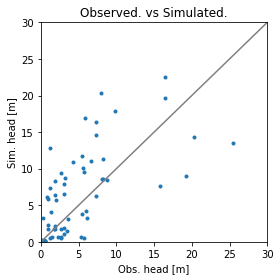

Error is - 8.506004775241436
Params are - [  3.77804067 156.08190404  14.47601239   0.57878622   0.31563394
   0.55336155]


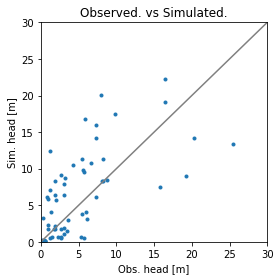

Error is - 8.50706667349383
Params are - [  3.74814126 156.28173063  14.49922171   0.58131398   0.32523233
   0.5445295 ]


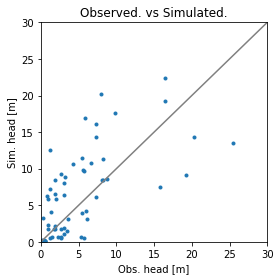

Error is - 8.503599118663432
Params are - [  3.72189354 155.13943626  14.42808902   0.56923018   0.32250999
   0.55923963]


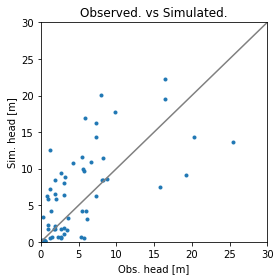

Error is - 8.495333187935957
Params are - [  3.74724454 151.28046514  14.18850425   0.52902843   0.31974501
   0.6041759 ]


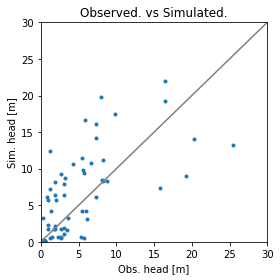

Error is - 8.496303822519614
Params are - [  3.90139051 150.65551979  14.14740655   0.52233605   0.32350304
   0.60834246]


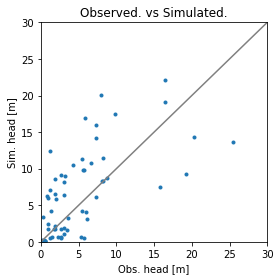

Error is - 8.495217527076754
Params are - [  3.68538111 150.77236831  14.17013442   0.52406317   0.32527877
   0.60575224]


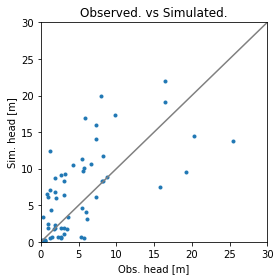

Error is - 8.487207213376081
Params are - [  3.62605106 146.12314785  13.89351806   0.47595557   0.32618814
   0.65677342]


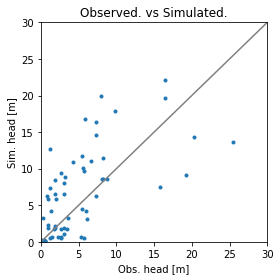

Error is - 8.488098470081415
Params are - [  3.84563782 147.4917509   13.93232987   0.48753248   0.31602854
   0.65069643]


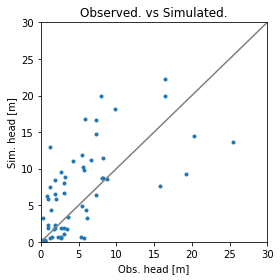

Error is - 8.482561501361046
Params are - [  3.89473641 143.45261676  13.70389615   0.44835329   0.31108799
   0.6962504 ]


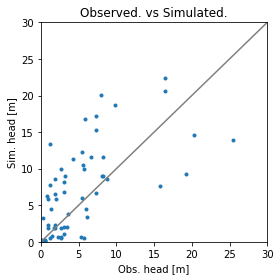

Error is - 8.477183488902051
Params are - [  4.01505518 135.58614713  13.2182935    0.36754779   0.30112082
   0.78952093]


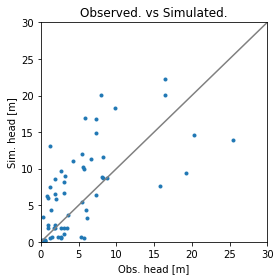

Error is - 8.476809762199059
Params are - [  3.88966533 139.45791432  13.45279983   0.40574821   0.30884083
   0.74309406]


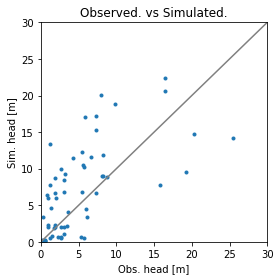

Error is - 8.473023141996102
Params are - [  3.96042736 131.04600616  12.9295889    0.31796532   0.30064508
   0.84237634]


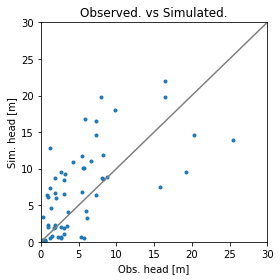

Error is - 8.465009278920208
Params are - [  3.92056148 131.31244162  12.96053465   0.32133567   0.31344294
   0.83060027]


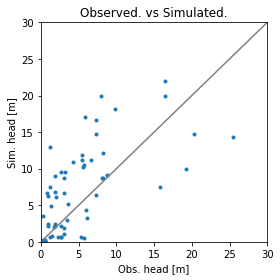

Error is - 8.481210925862849
Params are - [  3.99182188 118.92771041  12.20279578   0.19261039   0.31234744
   0.96921963]


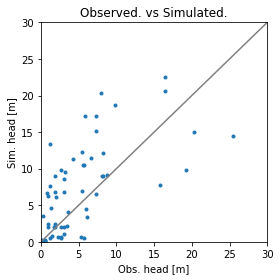

Error is - 8.473420973085908
Params are - [  3.80360197 130.29113315  12.89351652   0.3107857    0.30222047
   0.84970531]


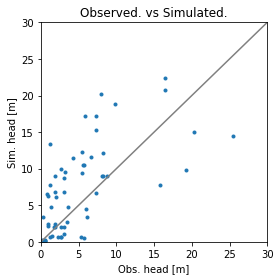

Error is - 8.476901217251665
Params are - [  3.97653375 122.6697438   12.42075626   0.23134574   0.30013698
   0.935715  ]


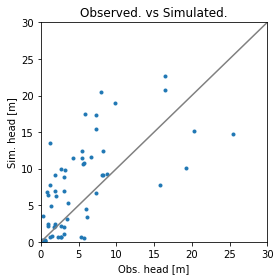

Error is - 8.498257439790317
Params are - [  3.92177245 118.18445567  12.17307276   0.18744612   0.29855627
   0.98420066]


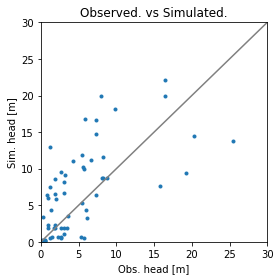

Error is - 8.47656739311913
Params are - [  3.86467147 140.1649271   13.49251559   0.41251089   0.31166047
   0.73407249]


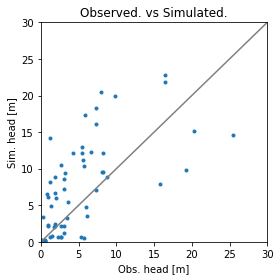

Error is - 8.526815704366818
Params are - [  4.22089935 117.56698513  12.07821708   0.1778748    0.28355411
   1.00389003]


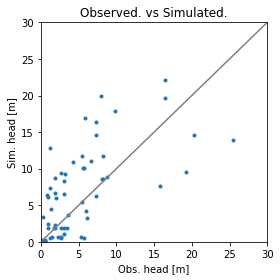

Error is - 8.474298427751489
Params are - [  3.77476313 138.98410717  13.43969282   0.40143538   0.31552963
   0.74355257]


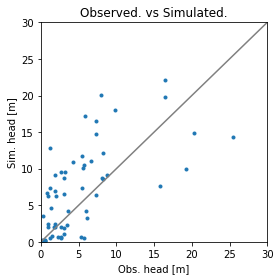

Error is - 8.466184690084734
Params are - [  3.75179788 129.2366392   12.82724141   0.29757844   0.31342437
   0.85581972]


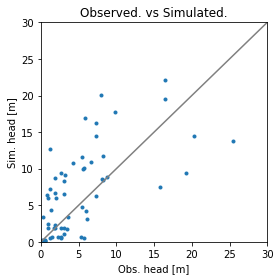

Error is - 8.482397932946771
Params are - [  3.71540735 144.34200766  13.76027371   0.45585806   0.31883734
   0.6829939 ]


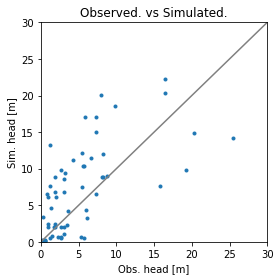

Error is - 8.468390356125909
Params are - [  3.91125215 128.08780977  12.75563562   0.28747382   0.30481207
   0.87253472]


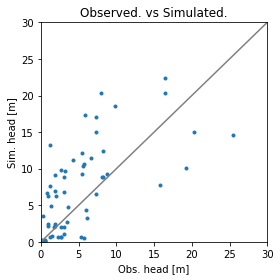

Error is - 8.474591973615366
Params are - [  3.84279652 122.8211186   12.44288772   0.23301388   0.30503105
   0.93079049]


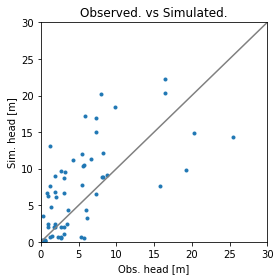

Error is - 8.468093819059622
Params are - [  3.84826526 127.15707072  12.70529468   0.27788814   0.30668841
   0.88161099]


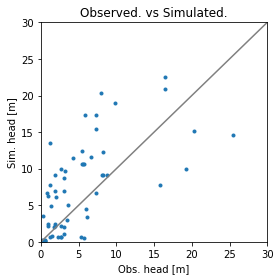

Error is - 8.489053629548112
Params are - [  3.95720557 120.05959303  12.25091111   0.20290698   0.29821481
   0.96732988]


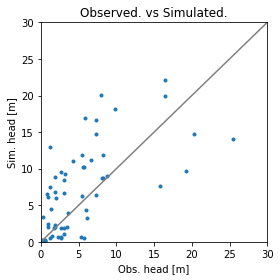

Error is - 8.469297628921902
Params are - [  3.82037374 134.25297864  13.14249739   0.35180328   0.31120093
   0.7994969 ]


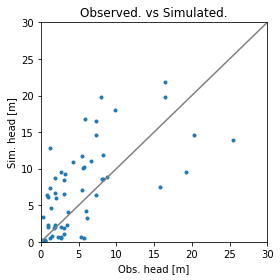

Error is - 8.46382935384594
Params are - [  3.93395732 130.07318222  12.88008103   0.30722918   0.31451747
   0.84444101]


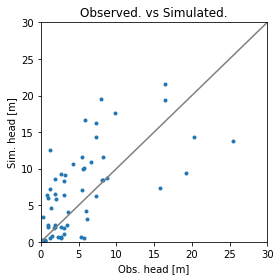

Error is - 8.463661629995734
Params are - [  3.99913499 129.96420676  12.87336328   0.30545092   0.32066597
   0.84180886]


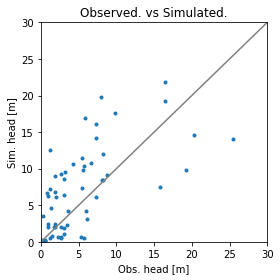

Error is - 8.46459895432524
Params are - [  3.79003447 128.95770941  12.82526678   0.2958781    0.32276648
   0.85158082]


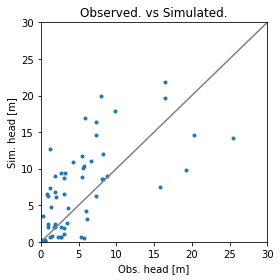

Error is - 8.465334452665221
Params are - [  3.919975   123.98564719  12.50661475   0.24339842   0.31606582
   0.91182156]


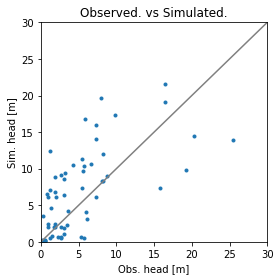

Error is - 8.465061520741305
Params are - [  3.83200421 128.78342853  12.81046957   0.29303607   0.32620592
   0.85187935]


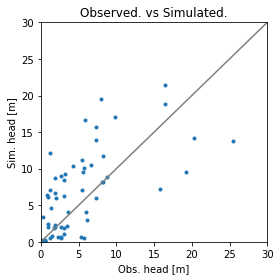

Error is - 8.467758978393743
Params are - [  3.88957076 130.25628685  12.8958688    0.30767107   0.33083543
   0.83289254]


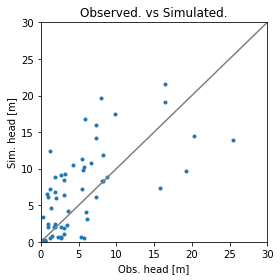

Error is - 8.464512913096309
Params are - [  3.87924438 129.48148282  12.84822527   0.30022534   0.32479867
   0.84507215]


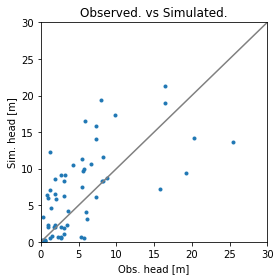

Error is - 8.46560885395702
Params are - [  4.0285203  128.25833291  12.78091669   0.28886307   0.32789089
   0.85510128]


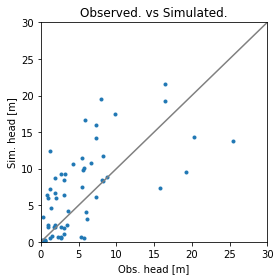

Error is - 8.463844459548369
Params are - [  3.95933969 128.50290948  12.79249787   0.29104191   0.32427426
   0.85528089]


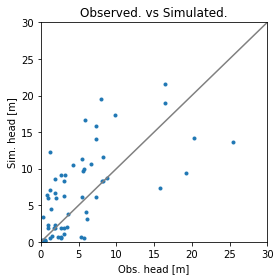

Error is - 8.470880374241352
Params are - [  3.87346474 135.01507902  13.19683772   0.35892425   0.32798559
   0.78025255]


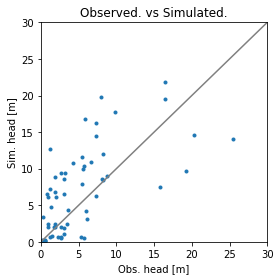

Error is - 8.46300853047161
Params are - [  3.90834744 126.74300515  12.67917049   0.27227988   0.31904576
   0.87892931]


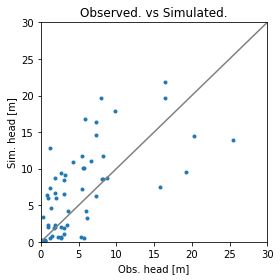

Error is - 8.463226095290294
Params are - [  3.98688327 129.53715655  12.84921655   0.30236786   0.31545877
   0.84921141]


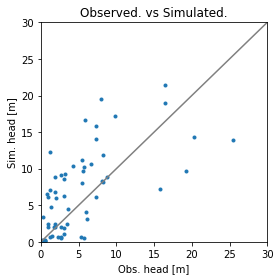

Error is - 8.465885501455716
Params are - [  3.92043327 126.41638177  12.66204543   0.26774567   0.3288937
   0.87669421]


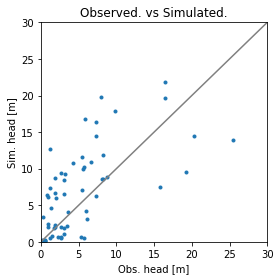

Error is - 8.463579782172545
Params are - [  3.92052943 130.08842666  12.88591235   0.30793817   0.31730563
   0.84212376]


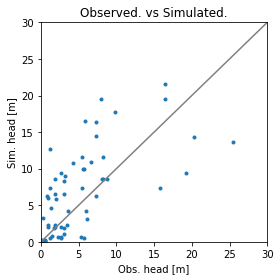

Error is - 8.463194808625085
Params are - [  4.0944586  129.14801973  12.81752849   0.29722326   0.31774987
   0.85256131]


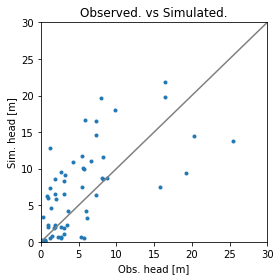

Error is - 8.463119464898522
Params are - [  4.07698676 128.51309195  12.78433774   0.29187533   0.31336808
   0.86156636]


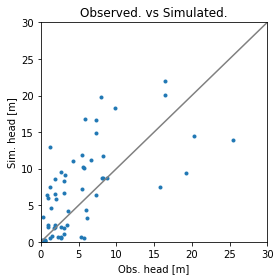

Error is - 8.464458519333968
Params are - [  4.03610714 129.49505945  12.8373451    0.30133656   0.3102571
   0.85345278]


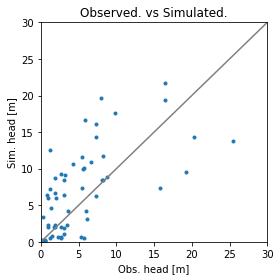

Error is - 8.463033903790583
Params are - [  3.97853155 128.75094697  12.80370968   0.29361557   0.32076997
   0.85482386]


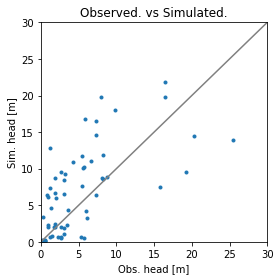

Error is - 8.46283977529002
Params are - [  3.98944402 127.62934224  12.73326182   0.28298243   0.31390006
   0.87126315]


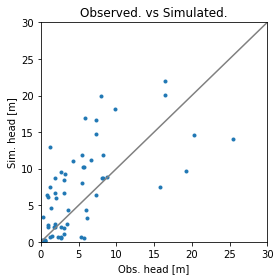

Error is - 8.464010876519598
Params are - [  3.98459854 126.46190998  12.66321109   0.27174819   0.31051711
   0.88599029]


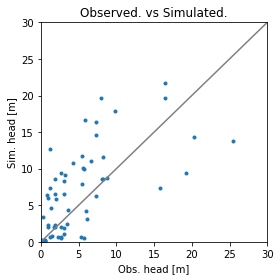

Error is - 8.462500437350915
Params are - [  4.09102112 126.68542754  12.66982924   0.27217661   0.31612521
   0.88066138]


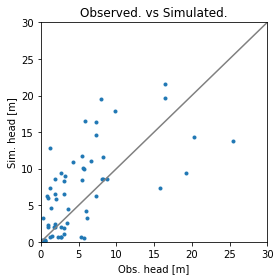

Error is - 8.463432757700048
Params are - [  4.17626697 124.98392798  12.56178769   0.25429583   0.31553501
   0.89993019]


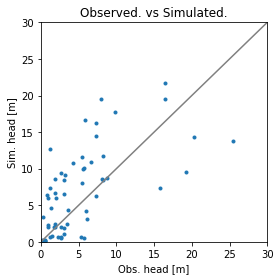

Error is - 8.462546122296978
Params are - [  4.05937989 126.28612131  12.64672927   0.26768316   0.31819422
   0.88405704]


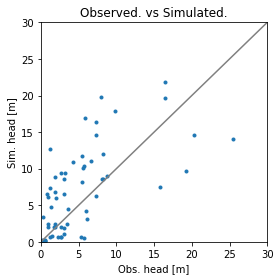

Error is - 8.46323843796577
Params are - [  3.94011166 125.72129199  12.62148426   0.26298107   0.31605123
   0.89120573]


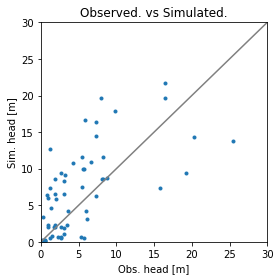

Error is - 8.462625656670593
Params are - [  4.05587186 128.29133779  12.76851743   0.28866271   0.31732521
   0.86222241]


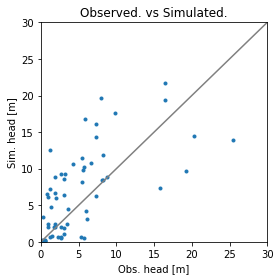

Error is - 8.463174417800733
Params are - [  3.9505452  126.28230171  12.64940157   0.26725812   0.32175206
   0.88241936]


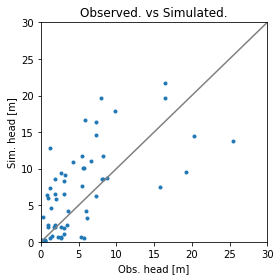

Error is - 8.462583988358325
Params are - [  4.04537637 127.95539439  12.7506037    0.28572103   0.31546408
   0.86677961]


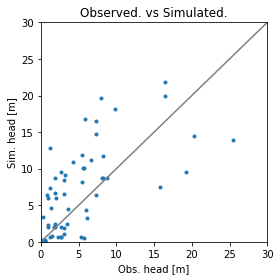

Error is - 8.463238249164572
Params are - [  4.07128202 125.7792625   12.61232764   0.26288637   0.31258154
   0.89314711]


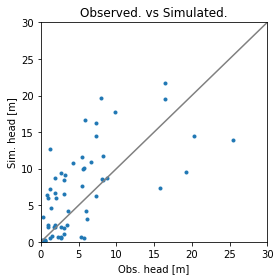

Error is - 8.462553471481085
Params are - [  4.00171917 128.00802585  12.75586417   0.28593327   0.31872286
   0.86440467]


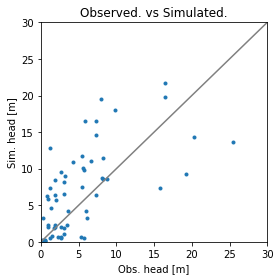

Error is - 8.463347167493351
Params are - [  4.17259004 128.2088779   12.76243138   0.2887732    0.31419812
   0.86420011]


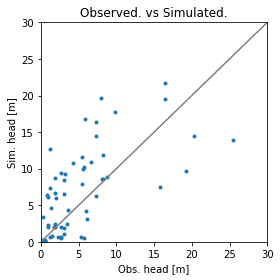

Error is - 8.462513433555994
Params are - [  3.97440809 127.10947333  12.69998572   0.27640321   0.31783385
   0.87524701]


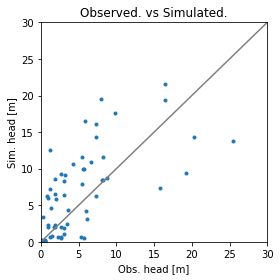

Error is - 8.462922621154487
Params are - [  4.08648148 127.14925117  12.69724802   0.27587756   0.32065508
   0.87319423]


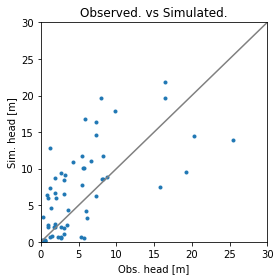

Error is - 8.462502474076866
Params are - [  4.01370339 127.50931947  12.72425837   0.28120622   0.31558882
   0.87174592]


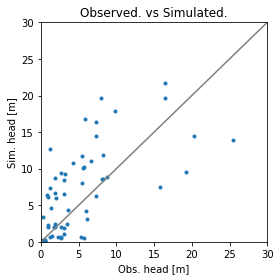

Error is - 8.462588036462039
Params are - [  4.00599748 126.22658284  12.64723939   0.26771179   0.31665113
   0.88540947]


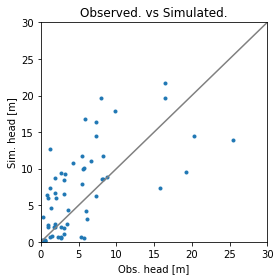

Error is - 8.462438042579732
Params are - [  4.01846607 126.74277158  12.6775589    0.27294952   0.31681965
   0.8796127 ]


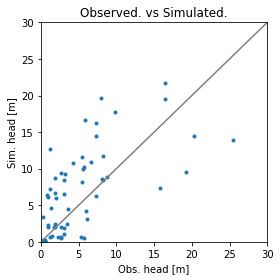

Error is - 8.46264955219274
Params are - [  4.00752287 126.15831864  12.64080486   0.2663963    0.31896413
   0.88512997]


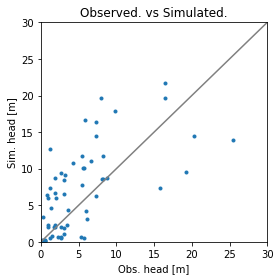

Error is - 8.462438119281497
Params are - [  4.035913   127.50612545  12.72315399   0.28088985   0.31633909
   0.8713672 ]


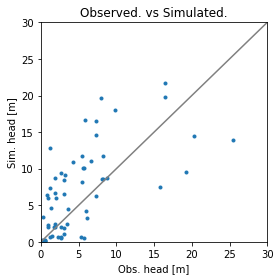

Error is - 8.46273719397537
Params are - [  4.06257802 125.93838704  12.62464099   0.26450291   0.31491075
   0.88982574]


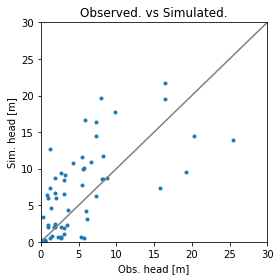

Error is - 8.462421850230832
Params are - [  4.01693388 127.49061615  12.72305837   0.28057568   0.31776984
   0.87075994]


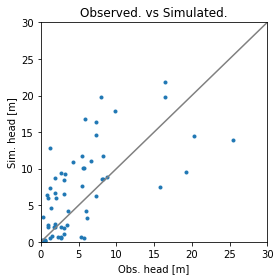

Error is - 8.462675044259926
Params are - [  3.99076863 128.06178986  12.75921892   0.28705053   0.31529794
   0.86574101]


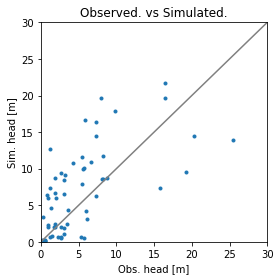

Error is - 8.462421920370025
Params are - [  4.04222707 126.73003845  12.67485168   0.272525     0.31747015
   0.87947803]


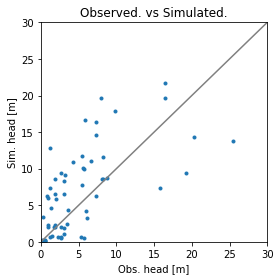

Error is - 8.462540895272051
Params are - [  4.09834676 127.11195955  12.69758447   0.27703775   0.31553707
   0.87596138]


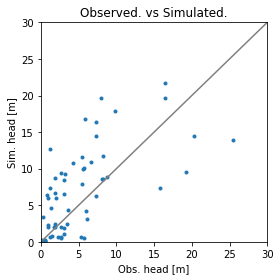

Error is - 8.46242424989116
Params are - [  4.00539276 127.11009489  12.6993854    0.27656184   0.31725966
   0.8754256 ]


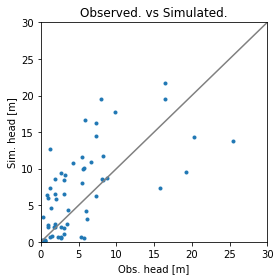

Error is - 8.462502279878644
Params are - [  4.05628125 126.57903855  12.66502083   0.27068662   0.31833905
   0.88068904]


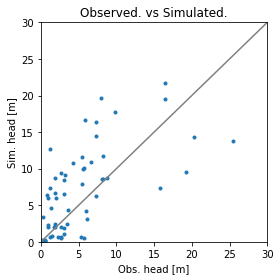

Error is - 8.462423836167686
Params are - [  4.04563678 126.81160878  12.67983021   0.27331652   0.31765149
   0.87845326]


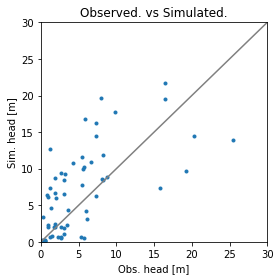

Error is - 8.462548927096252
Params are - [  3.9638354  127.4449909   12.72278361   0.28009619   0.31831141
   0.87103753]


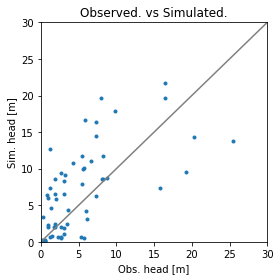

Error is - 8.462418779429722
Params are - [  4.05922469 126.87531838  12.68306783   0.27415651   0.31667176
   0.87825542]


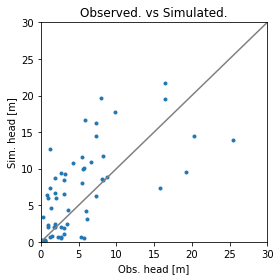

Error is - 8.462505904017252
Params are - [  4.02671409 126.41402395  12.65609682   0.26913851   0.31820842
   0.88262779]


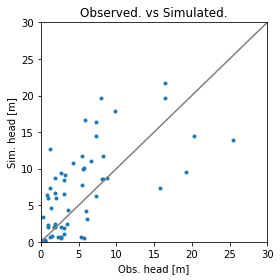

Error is - 8.462402401605422
Params are - [  4.03361327 127.23310008  12.70638969   0.27795201   0.31680642
   0.87418235]


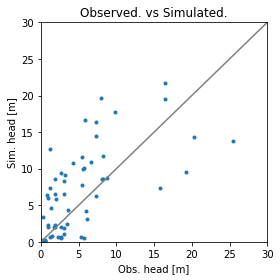

Error is - 8.462426984031739
Params are - [  4.04921008 127.34082066  12.71130217   0.27874634   0.31772345
   0.87257216]


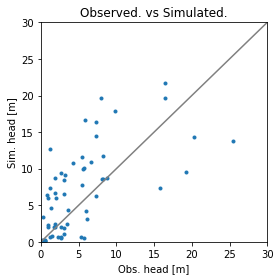

Error is - 8.46240385652027
Params are - [  4.04152408 127.19130839  12.70286635   0.27729713   0.3174975
   0.8743323 ]


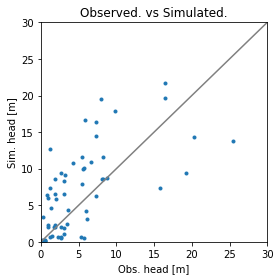

Error is - 8.462448187779017
Params are - [  4.07432717 127.00056852  12.69063598   0.27537911   0.31736273
   0.87639483]


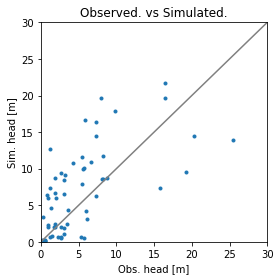

Error is - 8.462401714624109
Params are - [  4.02262636 127.0827133   12.69719805   0.27626616   0.31728542
   0.87566791]


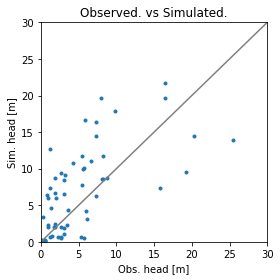

Error is - 8.462406672349076
Params are - [  4.026413   127.3894228   12.71598045   0.27960765   0.31684888
   0.87243873]


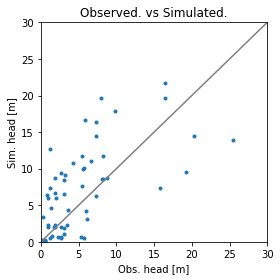

Error is - 8.462443437218006
Params are - [  4.02455135 127.69078792  12.73466857   0.28276004   0.31682313
   0.86906751]


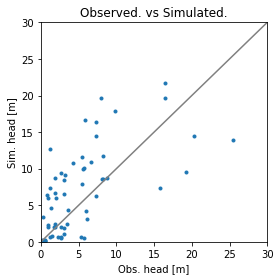

Error is - 8.462399716559878
Params are - [  4.03780814 126.97022582  12.6898059    0.27508376   0.31730839
   0.8768754 ]


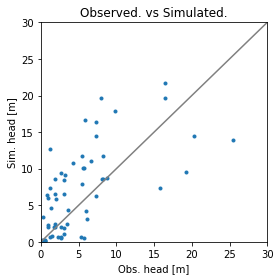

Error is - 8.46243596915792
Params are - [  4.05680263 126.75674677  12.67537772   0.27287872   0.31636962
   0.87982409]


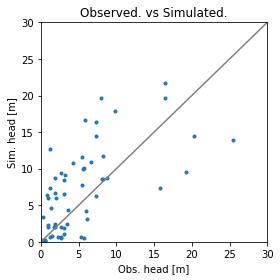

Error is - 8.462400878823823
Params are - [  4.02690107 127.30714881  12.71113821   0.27865144   0.31741978
   0.87302598]


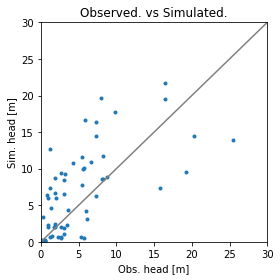

Error is - 8.462435731560783
Params are - [  4.00373728 127.51598802  12.72472505   0.28079621   0.31771704
   0.87058547]


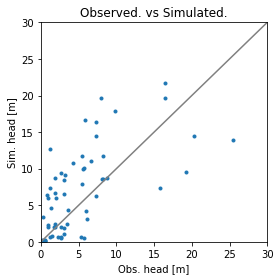

Error is - 8.4623997423208
Params are - [  4.04535284 127.03548579  12.69348214   0.27581643   0.31693308
   0.87633793]


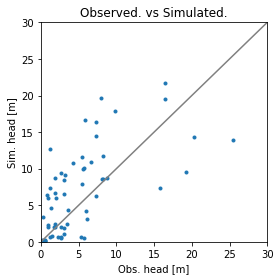

Error is - 8.462414715356681
Params are - [  4.04286225 126.88390459  12.684313     0.27408133   0.31756799
   0.8777019 ]


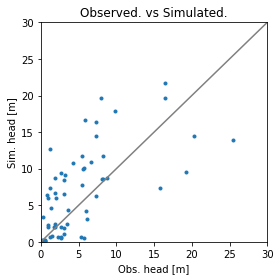

Error is - 8.462397778165313
Params are - [  4.03052531 127.26304325  12.70806359   0.27822607   0.31702865
   0.87375452]


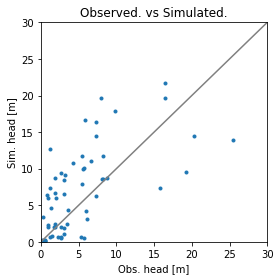

Error is - 8.462404728906733
Params are - [  4.02408492 127.10593062  12.69915951   0.27670149   0.31676308
   0.87561573]


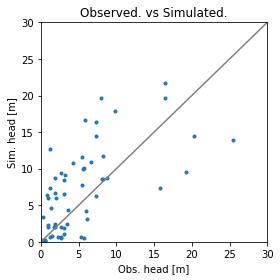

Error is - 8.462397744496403
Params are - [  4.03716429 127.16996395  12.70193964   0.27714822   0.3173139
   0.87465316]


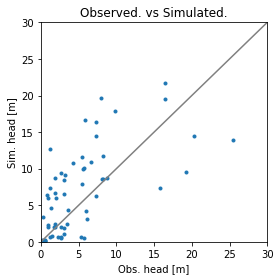

Error is - 8.462400579257809
Params are - [  4.0331794  127.04309356  12.69415282   0.27577868   0.31762332
   0.87592262]


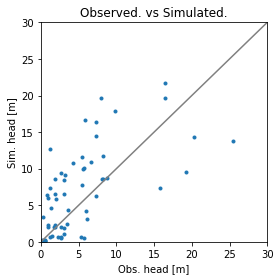

Error is - 8.462401137419839
Params are - [  4.04768399 127.18027376  12.70232938   0.27730205   0.31725695
   0.87452196]


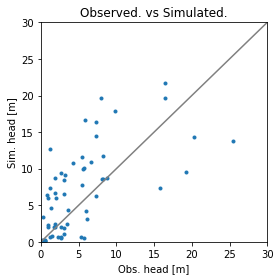

Error is - 8.462396670087385
Params are - [  4.04141958 127.15588364  12.70104655   0.27704307   0.31726407
   0.87480845]


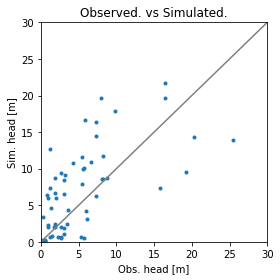

Error is - 8.462405264421205
Params are - [  4.04824879 126.90541653  12.68502533   0.27438064   0.31707069
   0.87775805]


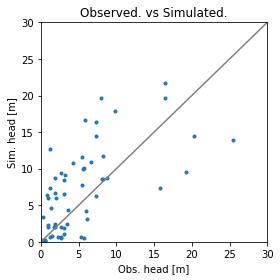

Error is - 8.46239636032024
Params are - [  4.032238   127.20671574  12.70460999   0.27758374   0.31733251
   0.874209  ]


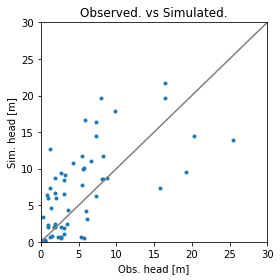

Error is - 8.462403060235186
Params are - [  4.04165665 127.22401251  12.70549646   0.27785508   0.31677021
   0.8742902 ]


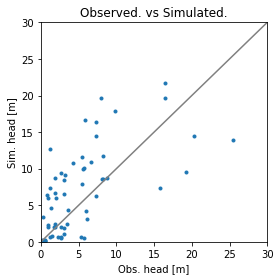

Error is - 8.462396319918463
Params are - [  4.03529871 127.08832329  12.69698873   0.27629778   0.31741004
   0.87551452]


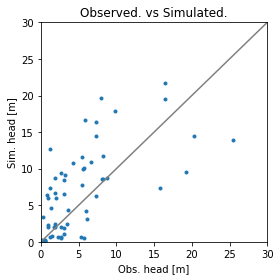

Error is - 8.462401573715281
Params are - [  4.02613184 127.24923277  12.70733599   0.27797779   0.31761944
   0.87360042]


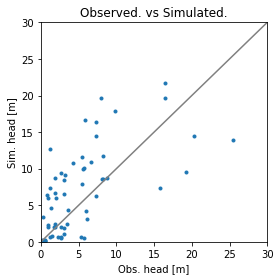

Error is - 8.462396297658923
Params are - [  4.04054759 127.08892253  12.6969456    0.27635677   0.31710467
   0.87565355]


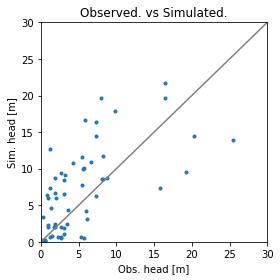

Error is - 8.462401893542765
Params are - [  4.03458969 127.35405832  12.71339213   0.27913479   0.31717622
   0.87265566]


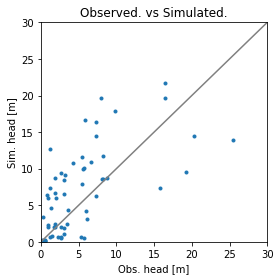

Error is - 8.462396236294227
Params are - [  4.03700353 127.06618394  12.69570246   0.27609652   0.31727535
   0.87582047]


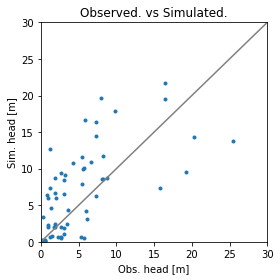

Error is - 8.462405492523724
Params are - [  4.04403192 126.99562112  12.69101407   0.27528264   0.31753819
   0.87646519]


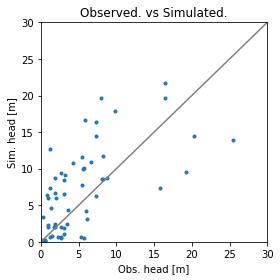

Error is - 8.462395313738446
Params are - [  4.03390197 127.19618772  12.70380121   0.27749021   0.31715604
   0.87443219]


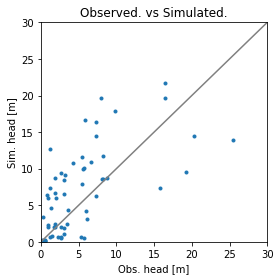

Error is - 8.462393496513844
Params are - [  4.03630551 127.09744167  12.69775854   0.27647448   0.31720033
   0.8754929 ]


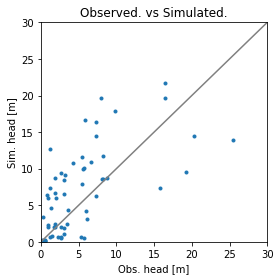

Error is - 8.462392220470338
Params are - [  4.03587612 127.06118054  12.69566799   0.27613761   0.31714355
   0.87591277]


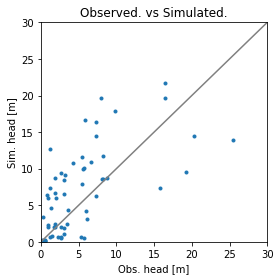

Error is - 8.462395458699309
Params are - [  4.03020239 127.07995428  12.69685877   0.2762778    0.31720998
   0.87570572]


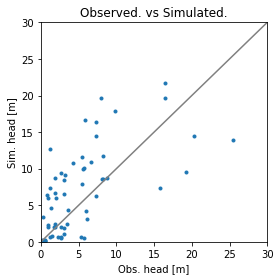

Error is - 8.462396541729015
Params are - [  4.03870544 126.98686836  12.69071159   0.27530182   0.3171007
   0.87680407]


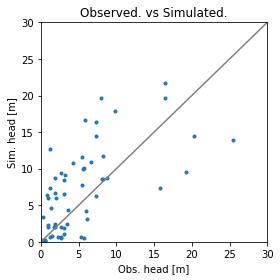

Error is - 8.462394831390009
Params are - [  4.03385486 127.15175389  12.70113539   0.27701326   0.31727456
   0.87485777]


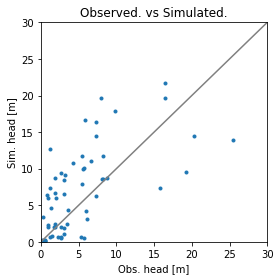

Error is - 8.462394983164858
Params are - [  4.03516343 127.12640434  12.69971508   0.27682627   0.31697801
   0.87527964]


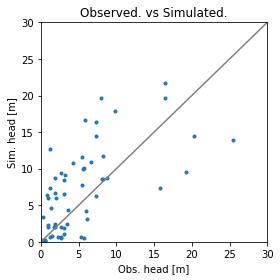

Error is - 8.462394073187076
Params are - [  4.02811984 127.13829903  12.70068137   0.27692379   0.31724116
   0.87501596]


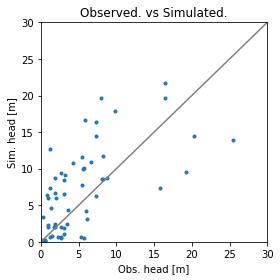

Error is - 8.462394256386244
Params are - [  4.02870267 127.18507599  12.70358414   0.27745979   0.31705908
   0.87458088]


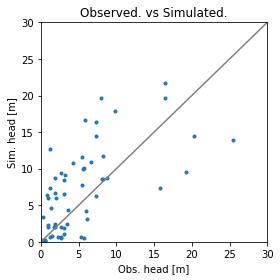

Error is - 8.462393617312648
Params are - [  4.03500391 127.20634623  12.70466962   0.27767251   0.31707415
   0.87432069]


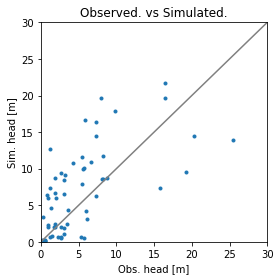

Error is - 8.462391968099029
Params are - [  4.03167164 127.09349896  12.69801666   0.27652087   0.31710079
   0.87555705]


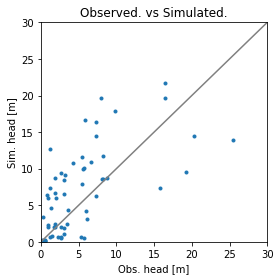

Error is - 8.46239166052859
Params are - [  4.03055648 127.04215458  12.69512438   0.27603619   0.31707317
   0.87611947]


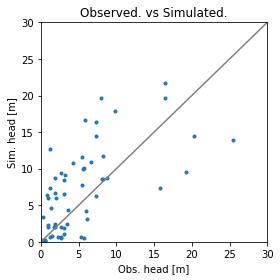

Error is - 8.46239150774701
Params are - [  4.02887452 127.13519908  12.70057255   0.27692144   0.31731055
   0.87498954]


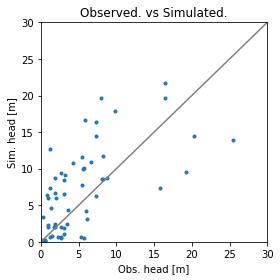

Error is - 8.462392196442638
Params are - [  4.02573007 127.13959645  12.70100128   0.27696903   0.31747682
   0.87484449]


 final_simplex: (array([[  4.02887452, 127.13519908,  12.70057255,   0.27692144,
          0.31731055,   0.87498954],
       [  4.03055648, 127.04215458,  12.69512438,   0.27603619,
          0.31707317,   0.87611947],
       [  4.03587612, 127.06118054,  12.69566799,   0.27613761,
          0.31714355,   0.87591277],
       [  4.03500391, 127.20634623,  12.70466962,   0.27767251,
          0.31707415,   0.87432069],
       [  4.02811984, 127.13829903,  12.70068137,   0.27692379,
          0.31724116,   0.87501596],
       [  4.02870267, 127.18507599,  12.70358414,   0.27745979,
          0.31705908,   0.87458088],
       [  4.03385486, 127.15175389,  12.70113539,   0.27701326,
          0.31727456,   0.87485777]]), array([8.46239151, 8.46239166, 8.46239222, 8.46239362, 8.46239407,
       8.46239426, 8.46239483]))
           fun: 8.46239150774701
       message: 'Optimization terminated successfully.'
          nfev: 440
           nit: 262
        status: 0
       success: True
      

In [37]:
# run optimization 
optimized_flag = True
results = opt.minimize(calibrateo, x0= [100, 100, 10, .5, .5, .5], method="Nelder-Mead",tol = 0.1)
results

# Utilities 

### Write a KML file from a projected shapefile 

In [15]:
def poly_shp_to_kml(IN_SHP, OUT_KML, colorstring = "50ff0000"):
    
    tmp = geopandas.GeoDataFrame.from_file(IN_SHP)
    tmpWGS84 = tmp.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
    tmpWGS84.to_file("{}_temp.shp".format(OUT_KML))   
    
    kml = simplekml.Kml(open=1)       # create the kml file
    pfol = kml.newfolder(name="folder")
    openShape = ogr.Open("{}_temp.shp".format(OUT_KML))

    layers = openShape.GetLayerByIndex(0)
    i = 0
    for element in layers:
        geom = loads(element.GetGeometryRef().ExportToWkb())
        i=i+1
        arrcoords = geom.to_wkt()
        pol = pfol.newpolygon() # the part that creates the kml
        pol.visibility = 50
        pol.style.polystyle.color = colorstring     # 'hexadecimal color string'
        pol.altitudemode = 'relativeToGround'
        pol.extrude = 1
        coords = arrcoords.replace('POLYGON','').replace('(','').replace(')','')
        coords = coords.replace('MULTI','')
        coords = coords.split(',')
        asize = 1
        pol.outerboundaryis = ([(float(coords[j].split()[0]),float(coords[j].split()[1]),asize) for j in range(len(coords))])

    kml.save(OUT_KML)  # save the kml

In [16]:
# Implement     (long run time with small grids)
poly_shp_to_kml(os.path.join(workspace, 'Model_polyarea.shp'),  os.path.join(figurespace, 'Model_grid2.kml') )

### Make Goog-earth point kmls of the Obs Sim and Residuals 

In [22]:
out_obs_frame = pd.read_csv(os.path.join(workspace, '{}.hob.out'.format(modelname)), sep = "  ", names  = ['Sim_val', 'Obs_val', 'name', 'trash'], skiprows =1, engine='python')
del out_obs_frame['trash']
out_obs_frame = out_obs_frame.merge(Unique_WLs, on ='name', how='inner' )
out_obs_frame['residual'] = out_obs_frame['Sim_val'] - out_obs_frame['Obs_val']

paramaters_list = ['Obs_val', 'Sim_val', 'residual']
colors_list =     ['ff00ff00', 'ffff0000', 'ff0000ff']

def Point_to_kml(paramaters_list, colors_list):

    for idx, val in enumerate(paramaters_list):
        parameter =  val                                                                                     
        p_mean = out_obs_frame[parameter].mean()                                                                      # used for scaling the symbols
        kml = simplekml.Kml()
        for index, row in out_obs_frame.iterrows():                                                                   # iterate over each row
            pnt = kml.newpoint(name=str(round(row[parameter],2)), coords=[( row["Lon"],row["Lat"])])   # change name to row["Sample ID"]  to display just sample id names   
            pnt.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/road_shield3.png'                 # see http://kml4earth.appspot.com/icons.html   for options of symbols
            pnt.iconstyle.color = '70ffffff'                                                                        # Hex color   note forst two digits are transparency last six are the normal hex color digits, see https://www.colorhexa.com/                                     
            pnt.iconstyle.scale = .5                                                                     # apply scaling
            pnt.style.labelstyle.color =  colors_list[idx]    
        kml.save(path = os.path.join(figurespace, "sim_v_obs_{}.kml".format(parameter)))                               # save the kml

In [24]:
# Implement
Point_to_kml(paramaters_list, colors_list)

### Make Goog-earth overlay kmls of the array inputs

In [941]:
###### Write a KML overlay from a numpy array input to the model  ######
    
def nparray_to_kml(input_array, out_name, ncol=ncol, nrow=nrow, xll=xll, yll=yll, cellsize = np.mean([delc, delr]), cmap = plt.cm.jet, **kw):
    
    from osgeo import gdal, osr
    from mpl_toolkits.basemap import Basemap
    from simplekml import (Kml, OverlayXY, ScreenXY, Units, RotationXY, AltitudeMode, Camera)

# turn the numpy array into an asc raster in UTM zone 2S
    the_asc = os.path.join(figurespace, "{}.asc".format(out_name))
    np.savetxt(the_asc, input_array)

    new_first = ('NCOLS {}\n'                        # these are the parameters for the .asc file
                 'NROWS {}\n'
                 'XLLCENTER {}\n'
                 'YLLCENTER {}\n'
                 'CELLSIZE {}\n'
                 'NODATA_value -999.0\n'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))  

    with open(the_asc, 'r+') as file:                # add in new first line and save file  
        file_data = file.read()
        file. seek(0, 0)
        file. write(new_first + '\n' + file_data)
        
        
# turn the new .asc file into a geo-tiff 
    the_tif = os.path.join(figurespace, "{}.tif".format(out_name))
    in_raster = gdal.Open(the_asc)
    gdal.Warp(the_tif ,in_raster, srcSRS='EPSG:{}'.format(model_epsg), dstSRS='EPSG:4326')
    
    
    
# plotting function to plot and format the tif into a Gearth image that doesnt look like crap
    # Note This plotting function is clunky and not very good, but it is the best example I could find so far, probably should do better
    # One of its main issues is that it reads the data upside down and it needs to be flipped with a command, obviously something is wrong
    # from https://gis.stackexchange.com/questions/184727/plotting-raster-maps-in-python
    
    the_png = os.path.join(figurespace, "{}.png".format(out_name))

    ds = gdal.Open(the_tif)              # tif file in
    data = ds.ReadAsArray()

    data = np.flipud(data)    # this is where that sketchy data flip happens

    gt = ds.GetGeoTransform()   
    proj = ds.GetProjection()

    xres = gt[1]
    yres = gt[5]
    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
    ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
    ymax = gt[3] - yres * 0.5
    x_center=(xmin+xmax)/2
    y_center=(ymin+ymax)/2  

    m = Basemap(llcrnrlon=xmin,llcrnrlat=ymin,urcrnrlon=xmax,urcrnrlat=ymax, projection='merc', lat_0 = y_center, lon_0 = x_center)
    x = np.linspace(0, m.urcrnrx, data.shape[1])
    y = np.linspace(0, m.urcrnry, data.shape[0])
    xx, yy = np.meshgrid(x, y)

    # create the igure object scaled for google earth   from https://ocefpaf.github.io/python4oceanographers/blog/2014/03/10/gearth/
    aspect = np.cos(np.mean([ymin, ymax]) * np.pi/180.0)
    xsize = np.ptp([xmax, xmin]) * aspect
    ysize = np.ptp([ymax, ymin])
    aspect = ysize / xsize

    if aspect > 1.0:
        figsize = (10.0 / aspect, 10.0)
    else:
        figsize = (10.0, 10.0 * aspect)

    if False:

        plt.ioff()  # Make `True` to prevent the KML components from poping-up.
    fig = plt.figure(figsize=figsize,
                     frameon=False,
                     dpi=1024//10)
    # KML friendly image.  If using basemap try: `fix_aspect=False`.
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    cs = m.pcolormesh(xx, yy, data, cmap=cmap) # alpha = .9)                              
    fig.savefig(the_png,  transparent=False, format='png', dpi=600)  
    

# this is the save KML overlay part, there are some options in here that can be changed for visualization stuff
    # from https://ocefpaf.github.io/python4oceanographers/blog/2014/03/10/gearth/
    
    the_kml = os.path.join(figurespace, "{}.kmz".format(out_name))
    
    kml = Kml()
    altitude = kw.pop('altitude', 2e4)
    roll = kw.pop('roll', 0)
    tilt = kw.pop('tilt', 0)
    altitudemode = kw.pop('altitudemode', AltitudeMode.relativetoground)
    camera = Camera(latitude=np.mean([ymax, ymin]),
                    longitude=np.mean([xmax, xmin]),
                    altitude=altitude, roll=roll, tilt=tilt,
                    altitudemode=altitudemode)

    kml.document.camera = camera
    draworder = 0
    for fig in [the_png]:  # NOTE: Overlays are limited to the same bbox.
        draworder += 1
        ground = kml.newgroundoverlay(name='GroundOverlay')
        ground.draworder = draworder
        ground.visibility = kw.pop('visibility', 1)
        ground.name = kw.pop('name', 'overlay')
        ground.color = kw.pop('color', '9effffff')
        ground.atomauthor = kw.pop('author', 'ocefpaf')
        ground.latlonbox.rotation = kw.pop('rotation', 0)
        ground.description = kw.pop('description', 'Matplotlib figure')
        ground.gxaltitudemode = kw.pop('gxaltitudemode',
                                       'clampToSeaFloor')
        ground.icon.href = fig
        ground.latlonbox.east = xmin
        ground.latlonbox.south = ymin
        ground.latlonbox.north = ymax
        ground.latlonbox.west = xmax

    # now make a legend for the kml file 
    the_ledg = os.path.join(figurespace, "legend_{}.png".format(out_name))
    
    fig = plt.figure(figsize=(1.5, 4.0), facecolor=None, frameon=False)
    ax = fig.add_axes([0.0, 0.05, 0.2, 0.9])
    cb = fig.colorbar(cs, cax=ax)
    cb.set_label(out_name, rotation=-90, color='k', labelpad=20)
    fig.savefig(the_ledg, transparent=True, format='png')  # Change transparent to True if your colorbar is not on space :)

    screen = kml.newscreenoverlay(name='ScreenOverlay')
    screen.icon.href = the_ledg
    screen.overlayxy = OverlayXY(x=0, y=0,
                                 xunits=Units.fraction,
                                 yunits=Units.fraction)
    screen.screenxy = ScreenXY(x=0.015, y=0.075,
                               xunits=Units.fraction,
                               yunits=Units.fraction)
    screen.rotationXY = RotationXY(x=0.5, y=0.5,
                                   xunits=Units.fraction,
                                   yunits=Units.fraction)
    screen.size.x = 0
    screen.size.y = 0
    screen.size.xunits = Units.fraction
    screen.size.yunits = Units.fraction
    screen.visibility = 1

    kmzfile = kw.pop('kmzfile', the_kml) 
    kml.savekmz(the_kml)   

    
# note here are soome mappings that might be useful for this function 
#   xmin,        ymin,        xmax,         ymax
# llcrnrlon,   llcrnrlat,   urcrnrlon,   urcrnrlat 

# reproject existing asc raster to a new coordinate system, not used currently but is part of the above function
#def asc_to_prj_tiff(input_asc, output_tiff, ncol=ncol, nrow=nrow, xll=xll, yll=yll, cellsize = np.mean([delc, delr])):
#    in_raster = gdal.Open(input_asc)
#    gdal.Warp(output_tiff ,in_raster, srcSRS='EPSG:{}'.format(model_epsg), dstSRS='EPSG:4326') 

C:\Users\cshuler\Anaconda3\envs\ASPA_Framework\lib\site-packages\ipykernel_launcher.py:57: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<IPython.core.display.Javascript object>


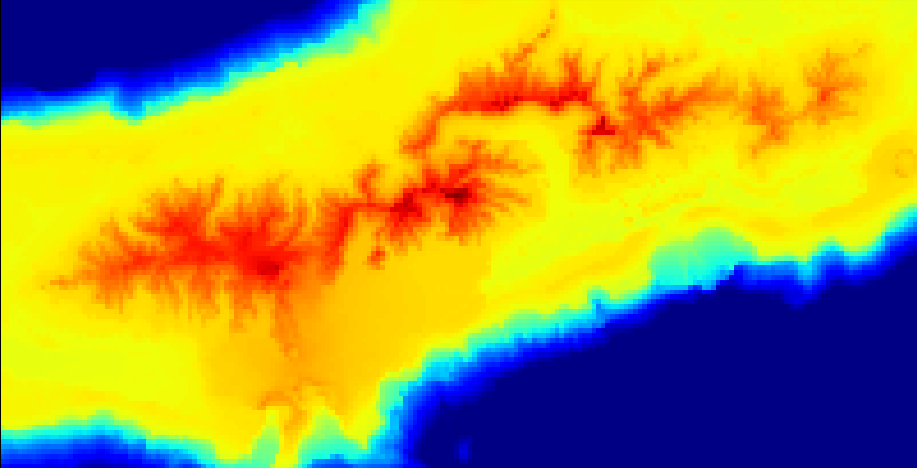

<IPython.core.display.Javascript object>


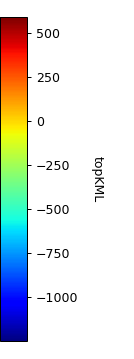

<IPython.core.display.Javascript object>


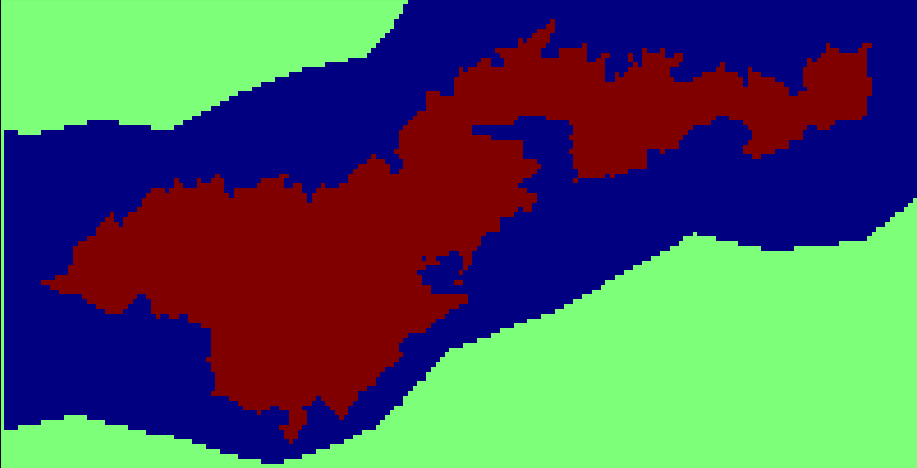

<IPython.core.display.Javascript object>


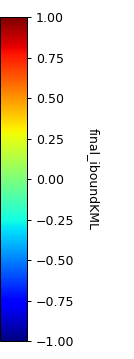

<IPython.core.display.Javascript object>


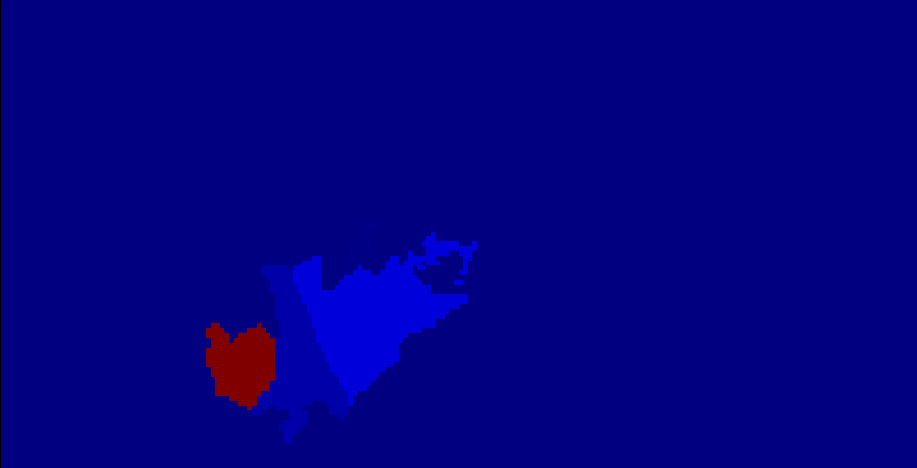

<IPython.core.display.Javascript object>


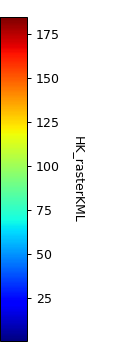

<IPython.core.display.Javascript object>


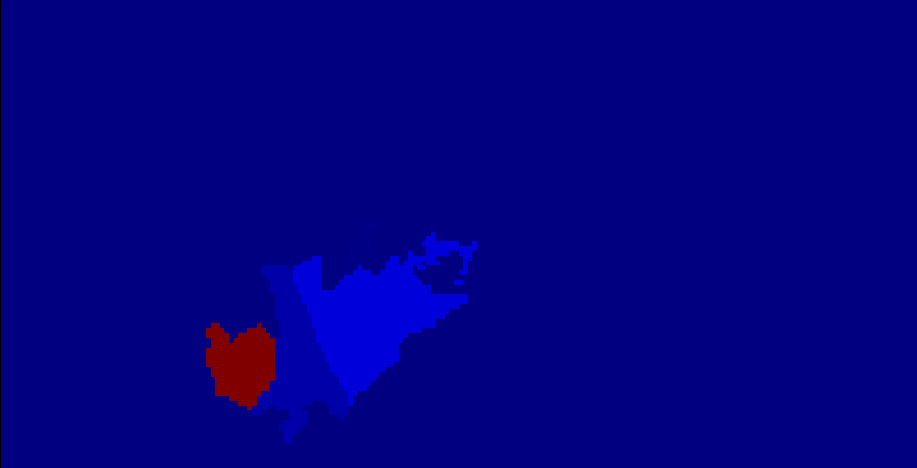

<IPython.core.display.Javascript object>


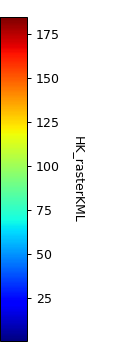

<IPython.core.display.Javascript object>


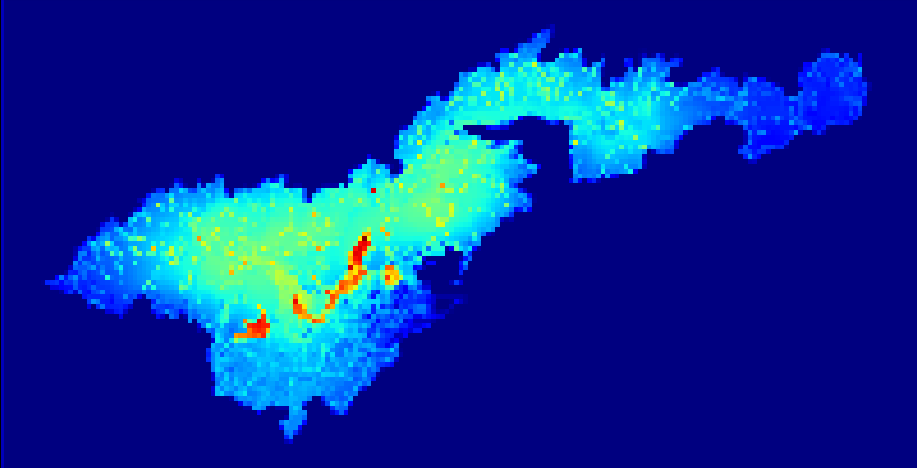

<IPython.core.display.Javascript object>


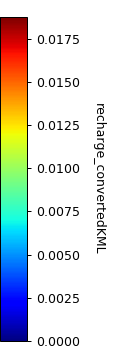

<IPython.core.display.Javascript object>


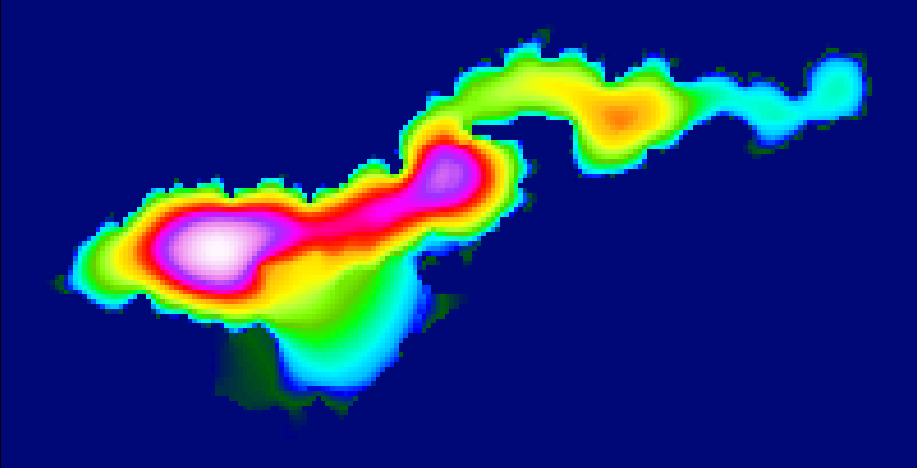

<IPython.core.display.Javascript object>


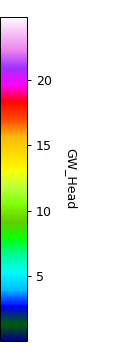

In [942]:
# Implement

# Inputs
nparray_to_kml(top, "topKML")
nparray_to_kml(final_ibound, "final_iboundKML")
nparray_to_kml(HK_raster, "HK_rasterKML")
nparray_to_kml(HK_raster, "HK_rasterKML")
nparray_to_kml(recharge_converted, "recharge_convertedKML")

# outputs
head_plot = head[0]
head_plot = np.where(head_plot < 0, .1, head_plot) # force top elevations to always be higher than bottom elevations
nparray_to_kml(head_plot, "GW_Head", cmap = 'gist_ncar')

## To GMS utilities

Note: to display model in GMS: 
- 1) open up .nam file in GMS. 
- 2) import into GMS with appropriate modflow version (2005 at the moment)
- 3) Open up a coastline shapefile (e.g. tut_poly.shp) in GMS to make sure that it projects correctly, it will prompt to set the display projection
- 4) select 'UTM,  Zone: -2 (174°W - 168°W - Southern Hemisphere), WGS84, meters'
- 5) go to edit -> Transform
- 6) use translate and input value from xll variable (515244.0) and value from yll  (8410178)

In [ ]:
# this is just a little code to export a observation value file for use in GMS. Note to use neeed to open a concept model and obs coverage in GMS then import the OBS_for_GMS_import.csv into that obs coverage.  (dont for get to check heading row)
OBS_4_GMS = Unique_WLs[['x_utm', 'y_utm', 'WL_m_MSL']]
OBS_4_GMS.to_csv(os.path.join(workspace, "OBS_for_GMS_import.csv"))

# Numpy array convert to .asc file

In [85]:
# take a numpy array from this model and turn it into a .asc raster based on the model geometry dimensions
def nparray_to_asc(input_array, output_raster, ncol=ncol,nrow=nrow, xll=xll, yll=yll, cellsize = np.mean([delc, delr])):

    np.savetxt(output_raster, input_array)

    new_first = ('NCOLS {}\n'                        # these are the parameters for the .asc file
                 'NROWS {}\n'
                 'XLLCENTER {}\n'
                 'YLLCENTER {}\n'
                 'CELLSIZE {}\n'
                 'NODATA_value -999.0\n'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))  

    with open(output_raster, 'r+') as file:                # add in new first line and save file  
        file_data = file.read()
        file. seek(0, 0)
        file. write(new_first + '\n' + file_data)

In [3]:
# currently not used functions 

# sometimes Flopy is annoying and prints too much stuff. This function hides printouts   to use just so somenthing in an indented block under "with HiddenPrints():"
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout